In [2]:
import netCDF4 as nc
import os
import pandas as pd
from statsmodels.tsa.seasonal import STL
from scipy import signal
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

## Читаем файл с точками

In [2]:
points_ds=pd.read_csv('./test_grid(10x2).csv', sep=',')
points_ds

id      x      y
0      1   8.72  76.04
1      2   8.72  75.84
2      3   8.72  75.64
3      4   8.72  75.44
4      5   9.72  76.44
..   ...    ...    ...
272  274  31.72  77.04
273  275  31.72  76.84
274  276  31.72  76.64
275  277  31.72  76.44
276  278  32.72  76.84

[277 rows x 3 columns]

In [3]:
def idx_by_2coord(coordinate, lat_array, lon_array):
    # делаем один двумерный массив, в котором каждая ячейка содержит и широту и долготу
    coord_array=np.concatenate((np.array([np.ravel(lat_array)]).T, np.array([np.ravel(lon_array)]).T), axis=1)
    # переворачиваем его к исходной форме
    coord_array=np.reshape(coord_array, (lat_array.shape[0],lat_array.shape[1], 2))
    # вычитаем из каждой координаты нашу координату
    dif=np.abs(coord_array-coordinate)
    # суммируем модули отклонения по обеим координатам
    dis=np.sum(dif, axis=2)
    
    #plt.imshow(dis) # центр "крестика" и есть наша точка
    
    # извлекаем индекс центра "крестика"
    geo_idx = np.unravel_index(dis.argmin(), dis.shape)
    return geo_idx

## Создаем дататест по сетке с ARCTIC reanalysis

In [4]:
nc_file = './arctic-ssh-y2002.nc'
ds = nc.Dataset(nc_file)

In [12]:
coordinates_from_map={'lat': points_ds['y'].tolist(),
                      'lon': points_ds['x'].tolist()}

names_dict={}

for i in range (len(coordinates_from_map['lat'])):
    name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
    names_dict[name]=[]
#print(names_dict)

for j in range(365):  
    sea_level=np.array(ds['ssh'])[j]
    for i in range (len(coordinates_from_map['lat'])):       
        #print('Day: '+str(j)+'Point: '+str(i))        

        in_lat = coordinates_from_map['lat'][i]
        in_lon = coordinates_from_map['lon'][i]

        lats = ds.variables['latitude'][:]
        lons = ds.variables['longitude'][:]

        idx = idx_by_2coord([in_lat, in_lon], lats, lons)

        value=sea_level[idx[0], idx[1]]
        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
        names_dict[name].append(value)
#names_dict

"\nfor j in range(365):  \n    sea_level=np.array(ds['ssh'])[j]\n    for i in range (len(coordinates_from_map['lat'])):       \n        #print('Day: '+str(j)+'Point: '+str(i))        \n\n        in_lat = coordinates_from_map['lat'][i]\n        in_lon = coordinates_from_map['lon'][i]\n\n        lats = ds.variables['latitude'][:]\n        lons = ds.variables['longitude'][:]\n\n        idx = idx_by_2coord([in_lat, in_lon], lats, lons)\n\n        value=sea_level[idx[0], idx[1]]\n        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])\n        names_dict[name].append(value)"

In [6]:
pd_df = pd.DataFrame(names_dict, columns = list(names_dict.keys()))
per = pd.date_range(start ='1-1-2002', end ='31-12-2002', freq ='1D')
pd_df['dates']=per
pd_df=pd_df.sort_values(by=['dates'])
#pd_df.to_csv('./timelines_data/formed_timelines_2002/2002_ARCTIC_reanalysis_GRID.csv', sep=';', index=False)
pd_df

76.04_8.72  75.84_8.72  75.64_8.72  75.44_8.72  76.44_9.72  76.24_9.72  \
0     -0.514026   -0.515261   -0.516009   -0.507082   -0.504714   -0.506331   
1     -0.489136   -0.489905   -0.490766   -0.482878   -0.479015   -0.480923   
2     -0.479917   -0.480635   -0.481603   -0.473776   -0.470219   -0.471974   
3     -0.464741   -0.465282   -0.466064   -0.458172   -0.455844   -0.457293   
4     -0.471832   -0.472478   -0.473560   -0.467324   -0.464111   -0.465617   
..          ...         ...         ...         ...         ...         ...   
360   -0.492056   -0.499308   -0.509579   -0.497058   -0.472869   -0.473256   
361   -0.493447   -0.500768   -0.509778   -0.496599   -0.475878   -0.475752   
362   -0.488364   -0.495617   -0.503469   -0.489825   -0.470997   -0.470725   
363   -0.479422   -0.487205   -0.495123   -0.481621   -0.458476   -0.458770   
364   -0.481368   -0.489566   -0.497673   -0.485063   -0.458351   -0.458765   

     76.04_9.72  75.84_9.72  75.64_9.72  75.44_9.72  ...  76.84_30.72  \
0     -0.507329   -0.507026   -0.506257   -0.504071  ...    -0.466387   
1     -0.480595   -0.480320   -0.479774   -0.477917  ...    -0.397489   
2     -0.470476   -0.470214   -0.469766   -0.467735  ...    -0.414249   
3     -0.454120   -0.453899   -0.453569   -0.451797  ...    -0.454798   
4     -0.463902   -0.463887   -0.463729   -0.463607  ...    -0.417114   
..          ...         ...         ...         ...  ...          ...   
360   -0.475143   -0.481787   -0.486860   -0.475467  ...    -0.337861   
361   -0.477817   -0.484504   -0.489610   -0.477847  ...    -0.368982   
362   -0.473053   -0.479672   -0.484616   -0.471987  ...    -0.378845   
363   -0.462646   -0.469849   -0.475197   -0.462204  ...    -0.365876   
364   -0.463176   -0.470947   -0.476722   -0.464116  ...    -0.341723   

     76.64_30.72  76.44_30.72  76.24_30.72  77.04_31.72  76.84_31.72  \
0      -0.467167    -0.464832    -0.464832    -0.459716    -0.464722   
1      -0.397711    -0.393654    -0.393654    -0.386779    -0.385702   
2      -0.422216    -0.431802    -0.431802    -0.398815    -0.403768   
3      -0.456824    -0.451600    -0.451600    -0.452358    -0.455313   
4      -0.414506    -0.409456    -0.409456    -0.413606    -0.405627   
..           ...          ...          ...          ...          ...   
360    -0.337925    -0.326738    -0.326738    -0.333726    -0.340791   
361    -0.367491    -0.353319    -0.353319    -0.366919    -0.372422   
362    -0.376277    -0.361715    -0.361715    -0.373679    -0.375883   
363    -0.362276    -0.348200    -0.348200    -0.359182    -0.359662   
364    -0.339048    -0.329151    -0.329151    -0.333329    -0.333413   

     76.64_31.72  76.44_31.72  76.84_32.72      dates  
0      -0.470688    -0.470122    -0.467363 2002-01-01  
1      -0.389440    -0.388129    -0.383589 2002-01-02  
2      -0.418549    -0.425269    -0.416425 2002-01-03  
3      -0.458175    -0.456769    -0.455870 2002-01-04  
4      -0.405894    -0.403097    -0.400696 2002-01-05  
..           ...          ...          ...        ...  
360    -0.345907    -0.340394    -0.362003 2002-12-27  
361    -0.374853    -0.369487    -0.384619 2002-12-28  
362    -0.380451    -0.376854    -0.384335 2002-12-29  
363    -0.365231    -0.361427    -0.368278 2002-12-30  
364    -0.340974    -0.338766    -0.344480 2002-12-31  

[365 rows x 278 columns]

In [7]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

for key in list(names_dict.keys()):
    if key!='dates':
        plt.plot(pd_df['dates'], pd_df[key], label=key)
plt.ylim(-1, 0)
#plt.legend()
plt.show()

# Пропусков нет - круть

## Создаем дататест по сетке с NEMO_SPITZ

In [8]:
nemo_data_folder='./dataset_SPITZ12'

In [9]:
coordinates_from_map={'lat': points_ds['y'].tolist(),
                      'lon': points_ds['x'].tolist()}

names_dict={}

for i in range (len(coordinates_from_map['lat'])):
    name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
    names_dict[name]=[]
    
for file in os.listdir(nemo_data_folder):
    #print(file)        
    try:
        ds = nc.Dataset(os.path.join(nemo_data_folder, file))
    except Exception as e:
        print(e)
        pass
            
    for i in range (len(coordinates_from_map['lat'])):        
        
        sea_level=np.array(ds['zos'][:, :, :])[0]

        in_lat = coordinates_from_map['lat'][i]
        in_lon = coordinates_from_map['lon'][i]

        lats = np.array(ds['nav_lat'])
        lons = np.array(ds['nav_lon'])

        idx = idx_by_2coord([in_lat, in_lon], lats, lons)

        value=sea_level[idx[0], idx[1]]
        name=str(coordinates_from_map['lat'][i])+'_'+str(coordinates_from_map['lon'][i])
        names_dict[name].append(value)

[Errno -51] NetCDF: Unknown file format: b'./dataset_SPITZ12\\SPITZ_1d_00010101_00011231_grid_T_00010101-00010101.nc.aux.xml'


In [10]:
pd_df = pd.DataFrame(names_dict, columns = list(names_dict.keys()))
per = pd.date_range(start ='1-1-2002', end ='1-1-2003', freq ='1D')
pd_df['dates']=per
pd_df=pd_df.sort_values(by=['dates'])
#pd_df.to_csv('./timelines_data/formed_timelines_2002/2002_NEMO_SPITZ_GRID.csv', sep=';', index=False)
pd_df

76.04_8.72  75.84_8.72  75.64_8.72  75.44_8.72  76.44_9.72  76.24_9.72  \
0     -0.942993   -0.937628   -0.930204   -0.926181   -0.949348   -0.954056   
1     -0.942993   -0.937628   -0.930204   -0.926181   -0.949348   -0.954056   
2     -0.954143   -0.949737   -0.943272   -0.941566   -0.963461   -0.964639   
3     -0.931632   -0.929046   -0.923890   -0.923869   -0.941948   -0.942619   
4     -0.916045   -0.914592   -0.909500   -0.909975   -0.932103   -0.931216   
..          ...         ...         ...         ...         ...         ...   
361   -0.926950   -0.936539   -0.923194   -0.904722   -0.943568   -0.933682   
362   -0.938924   -0.949687   -0.938435   -0.915860   -0.955742   -0.947546   
363   -0.949362   -0.961301   -0.950975   -0.923545   -0.966302   -0.959826   
364   -0.957105   -0.970395   -0.961219   -0.931276   -0.973440   -0.968722   
365   -0.958535   -0.972930   -0.962517   -0.934586   -0.973185   -0.969175   

     76.04_9.72  75.84_9.72  75.64_9.72  75.44_9.72  ...  76.84_30.72  \
0     -0.942295   -0.939654   -0.938162   -0.943516  ...    -0.865533   
1     -0.942295   -0.939654   -0.938162   -0.943516  ...    -0.865533   
2     -0.952621   -0.951219   -0.952585   -0.960035  ...    -0.876808   
3     -0.934764   -0.935740   -0.937847   -0.943613  ...    -0.896532   
4     -0.922982   -0.923508   -0.924925   -0.927923  ...    -0.882398   
..          ...         ...         ...         ...  ...          ...   
361   -0.917024   -0.907105   -0.900654   -0.908947  ...    -0.778285   
362   -0.927565   -0.920571   -0.912849   -0.920480  ...    -0.782651   
363   -0.937372   -0.934917   -0.924476   -0.930004  ...    -0.781056   
364   -0.946500   -0.949262   -0.935017   -0.937616  ...    -0.779540   
365   -0.952673   -0.957135   -0.939563   -0.939779  ...    -0.784372   

     76.64_30.72  76.44_30.72  76.24_30.72  77.04_31.72  76.84_31.72  \
0      -0.880952    -0.885008    -0.887473    -0.855233    -0.856440   
1      -0.880952    -0.885008    -0.887473    -0.855233    -0.856440   
2      -0.891283    -0.896531    -0.900448    -0.870082    -0.876918   
3      -0.908186    -0.911249    -0.913017    -0.889516    -0.898641   
4      -0.890130    -0.889501    -0.890809    -0.876646    -0.878063   
..           ...          ...          ...          ...          ...   
361    -0.773105    -0.771124    -0.771343    -0.785147    -0.780579   
362    -0.777705    -0.774124    -0.773126    -0.789242    -0.785402   
363    -0.776708    -0.772152    -0.770868    -0.786105    -0.781754   
364    -0.778097    -0.775524    -0.776043    -0.782384    -0.778408   
365    -0.785398    -0.784189    -0.785722    -0.785718    -0.783202   

     76.64_31.72  76.44_31.72  76.84_32.72      dates  
0      -0.861575    -0.875327    -0.857126 2002-01-01  
1      -0.861575    -0.875327    -0.857126 2002-01-02  
2      -0.881961    -0.893854    -0.881724 2002-01-03  
3      -0.898054    -0.906221    -0.893768 2002-01-04  
4      -0.878136    -0.886778    -0.869840 2002-01-05  
..           ...          ...          ...        ...  
361    -0.772303    -0.773564    -0.795469 2002-12-28  
362    -0.777304    -0.777887    -0.799299 2002-12-29  
363    -0.774197    -0.775878    -0.793030 2002-12-30  
364    -0.773417    -0.779315    -0.788577 2002-12-31  
365    -0.780940    -0.789972    -0.792804 2003-01-01  

[366 rows x 278 columns]

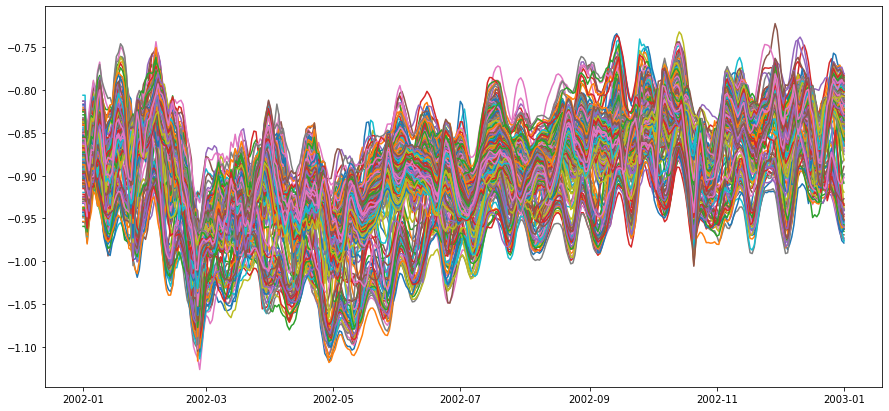

In [11]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

for key in list(names_dict.keys()):
    if key!='dates':
        plt.plot(pd_df['dates'], pd_df[key], label=key)

#plt.legend()
plt.show()

## Сделаем моделирование для каждого временного ряда ARIM'ой и гибридизацией с NEMO и подобьем статистику

In [3]:
df_nemo=pd.read_csv('./timelines_data/formed_timelines_2002/2002_NEMO_SPITZ_GRID.csv', sep=';')
df_nemo['dates'] =  pd.to_datetime(df_nemo['dates'], format='%d.%m.%Y')

for column in list(df_nemo.columns.values):
    if column!='dates':
        df_nemo[column]=df_nemo[column]-np.mean(df_nemo[column])
        stl = STL(df_nemo[column], period=80)
        res = stl.fit()
        params = norm.fit(res.resid)
        ks = kstest(res.resid, 'norm', params, N=1000)
        if ks[1]>=0.05:
            #sns.distplot(res.resid, fit=norm, hist=False)
            #plt.show()
            #print(ks)
            df_nemo[column]=df_nemo[column]-res.resid
        else:
            print(column)
            
df_nemo

76.04_8.72  75.84_8.72  75.64_8.72  75.44_8.72  76.44_9.72  76.24_9.72  \
0      0.043496    0.041205    0.043296    0.049496    0.018957    0.020623   
1      0.047268    0.046536    0.044069    0.050039    0.019246    0.021221   
2      0.044126    0.044443    0.036774    0.041407    0.010971    0.014720   
3      0.062028    0.062371    0.050494    0.054275    0.025246    0.029794   
4      0.071914    0.072430    0.058286    0.061006    0.027560    0.035322   
..          ...         ...         ...         ...         ...         ...   
360    0.045611    0.054914    0.059584    0.077185    0.028578    0.029135   
361    0.040227    0.046561    0.047235    0.068944    0.020274    0.021585   
362    0.036336    0.040292    0.039558    0.064122    0.014276    0.015902   
363    0.032965    0.035805    0.034460    0.062205    0.009790    0.011852   
364    0.031678    0.033542    0.031623    0.061194    0.008079    0.010965   

     76.04_9.72  75.84_9.72  75.64_9.72  75.44_9.72  ...  76.84_30.72  \
0      0.043043    0.037323    0.030662    0.021557  ...    -0.006893   
1      0.045237    0.040602    0.034548    0.025336  ...     0.000493   
2      0.043880    0.036382    0.029206    0.017985  ...    -0.004167   
3      0.058684    0.048697    0.041713    0.030885  ...    -0.010836   
4      0.063933    0.056161    0.049207    0.039845  ...    -0.000004   
..          ...         ...         ...         ...  ...          ...   
360    0.054378    0.072661    0.074267    0.059977  ...     0.111664   
361    0.049065    0.066814    0.069268    0.056660  ...     0.103190   
362    0.045349    0.060325    0.064344    0.053484  ...     0.099011   
363    0.042518    0.053357    0.060313    0.050977  ...     0.098158   
364    0.040451    0.046910    0.057708    0.049543  ...     0.096756   

     76.64_30.72  76.44_30.72  76.24_30.72  77.04_31.72  76.84_31.72  \
0      -0.016234    -0.021648    -0.021540     0.006230     0.002845   
1      -0.009252    -0.014643    -0.014258     0.013718     0.008249   
2      -0.012748    -0.017804    -0.017722     0.007621    -0.002128   
3      -0.015992    -0.018431    -0.017348    -0.000368    -0.010376   
4      -0.003843    -0.003772    -0.002390     0.010757     0.006049   
..           ...          ...          ...          ...          ...   
360     0.117896     0.114245     0.115759     0.105825     0.109763   
361     0.108623     0.107286     0.109981     0.097514     0.100478   
362     0.102547     0.102639     0.105849     0.095617     0.095864   
363     0.100042     0.100620     0.103715     0.097523     0.095937   
364     0.095937     0.094964     0.096638     0.098726     0.096455   

     76.64_31.72  76.44_31.72  76.84_32.72      dates  
0      -0.005700    -0.013671     0.009085 2002-01-01  
1       0.000039    -0.006766     0.014637 2002-01-02  
2      -0.008281    -0.012912     0.003973 2002-01-03  
3      -0.011623    -0.014038     0.001755 2002-01-04  
4       0.003313    -0.000569     0.019566 2002-01-05  
..           ...          ...          ...        ...  
360     0.112713     0.115663     0.101524 2002-12-27  
361     0.104291     0.107933     0.094374 2002-12-28  
362     0.098940     0.101429     0.090882 2002-12-29  
363     0.098053     0.098531     0.092439 2002-12-30  
364     0.095877     0.092865     0.094673 2002-12-31  

[365 rows x 278 columns]

In [4]:
df_rean=pd.read_csv('./timelines_data/formed_timelines_2002/2002_ARCTIC_reanalysis_GRID.csv', sep=';')
df_rean['dates'] =  pd.to_datetime(df_rean['dates'], format='%Y-%m-%d')

for column in list(df_rean.columns.values):
    if column!='dates':
        df_rean[column]=df_rean[column]-np.mean(df_rean[column])
        stl = STL(df_rean[column], period=80)
        res = stl.fit()
        params = norm.fit(res.resid)
        ks = kstest(res.resid, 'norm', params, N=1000)        
        if ks[1]>=0.05:
            #sns.distplot(res.resid, fit=norm, hist=False)
            #plt.show()
            df_rean[column]=df_rean[column]-res.resid
        else:
            print(column)
df_rean

76.04_8.72  75.84_8.72  75.64_8.72  75.44_8.72  76.44_9.72  76.24_9.72  \
0      0.034992    0.034718    0.032032    0.027844    0.026310    0.028339   
1      0.058270    0.058306    0.055602    0.050686    0.049921    0.051845   
2      0.062436    0.062537    0.059925    0.055279    0.054040    0.055957   
3      0.063424    0.063512    0.061063    0.056140    0.054533    0.056757   
4      0.056305    0.056191    0.053409    0.047372    0.047233    0.049387   
..          ...         ...         ...         ...         ...         ...   
360    0.053847    0.047681    0.039707    0.041549    0.063631    0.066376   
361    0.056429    0.049822    0.040671    0.040778    0.063836    0.067421   
362    0.059627    0.053090    0.045162    0.045927    0.066616    0.070397   
363    0.066121    0.059172    0.051419    0.052143    0.075578    0.078953   
364    0.063762    0.056489    0.048829    0.048968    0.074870    0.078118   

     76.04_9.72  75.84_9.72  75.64_9.72  75.44_9.72  ...  76.84_30.72  \
0      0.027947    0.027634    0.026690    0.016180  ...    -0.020535   
1      0.052467    0.052148    0.051075    0.040347  ...     0.022316   
2      0.057700    0.057536    0.056527    0.046154  ...     0.012881   
3      0.059166    0.058829    0.057676    0.046912  ...    -0.017130   
4      0.050545    0.049952    0.048565    0.036534  ...     0.012275   
..          ...         ...         ...         ...  ...          ...   
360    0.062971    0.055390    0.049154    0.048711  ...     0.080870   
361    0.064336    0.056341    0.049220    0.048054  ...     0.059155   
362    0.067439    0.059568    0.052695    0.052243  ...     0.059734   
363    0.074769    0.066495    0.059423    0.059202  ...     0.067323   
364    0.073466    0.064834    0.057580    0.057303  ...     0.079710   

     76.64_30.72  76.44_30.72  76.24_30.72  77.04_31.72  76.84_31.72  \
0      -0.027864    -0.034043    -0.034043     0.008050     0.000913   
1       0.014934     0.009822     0.009822     0.050113     0.046925   
2       0.001712    -0.008514    -0.008514     0.039593     0.032066   
3      -0.022521    -0.022301    -0.022301     0.002329    -0.001674   
4       0.009005     0.006407     0.006407     0.034164     0.037784   
..           ...          ...          ...          ...          ...   
360     0.076975     0.081327     0.081327     0.091999     0.084992   
361     0.056916     0.064658     0.064658     0.071171     0.066003   
362     0.057916     0.064062     0.064062     0.076493     0.074301   
363     0.065050     0.070196     0.070196     0.084828     0.082266   
364     0.077438     0.080678     0.080678     0.097847     0.095381   

     76.64_31.72  76.44_31.72  76.84_32.72      dates  
0      -0.021561    -0.030222     0.001356 2002-01-01  
1       0.027756     0.020172     0.049706 2002-01-02  
2       0.008459    -0.002192     0.025435 2002-01-03  
3      -0.016318    -0.021154     0.004181 2002-01-04  
4       0.022573     0.016598     0.045194 2002-01-05  
..           ...          ...          ...        ...  
360     0.073588     0.072650     0.071904 2002-12-27  
361     0.055439     0.054380     0.060337 2002-12-28  
362     0.060417     0.056684     0.070495 2002-12-29  
363     0.066639     0.062536     0.074877 2002-12-30  
364     0.079860     0.075920     0.088263 2002-12-31  

[365 rows x 278 columns]

In [22]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

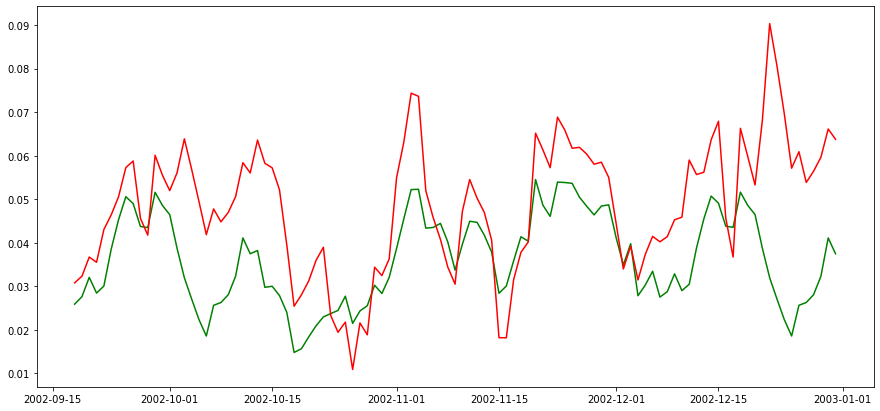

0
Real Value: 0.030798904122140806


1
Real Value: 0.0323252075201681


2
Real Value: 0.03672232480291484


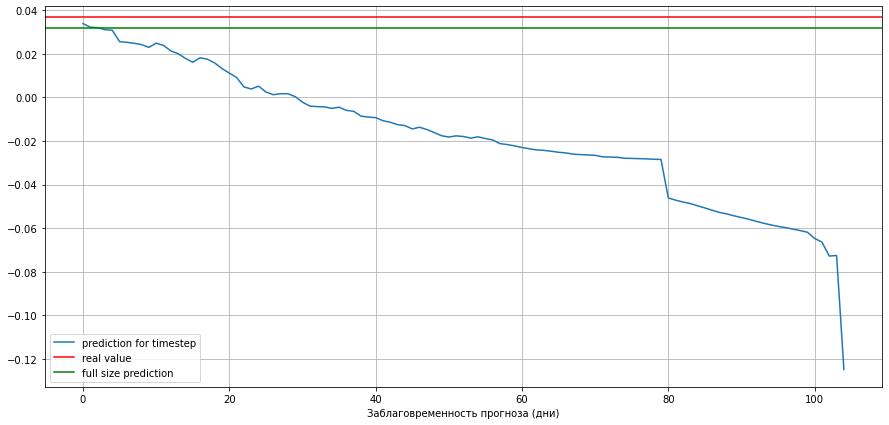

3
Real Value: 0.03551658506220496


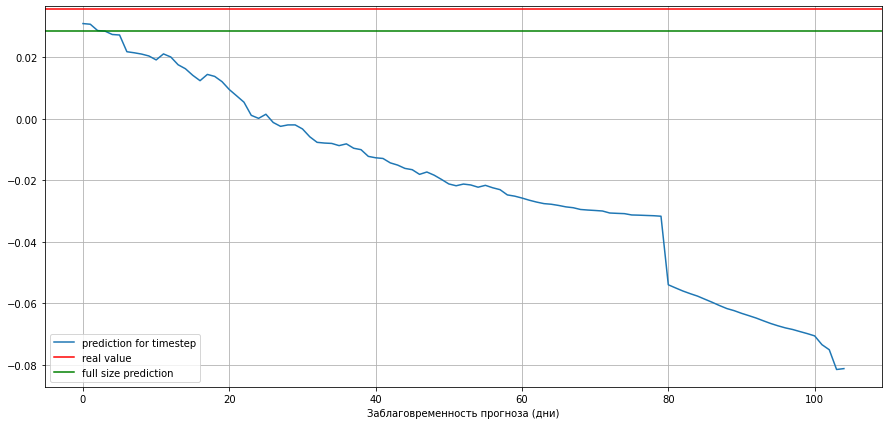

4
Real Value: 0.04305093490984983


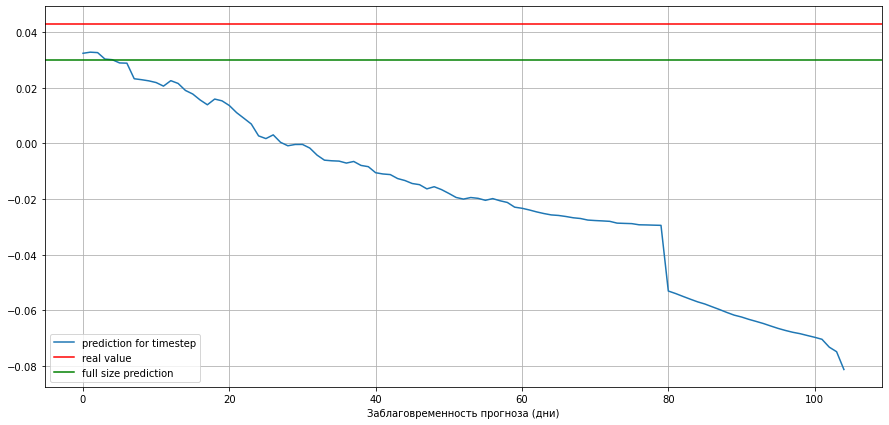

5
Real Value: 0.046407351202918945


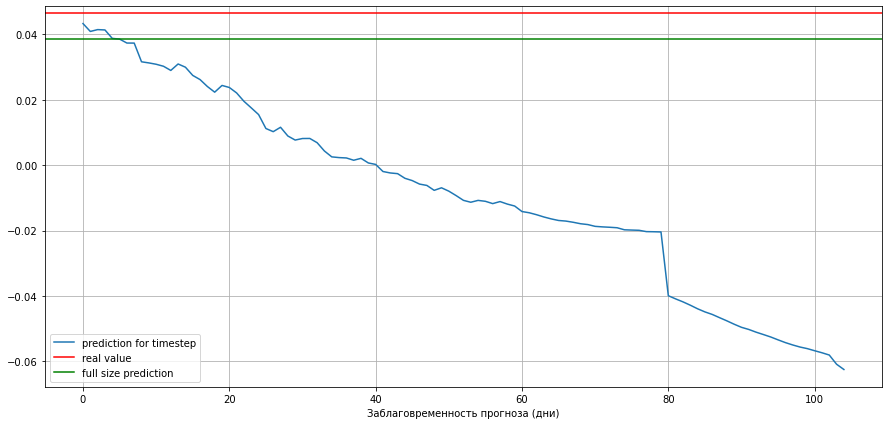

6
Real Value: 0.050539659445614143


7
Real Value: 0.05725514588158741


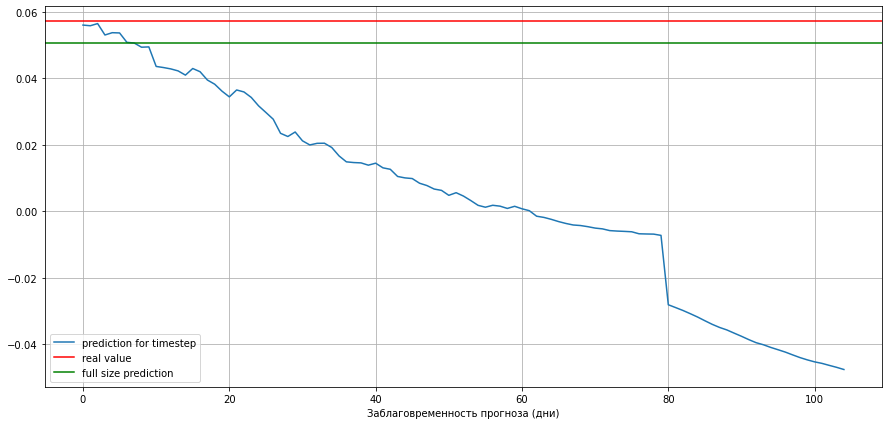

8
Real Value: 0.05877479654567169


9
Real Value: 0.04558893562400673


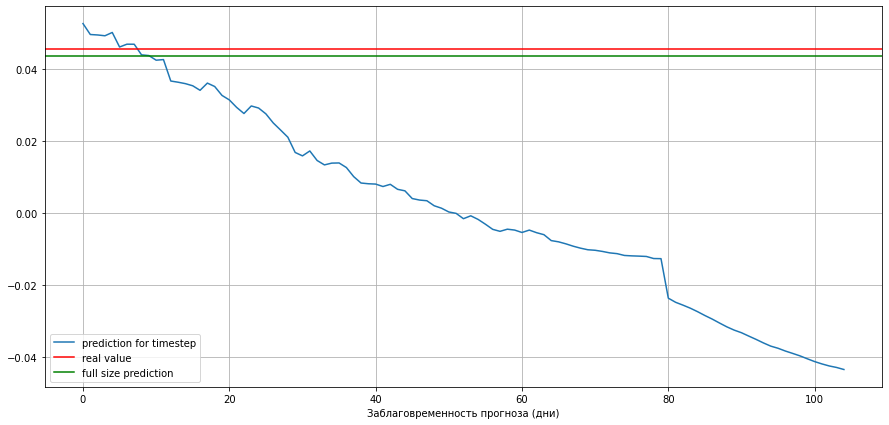

10
Real Value: 0.041758239863664164


11
Real Value: 0.06009810769992612


12
Real Value: 0.055524368718848145


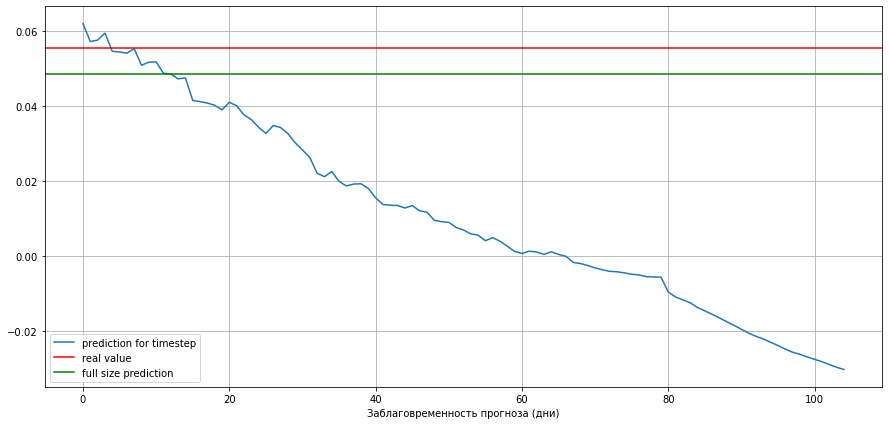

13
Real Value: 0.05197435151435941


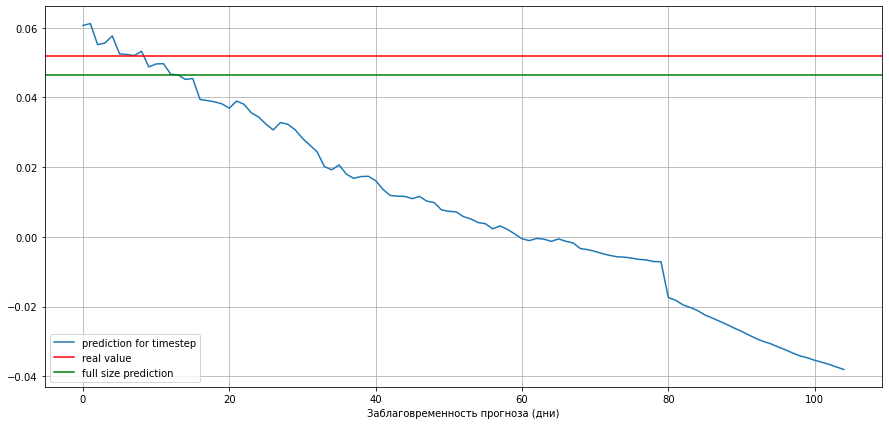

14
Real Value: 0.05607143192179222


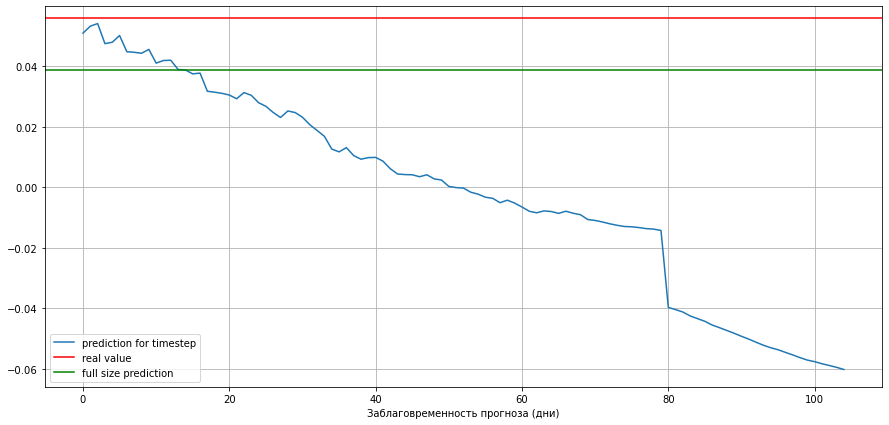

15
Real Value: 0.0638605057288608


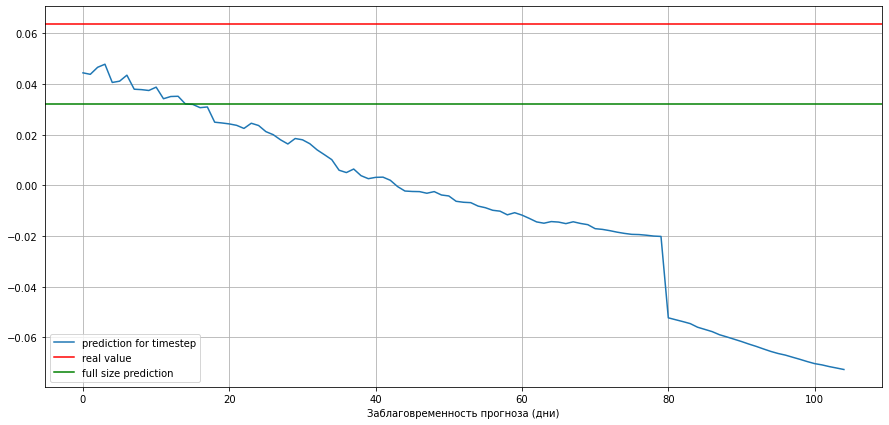

16
Real Value: 0.056828423895693404


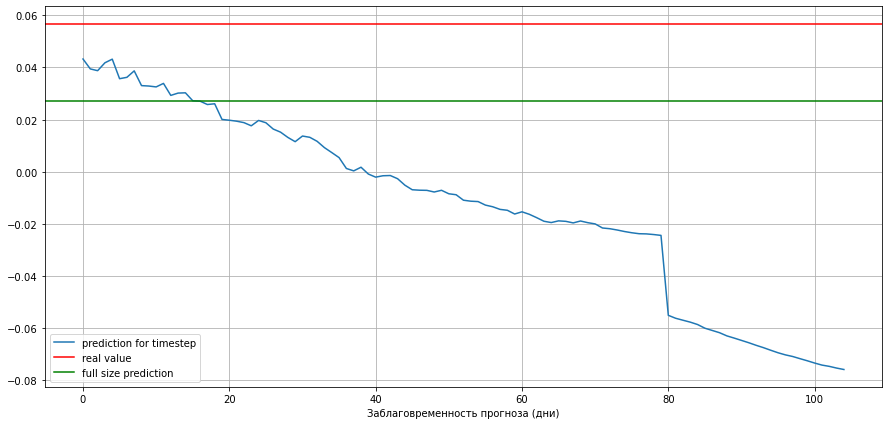

17
Real Value: 0.04944453072409049


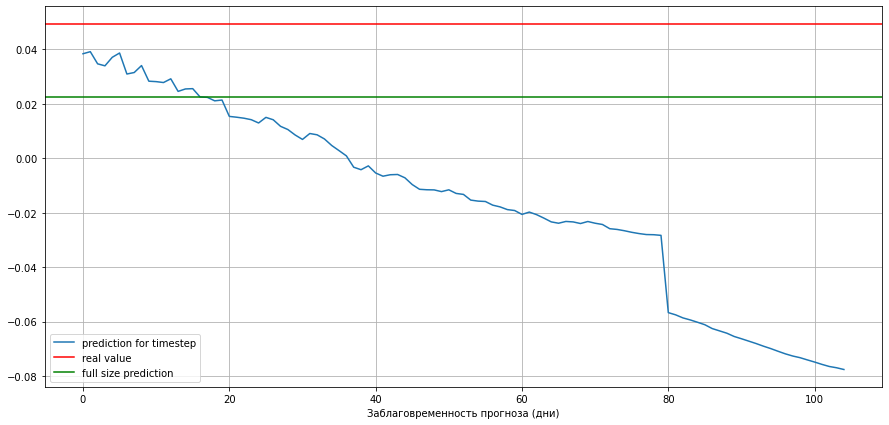

18
Real Value: 0.04186887272970552


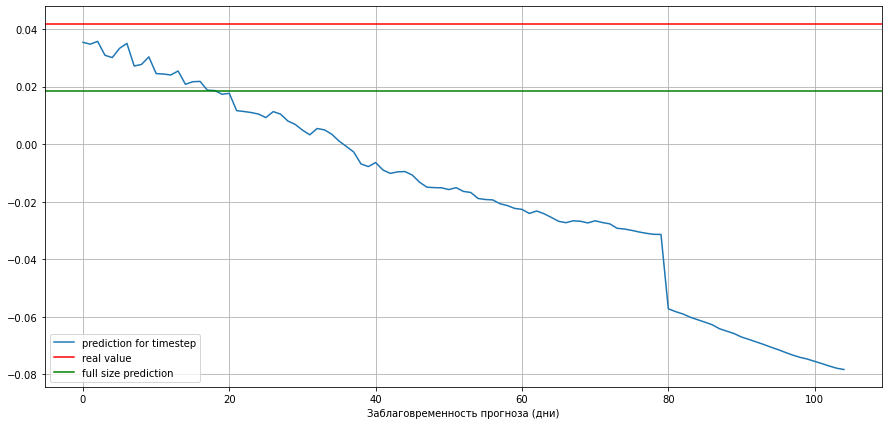

19
Real Value: 0.04776767111606017


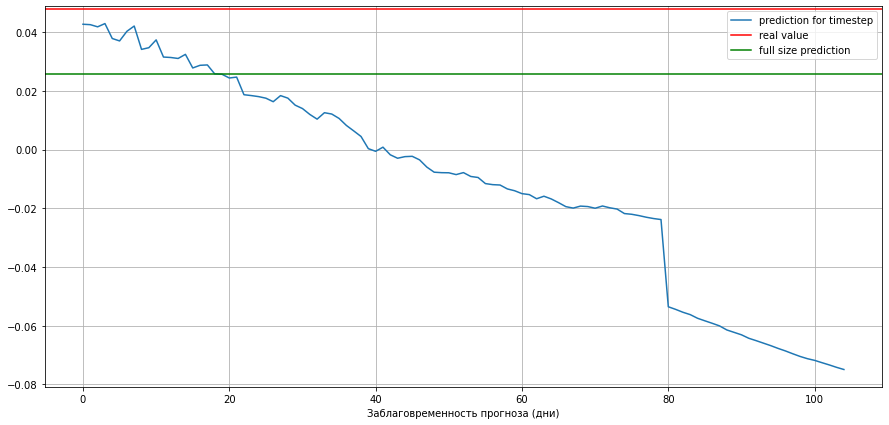

20
Real Value: 0.044804088875942845


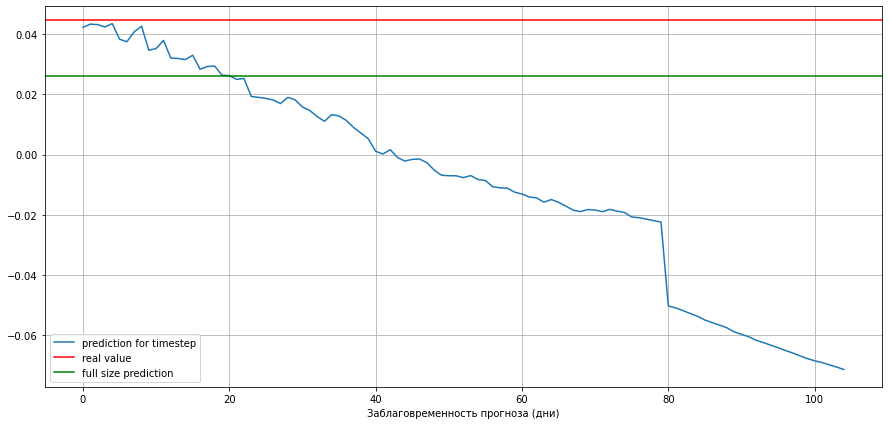

21
Real Value: 0.046969791734061475


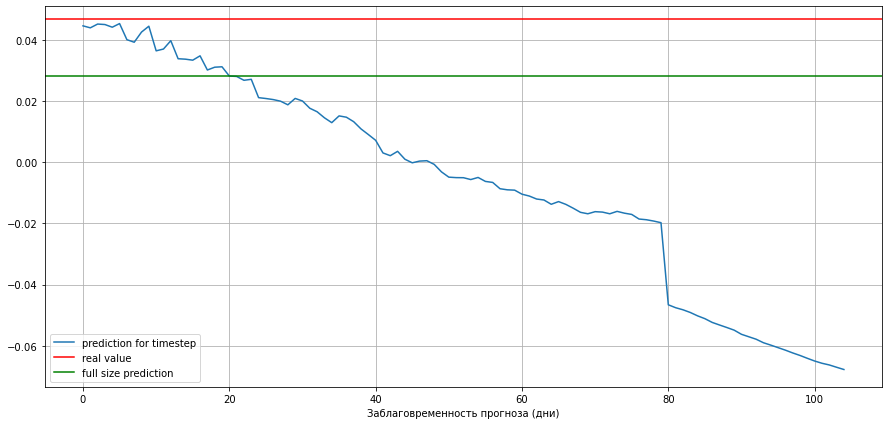

22
Real Value: 0.05058690218870328


23
Real Value: 0.058383771545627634


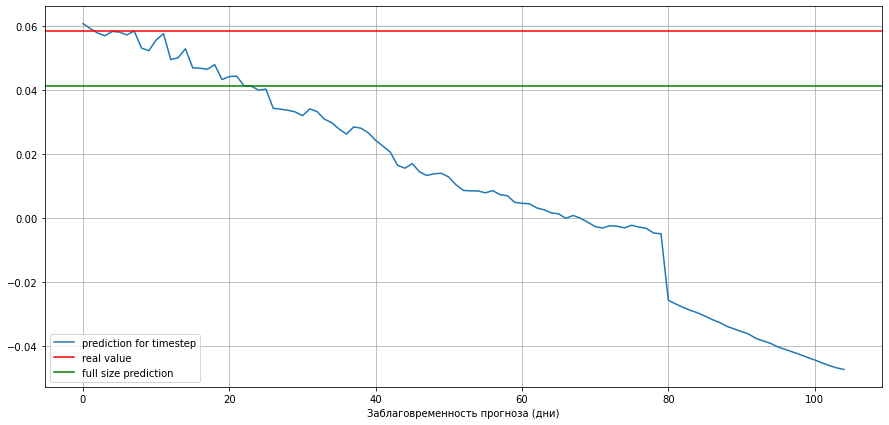

24
Real Value: 0.05603656614871536


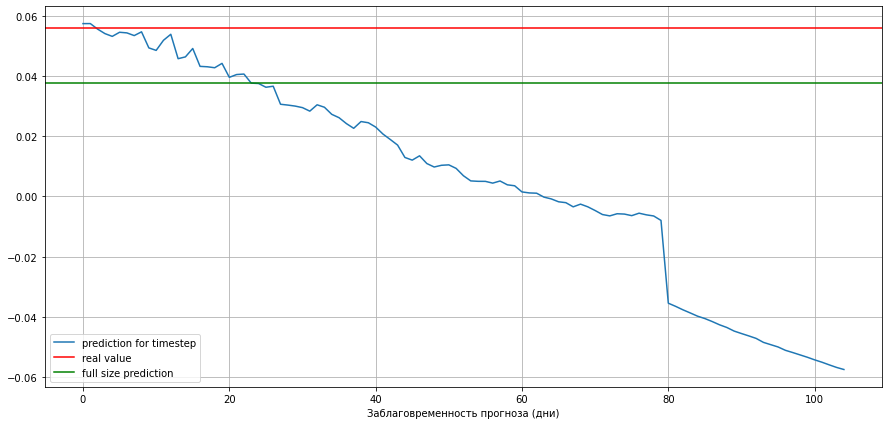

25
Real Value: 0.06357382597302641


26
Real Value: 0.0582515401972306


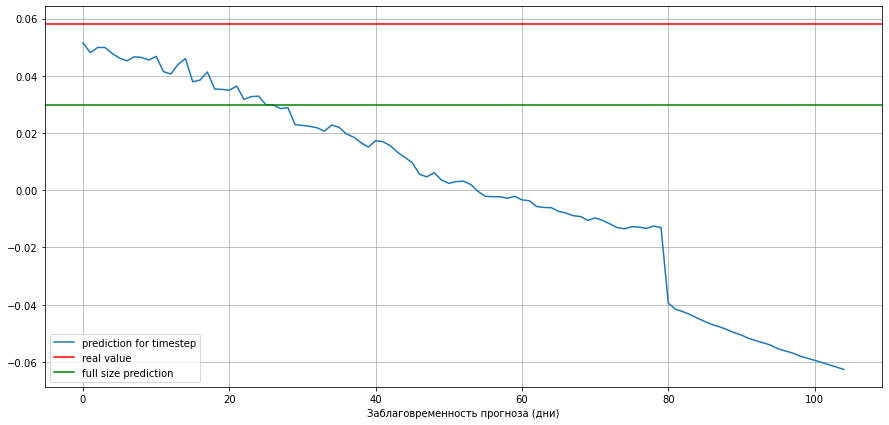

27
Real Value: 0.05721057225727399


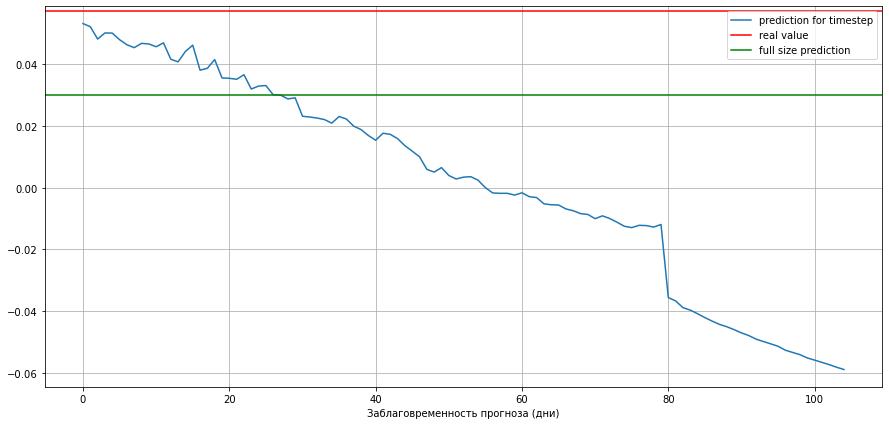

28
Real Value: 0.05217224928928802


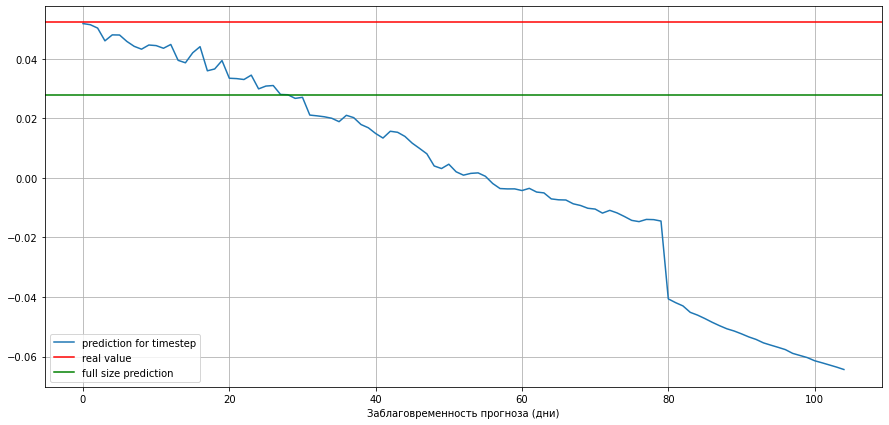

29
Real Value: 0.03949883412157371


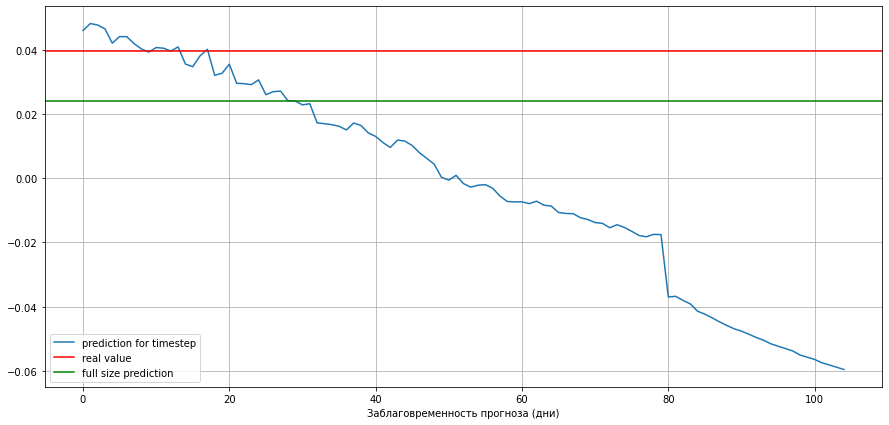

30
Real Value: 0.025440175364765047


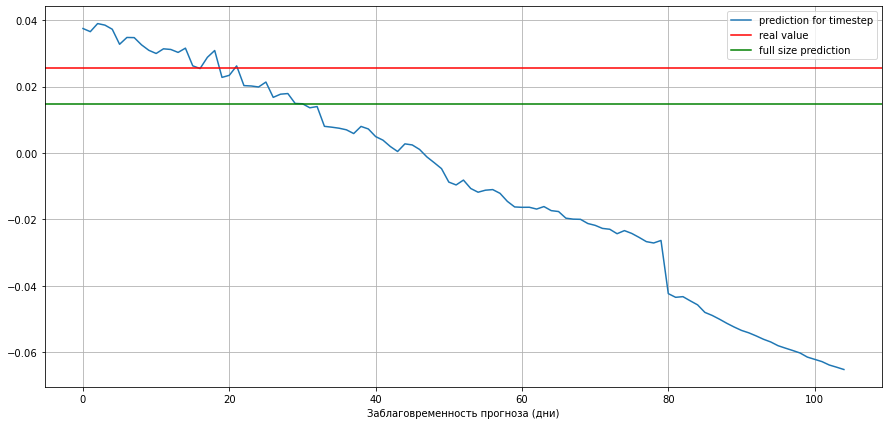

31
Real Value: 0.028044040043070304


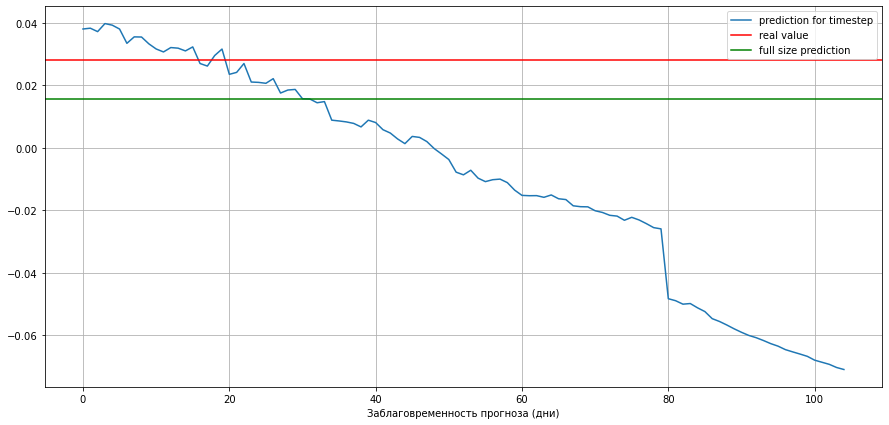

32
Real Value: 0.03125599544476836


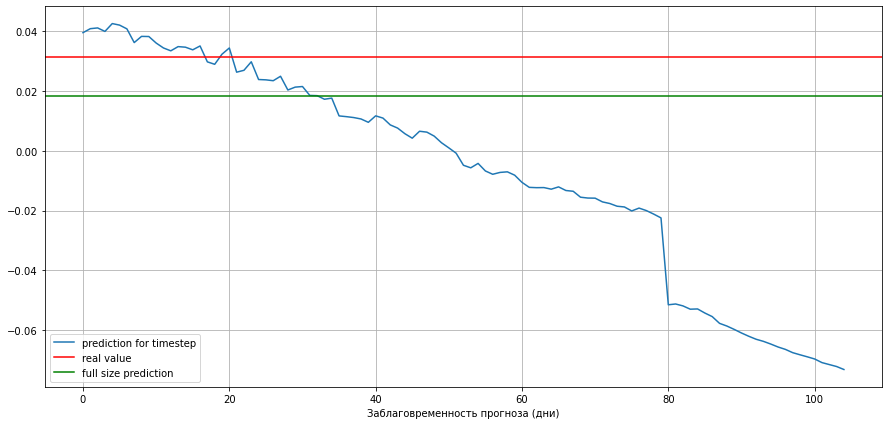

33
Real Value: 0.03596517939874328


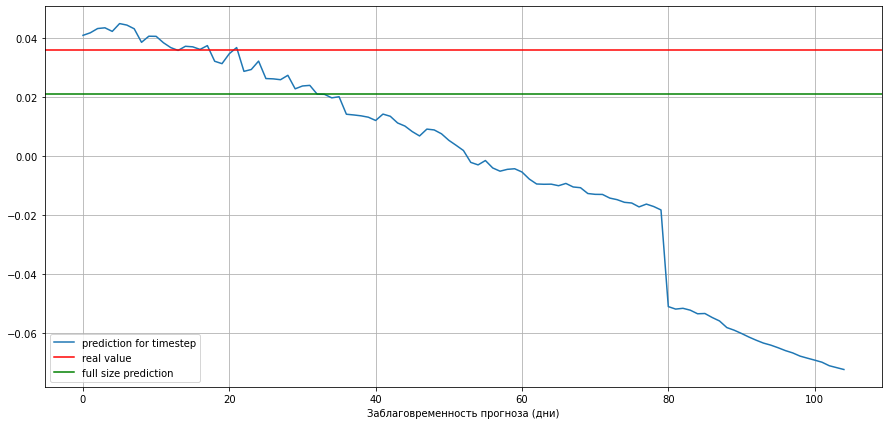

34
Real Value: 0.03897314193253319


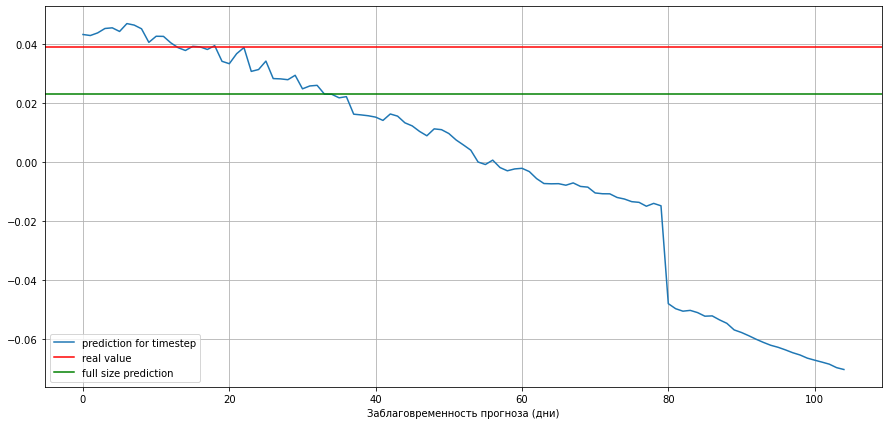

35
Real Value: 0.023333227259079714


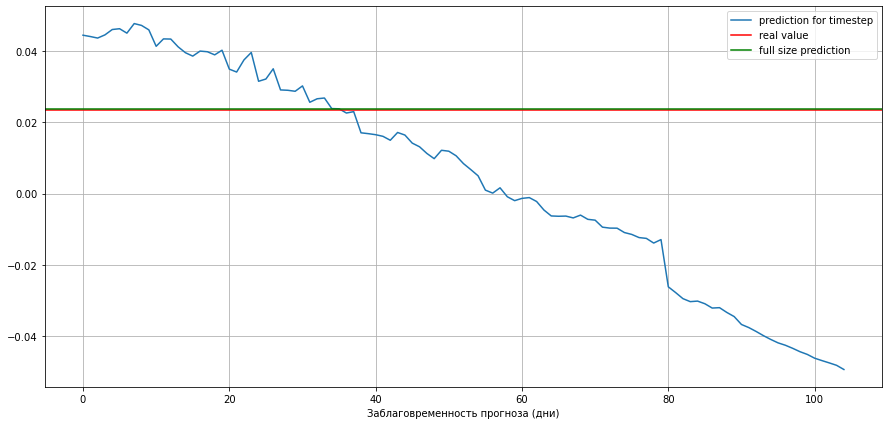

36
Real Value: 0.01944232845803974


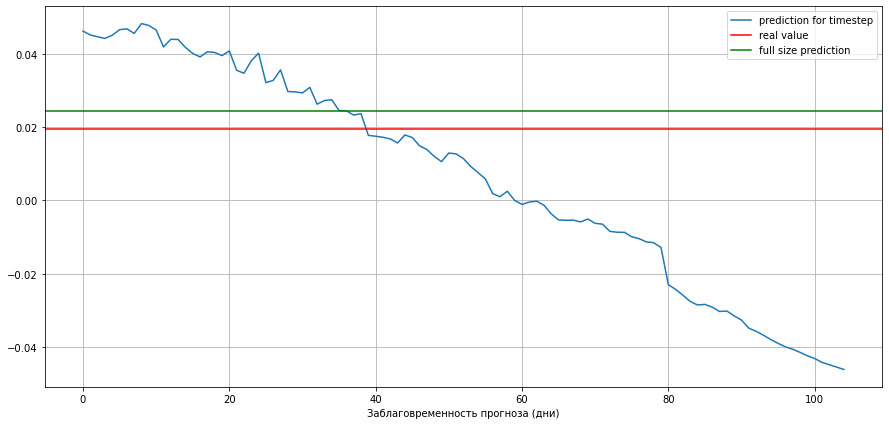

37
Real Value: 0.02178348113121851


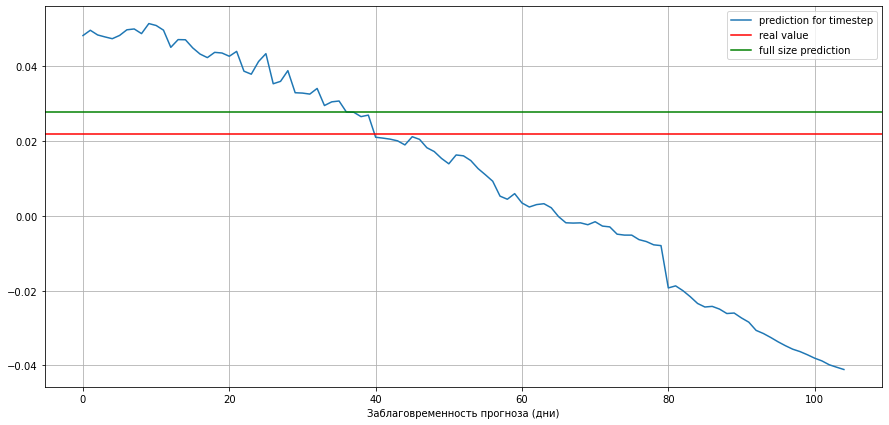

38
Real Value: 0.01090475570627164


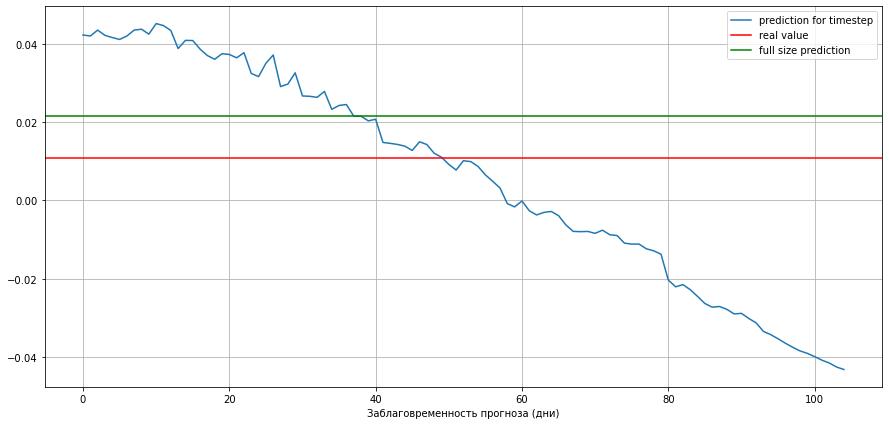

39
Real Value: 0.021594738214707997


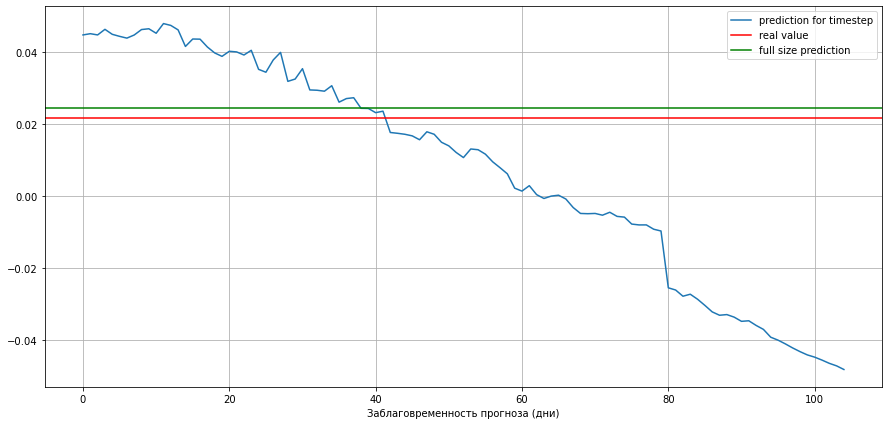

40
Real Value: 0.01886918820059138


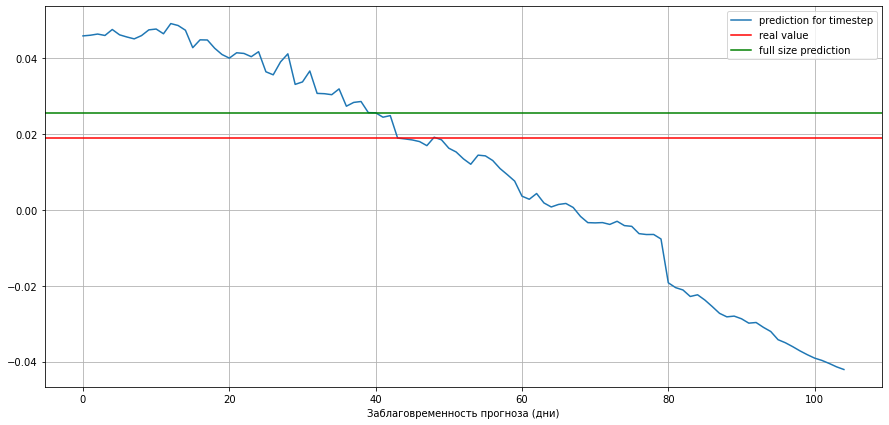

41
Real Value: 0.03439926067934179


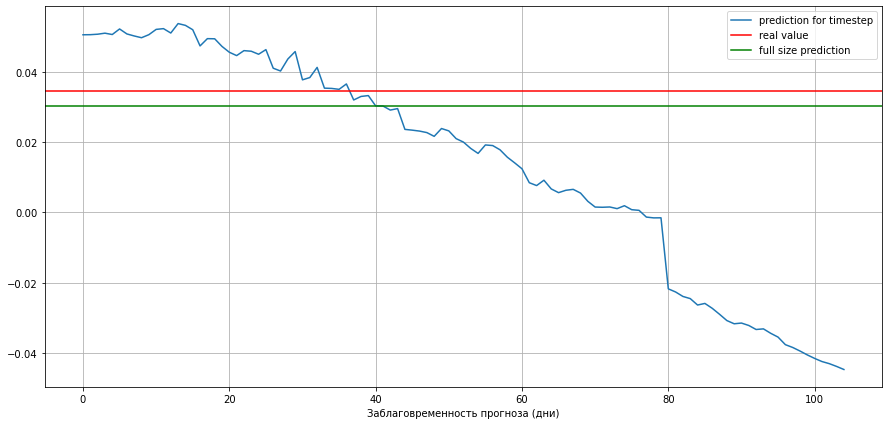

42
Real Value: 0.0324678257831458


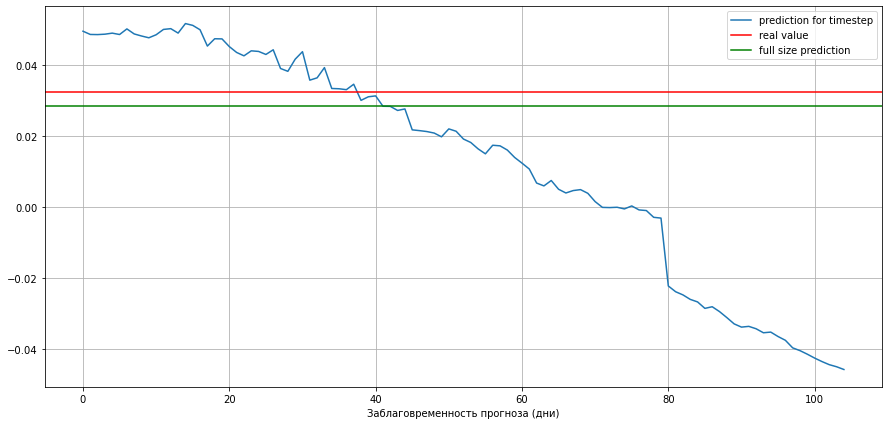

43
Real Value: 0.03632248283830474


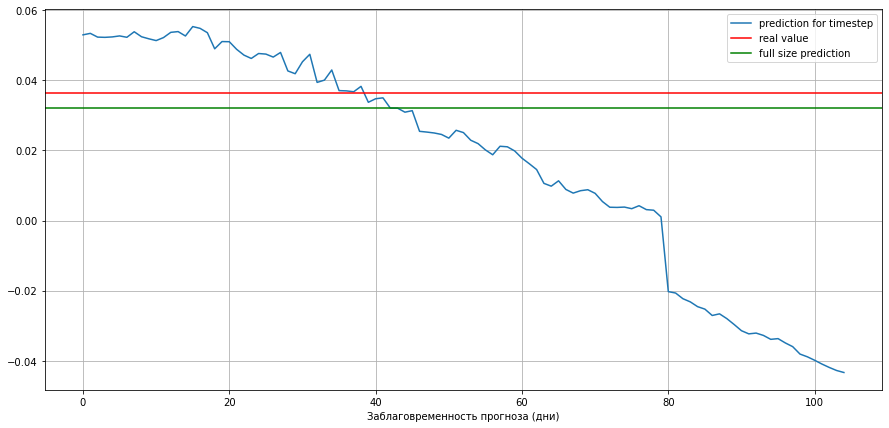

44
Real Value: 0.05489343470857768


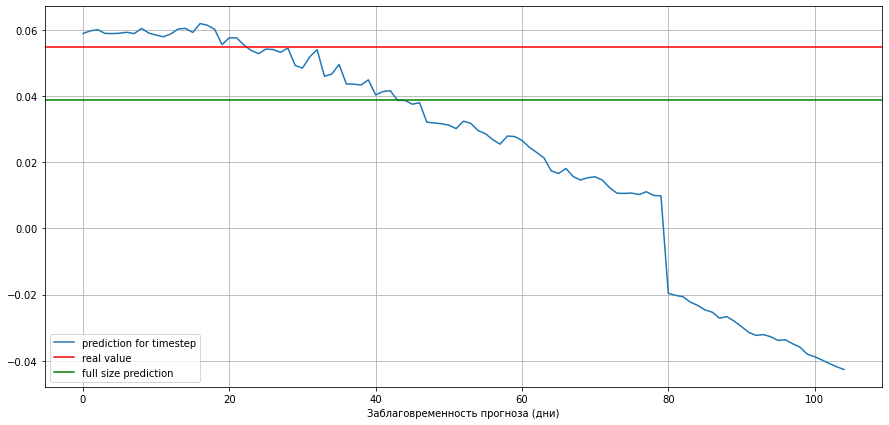

45
Real Value: 0.06315664919129055


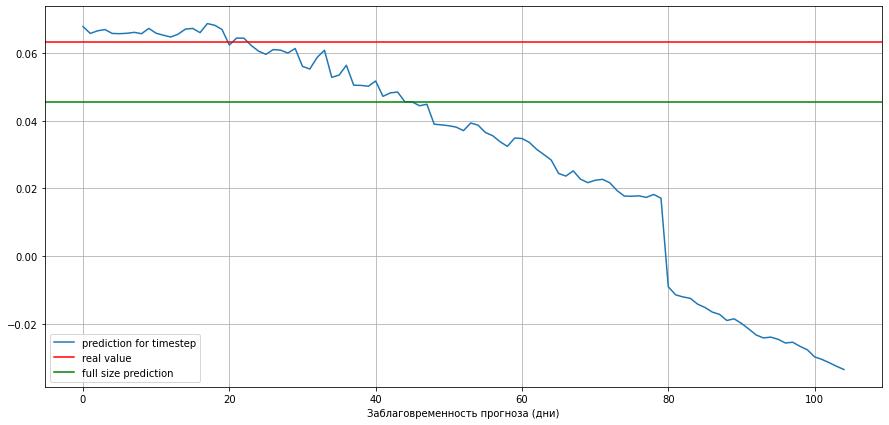

46
Real Value: 0.07435758113868302


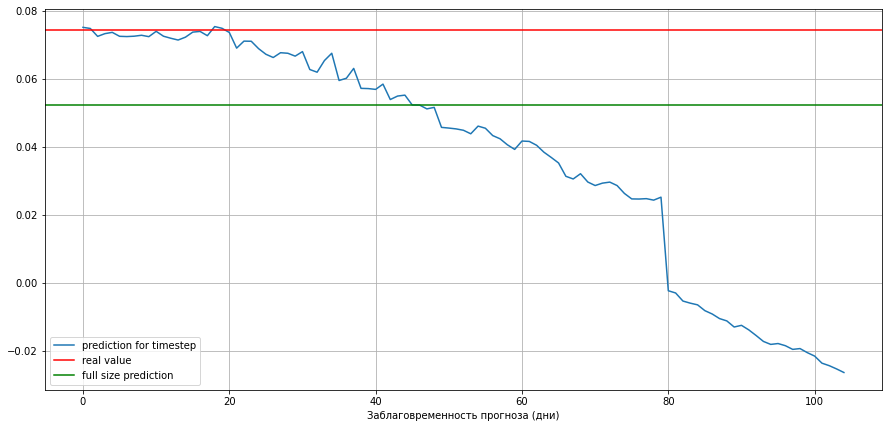

47
Real Value: 0.07361993340896276


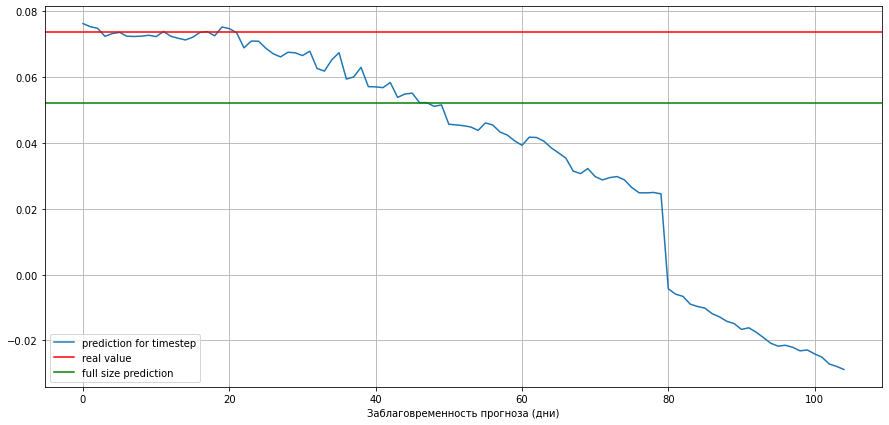

48
Real Value: 0.05194238330980398


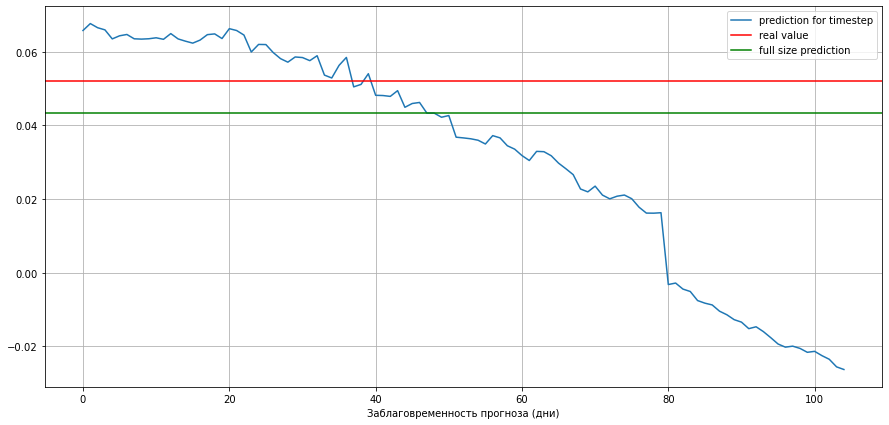

49
Real Value: 0.045815186507339095


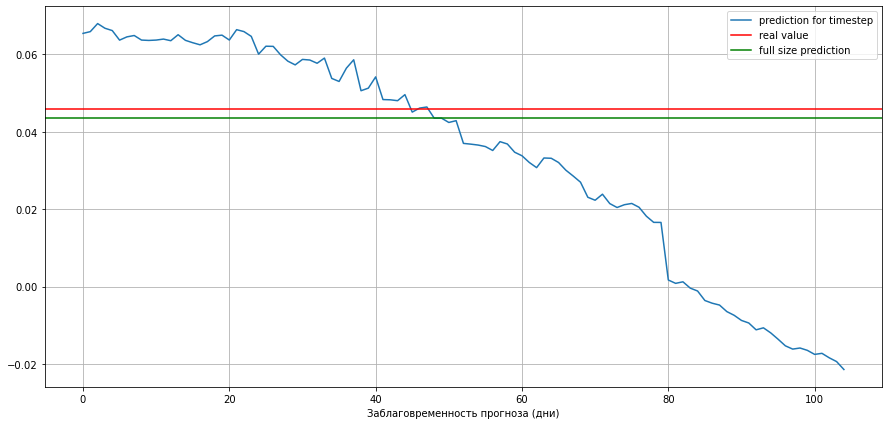

50
Real Value: 0.04076729557022483


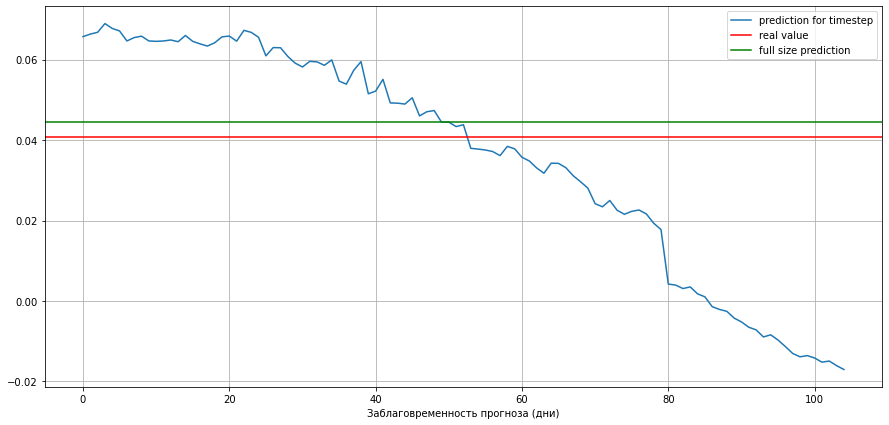

51
Real Value: 0.034438961730195165


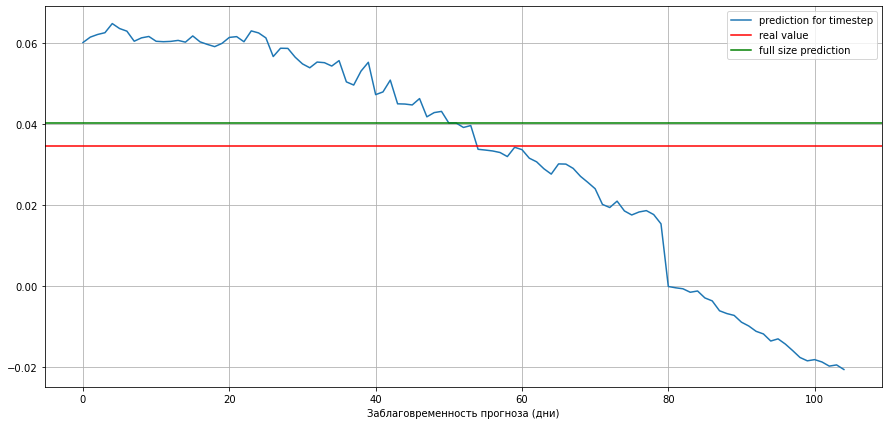

52
Real Value: 0.03050033731136275


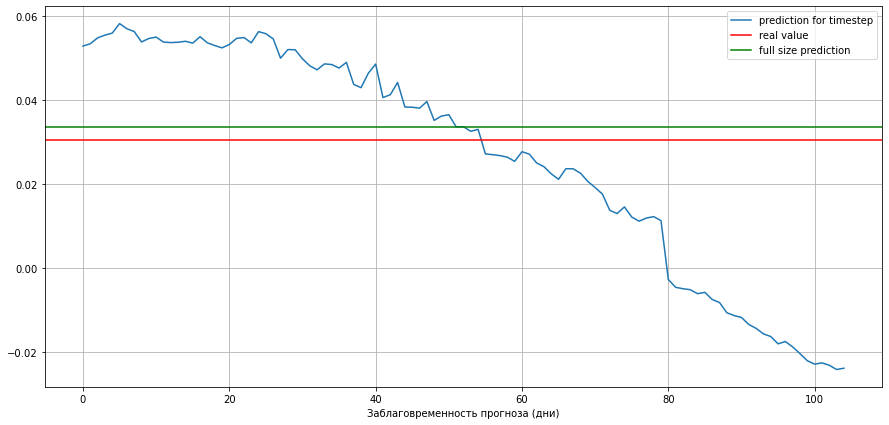

53
Real Value: 0.04723098749403943


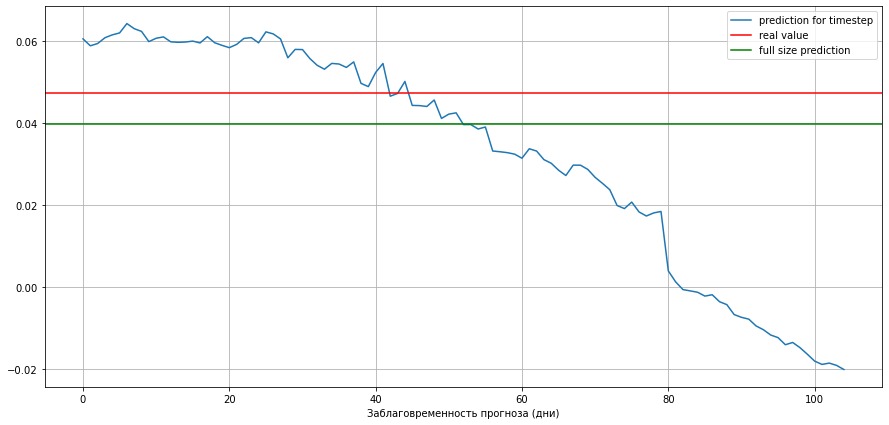

54
Real Value: 0.054519583113531535


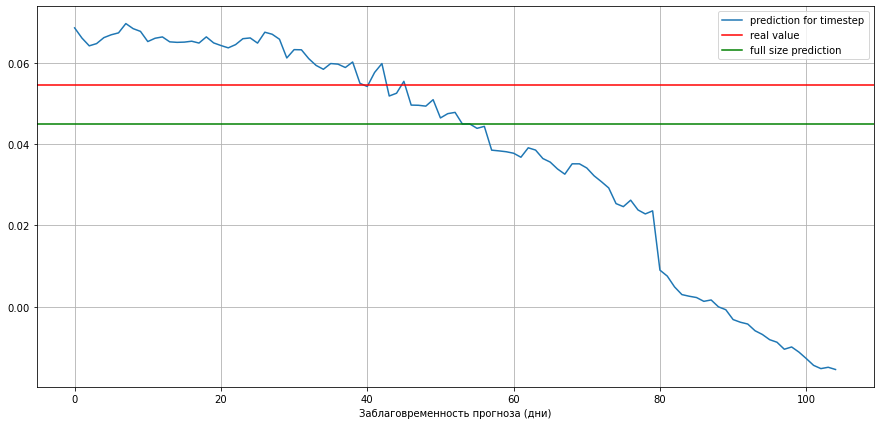

55
Real Value: 0.05026999436258342


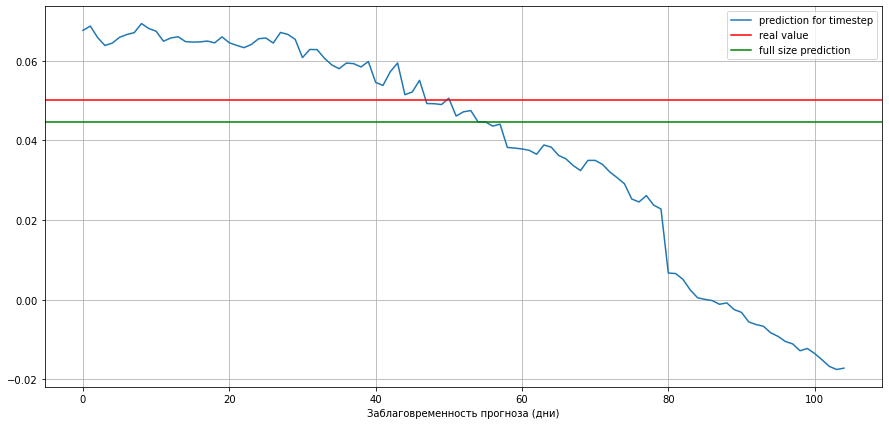

56
Real Value: 0.046937936357884735


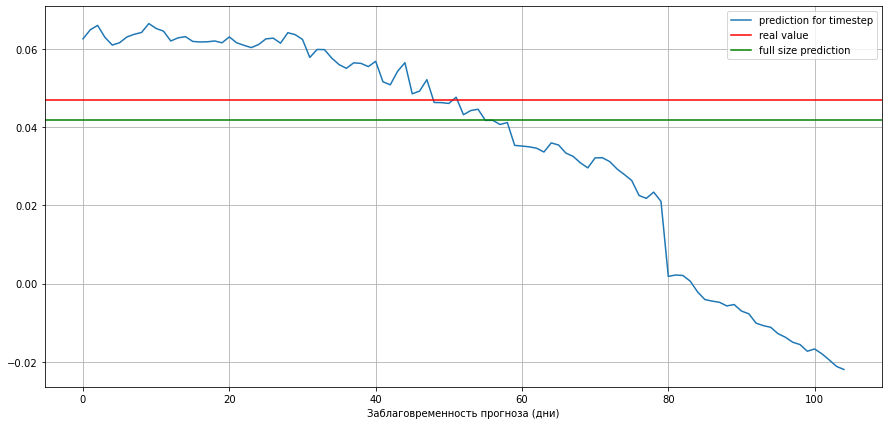

57
Real Value: 0.040575365743057236


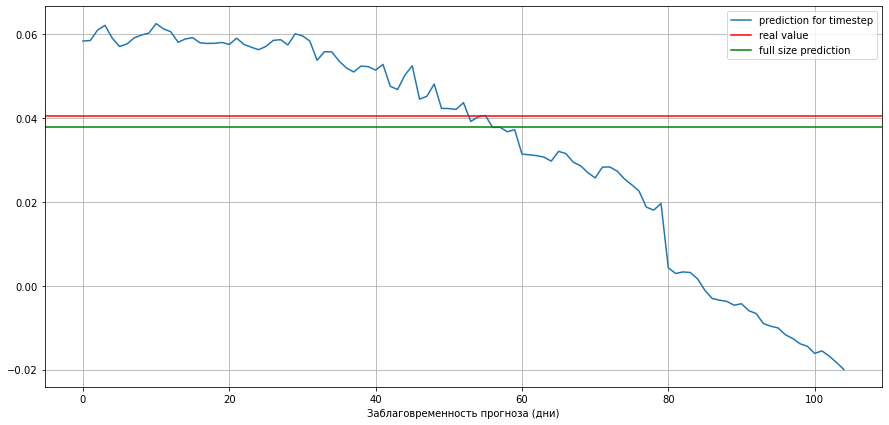

58
Real Value: 0.018216316902358684


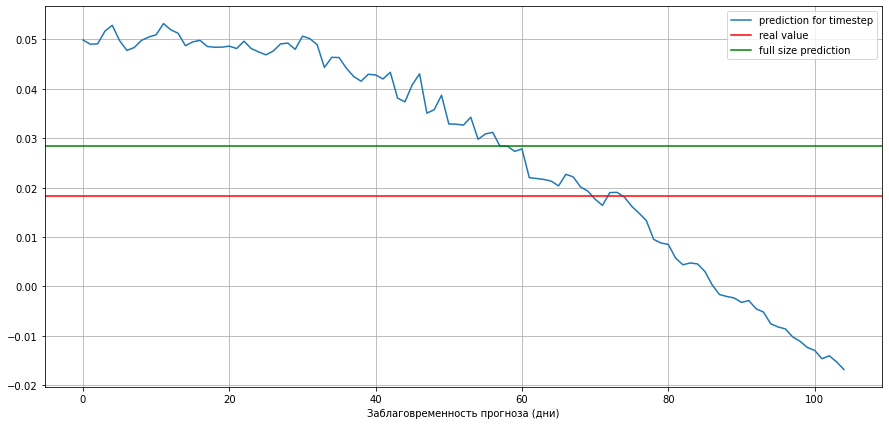

59
Real Value: 0.01818164904238887


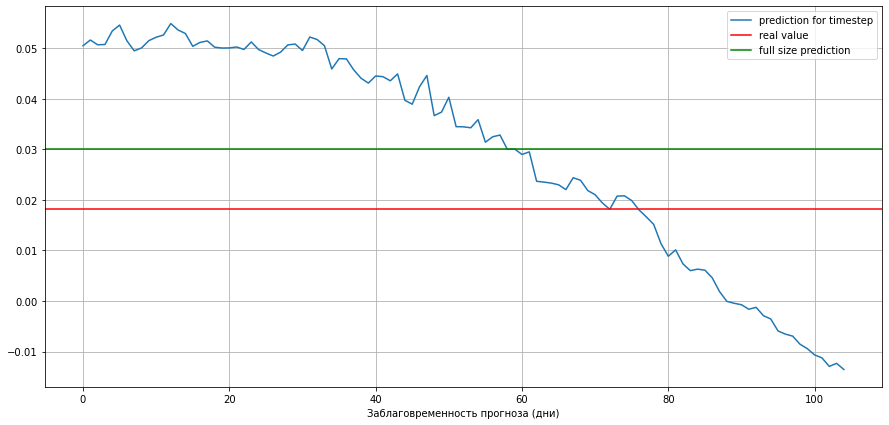

60
Real Value: 0.03150329874418822


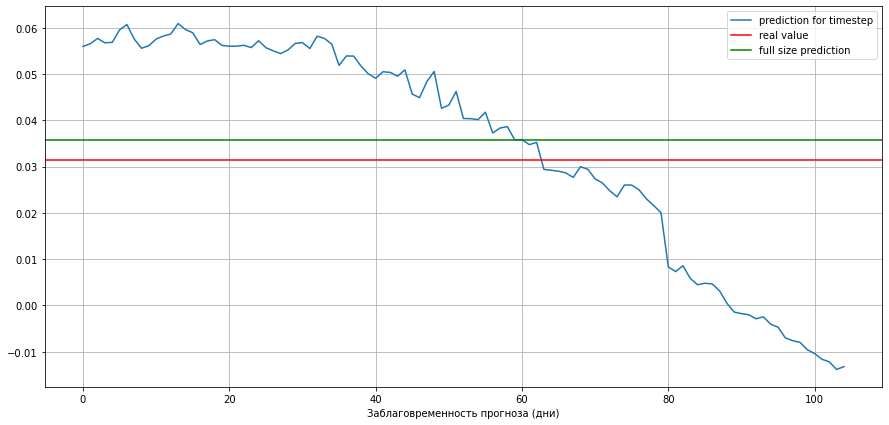

61
Real Value: 0.03779644250722469


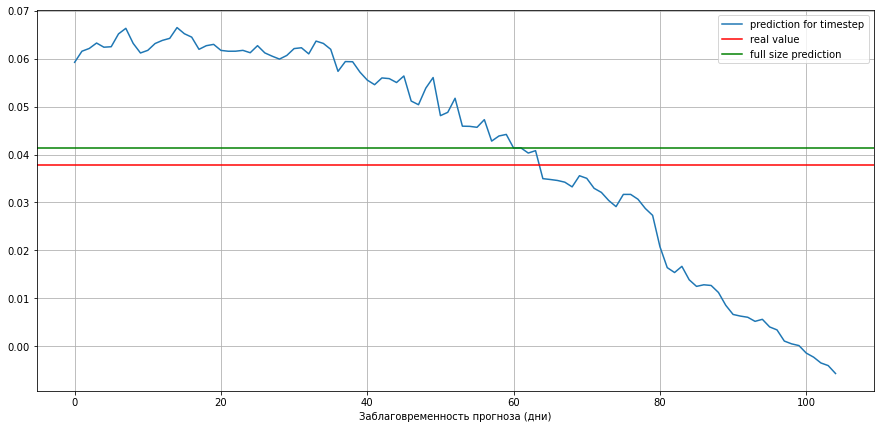

62
Real Value: 0.04017439748518028


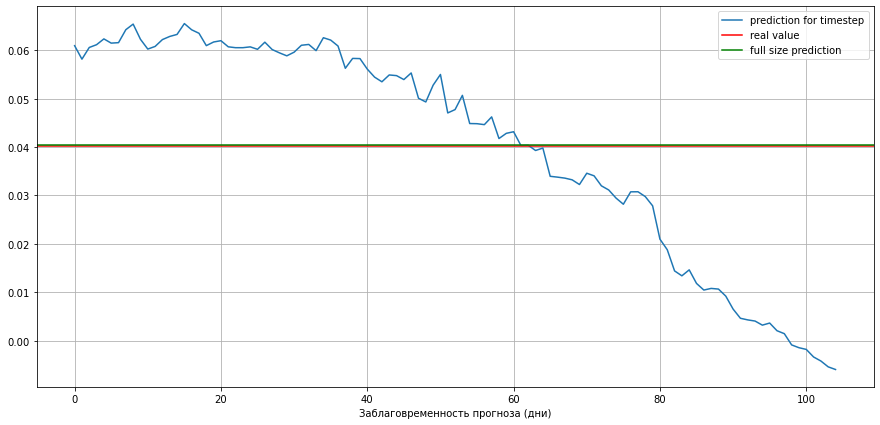

63
Real Value: 0.06515887577522936


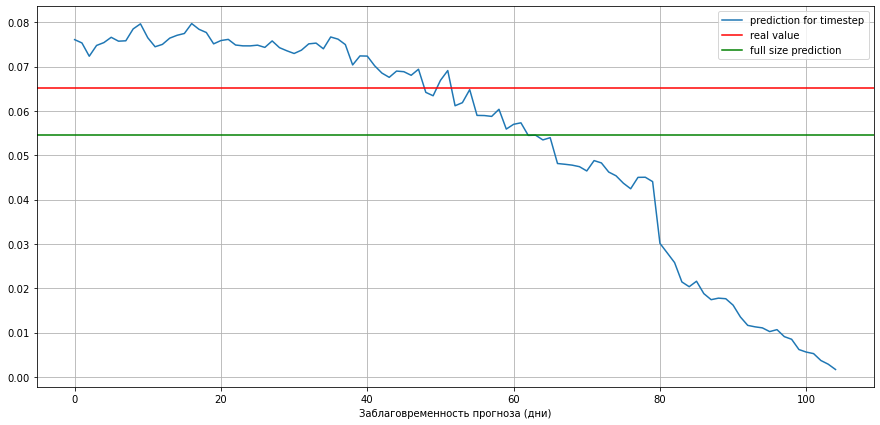

64
Real Value: 0.06135242586092009


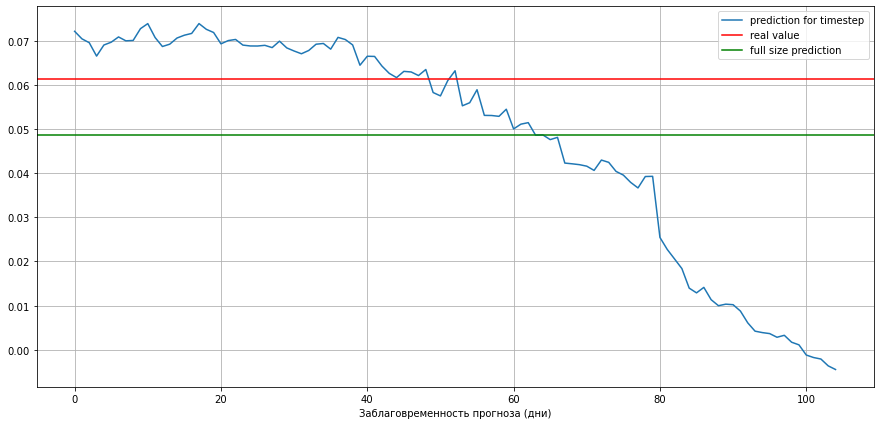

65
Real Value: 0.05723943501706301


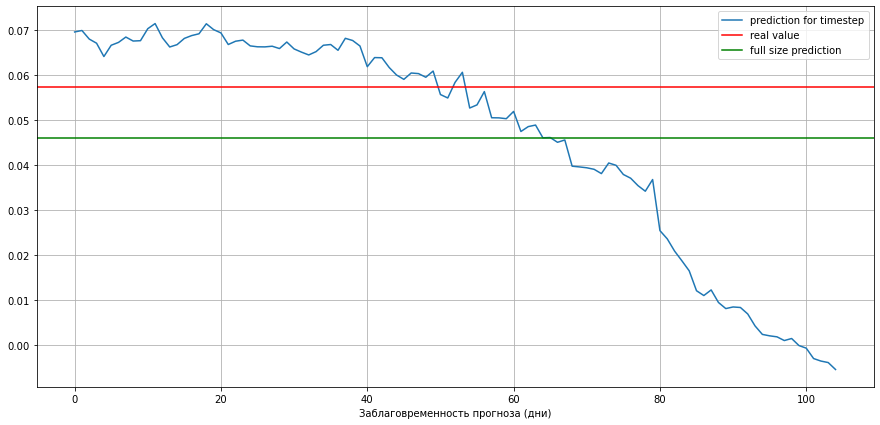

66
Real Value: 0.06883692124959852


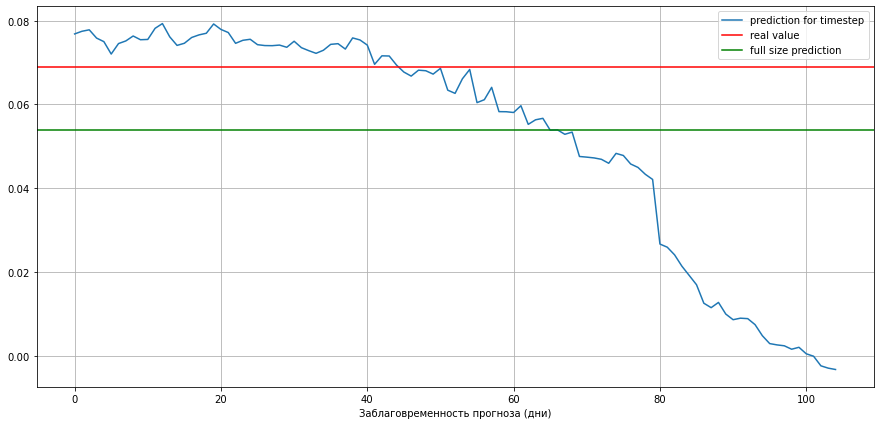

67
Real Value: 0.06587783401291988


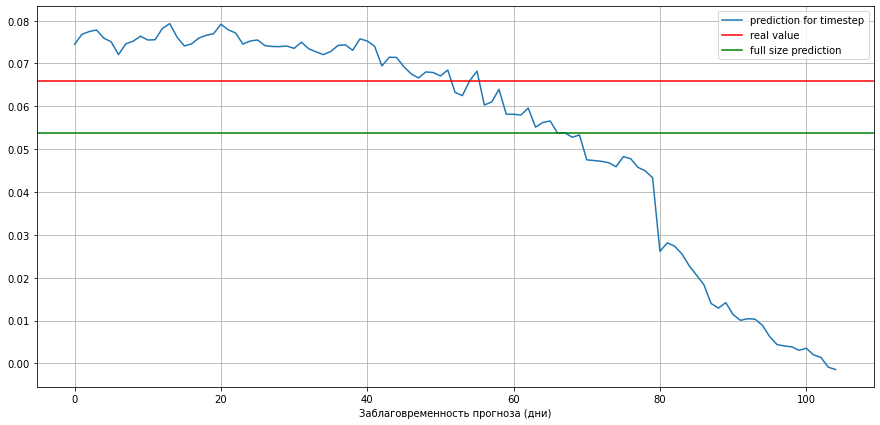

68
Real Value: 0.061702445894460084


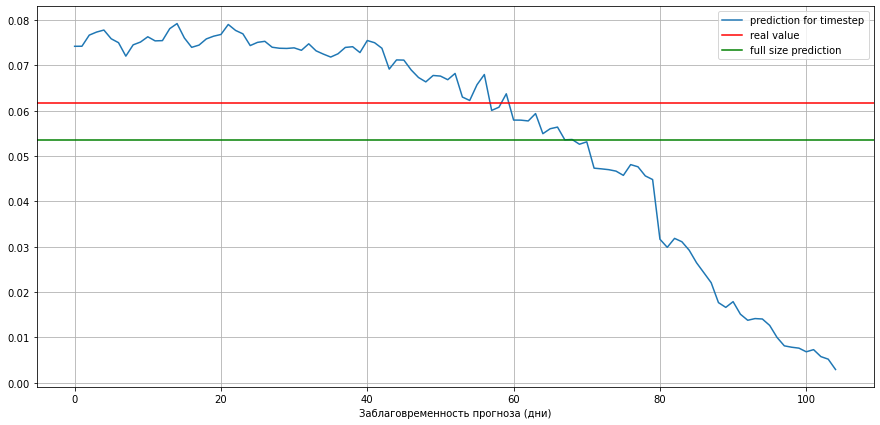

69
Real Value: 0.06190354756367553


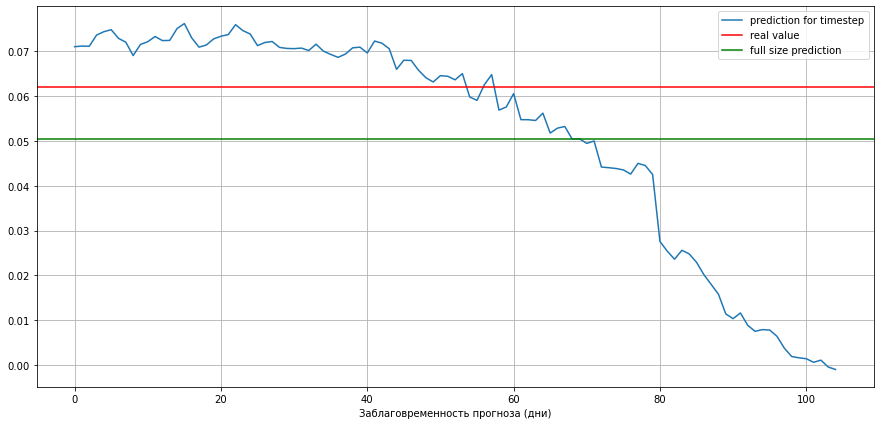

70
Real Value: 0.06034765980548612


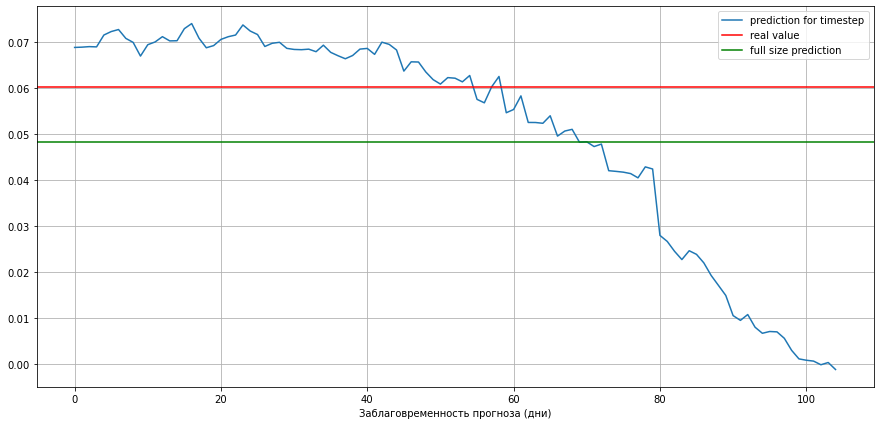

71
Real Value: 0.05803324331073339


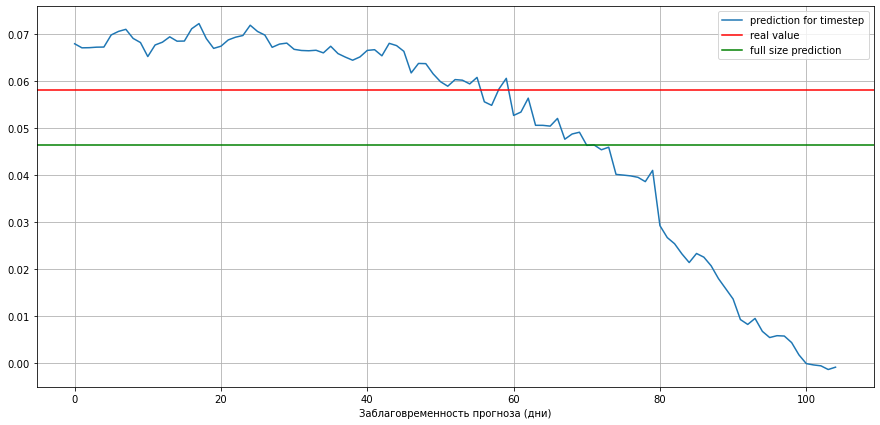

72
Real Value: 0.05850448838821021


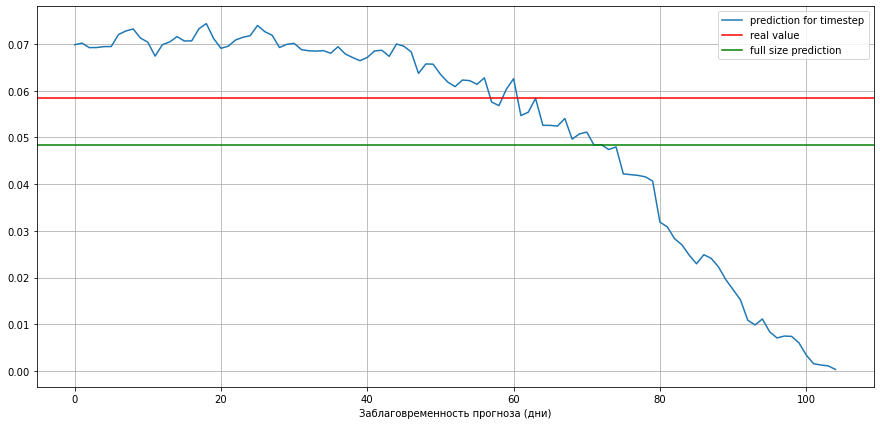

73
Real Value: 0.05500059109576684


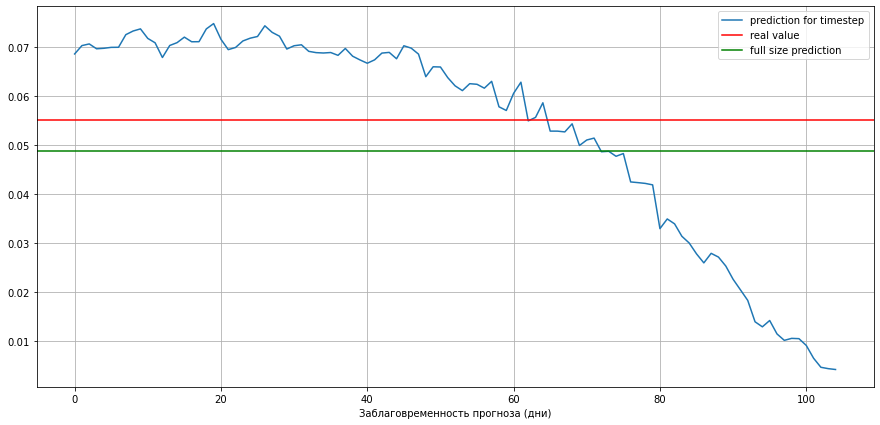

74
Real Value: 0.04457366709217924


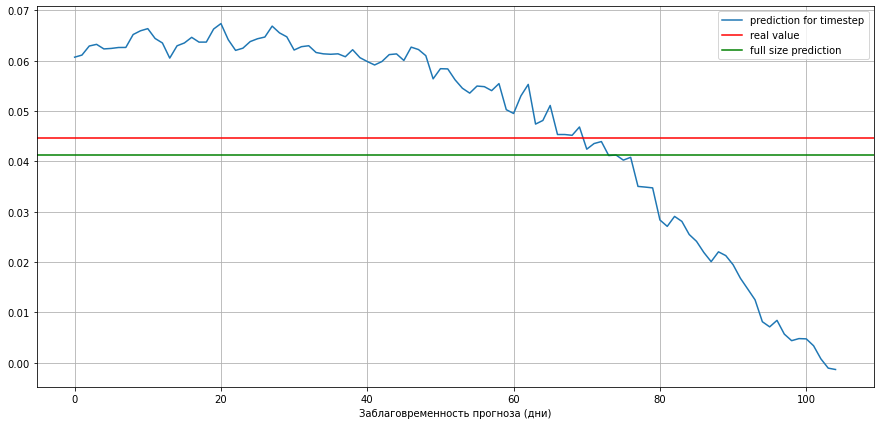

75
Real Value: 0.03398686962689565


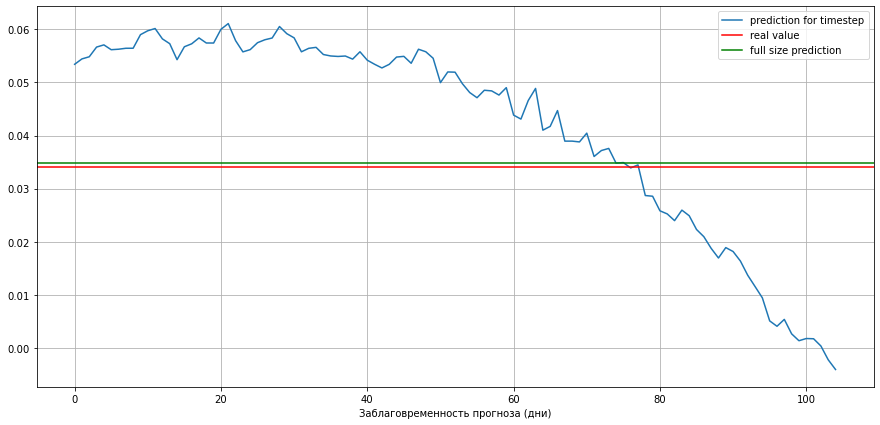

76
Real Value: 0.03924840800367279


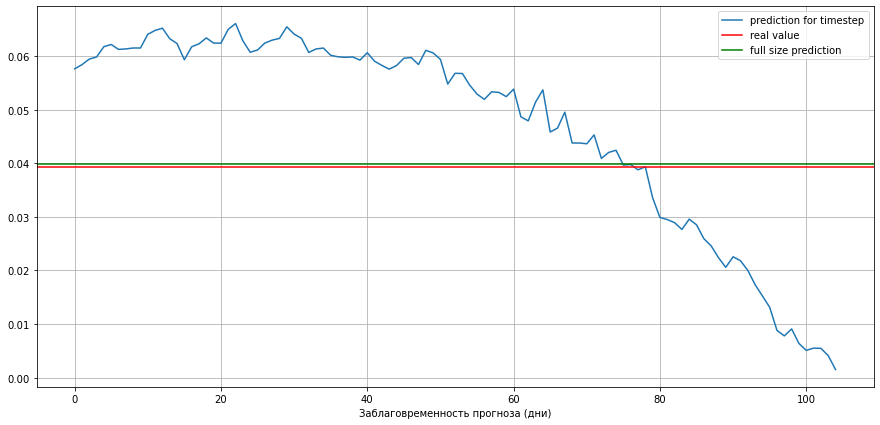

77
Real Value: 0.03147174638031422


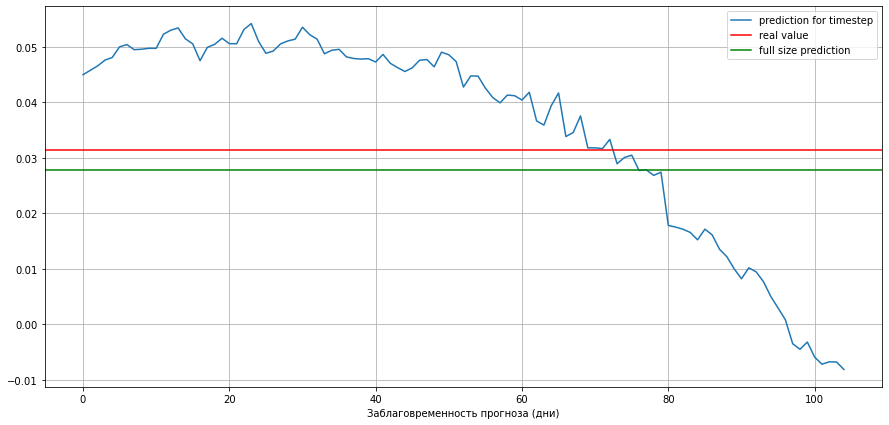

78
Real Value: 0.037338069312992654


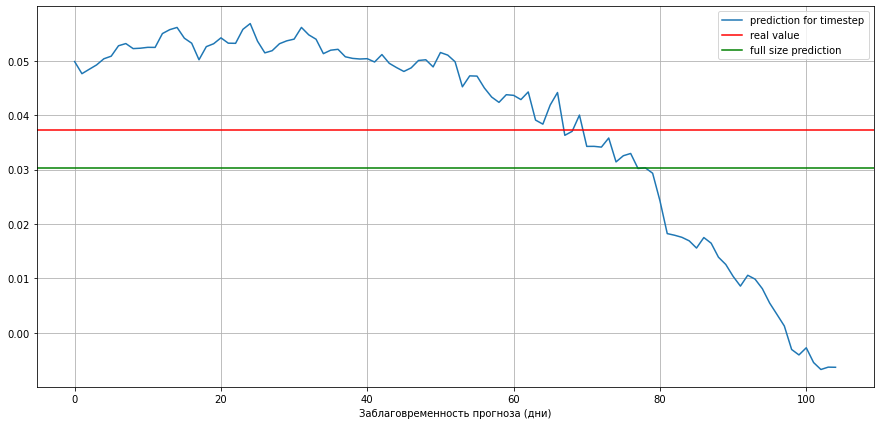

79
Real Value: 0.04147236487578352


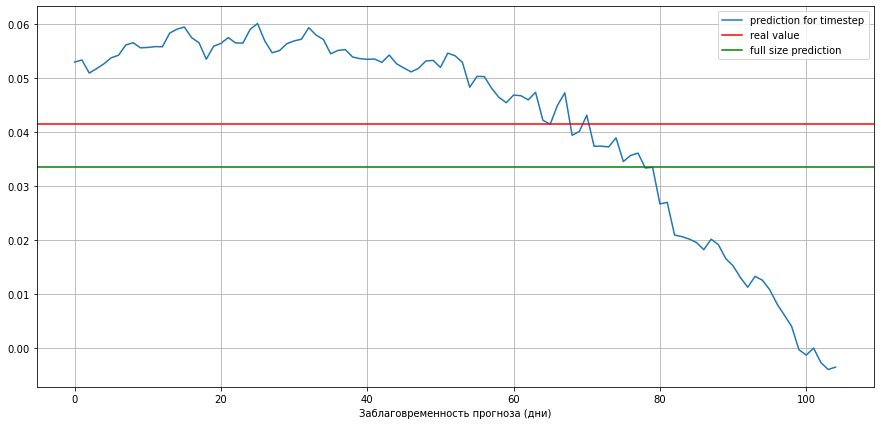

80
Real Value: 0.04022166707787394


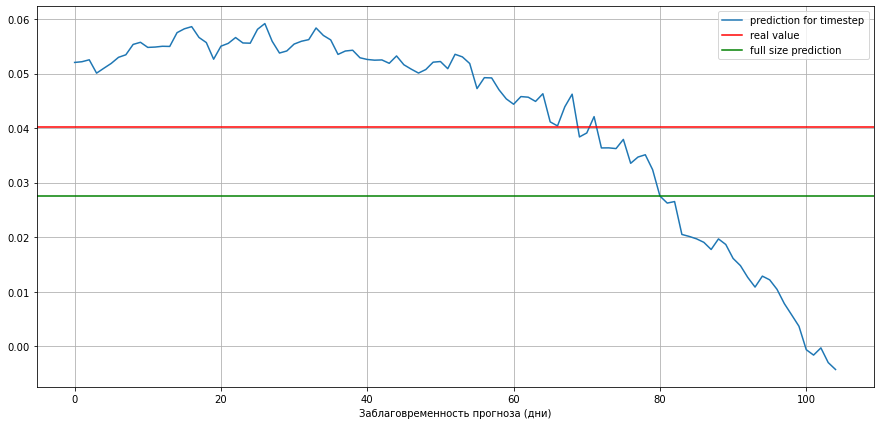

81
Real Value: 0.04140425259326371


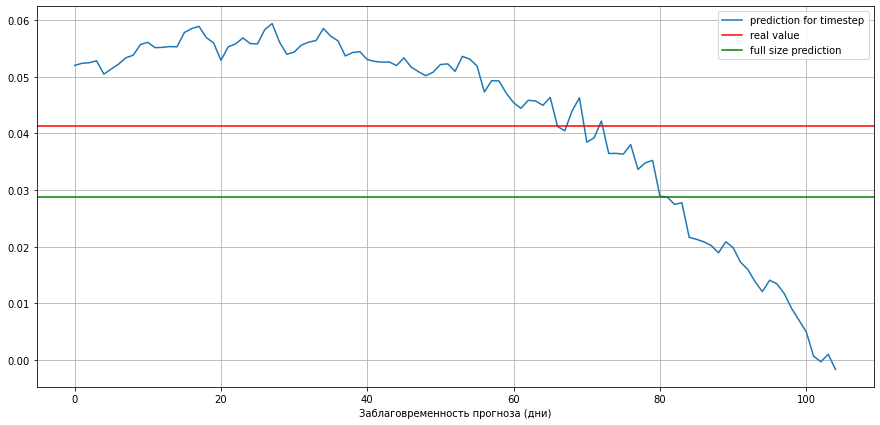

82
Real Value: 0.04528851461509022


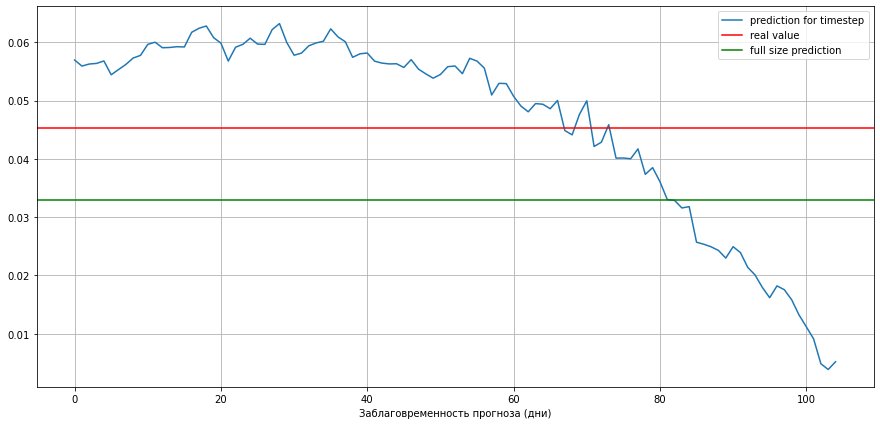

83
Real Value: 0.04586895029436876


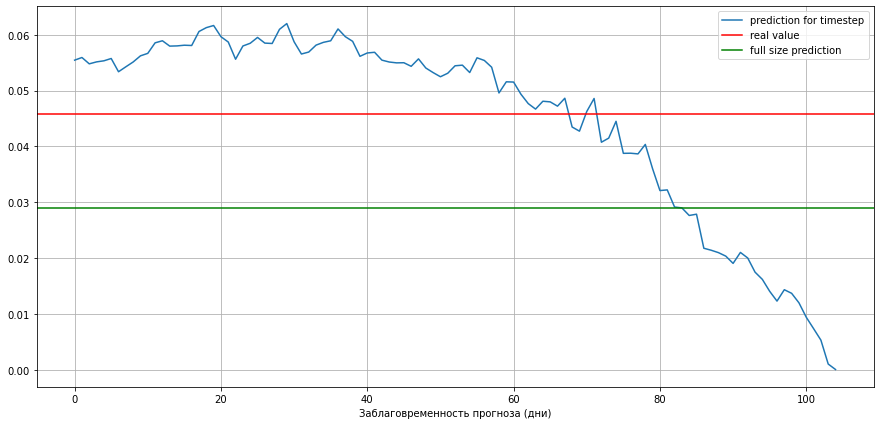

84
Real Value: 0.05899513287768961


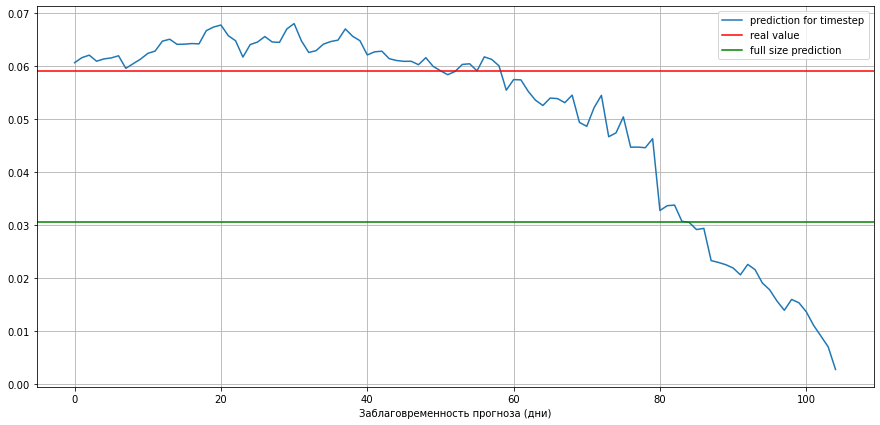

85
Real Value: 0.055667970602228604


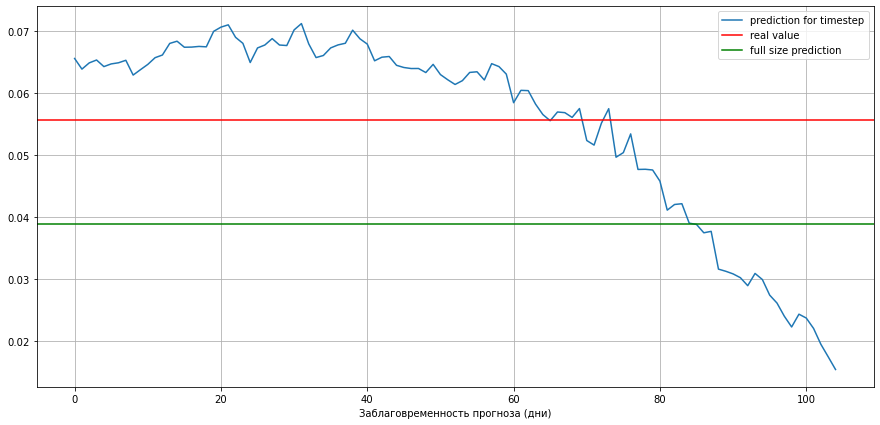

86
Real Value: 0.05619255137960729


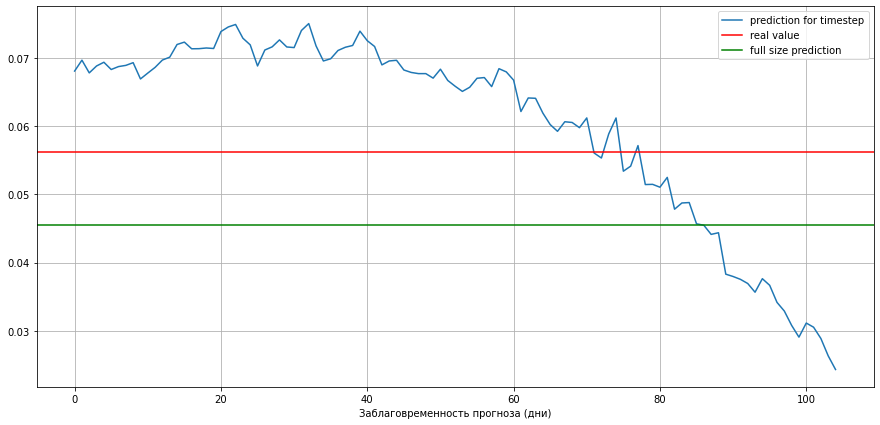

87
Real Value: 0.06363929509324506


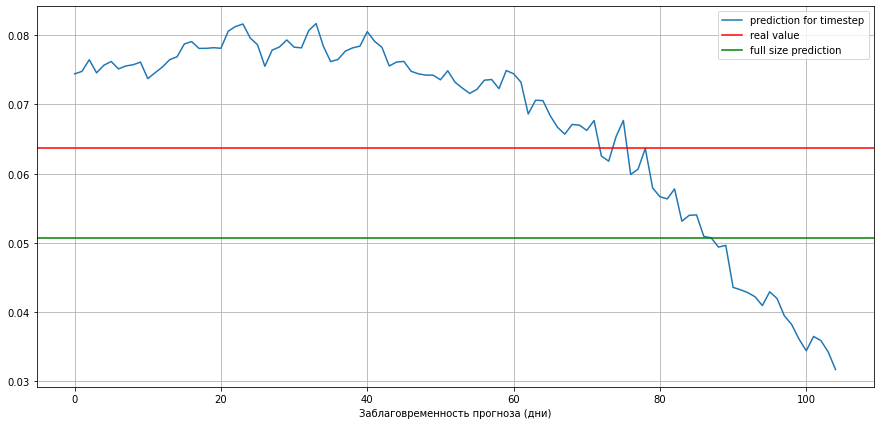

88
Real Value: 0.06789585754722136


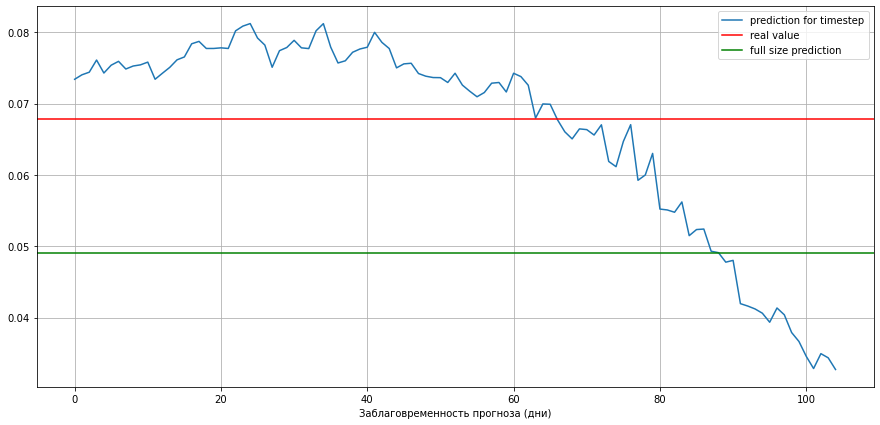

89
Real Value: 0.0456674851356205


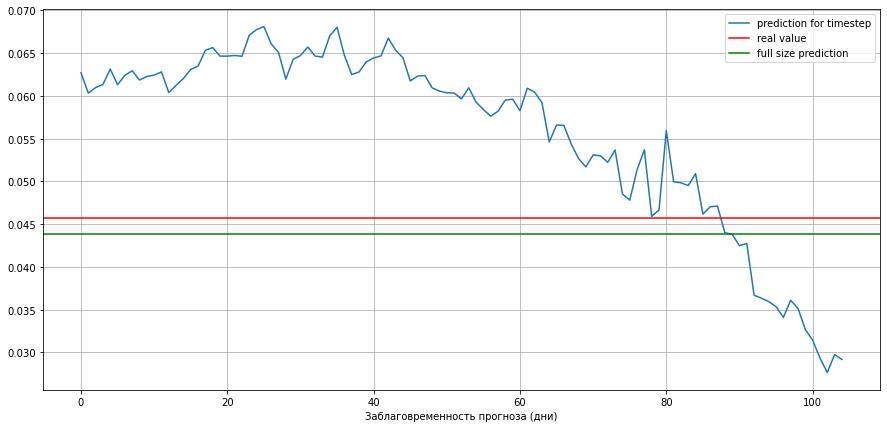

90
Real Value: 0.036719063137898765


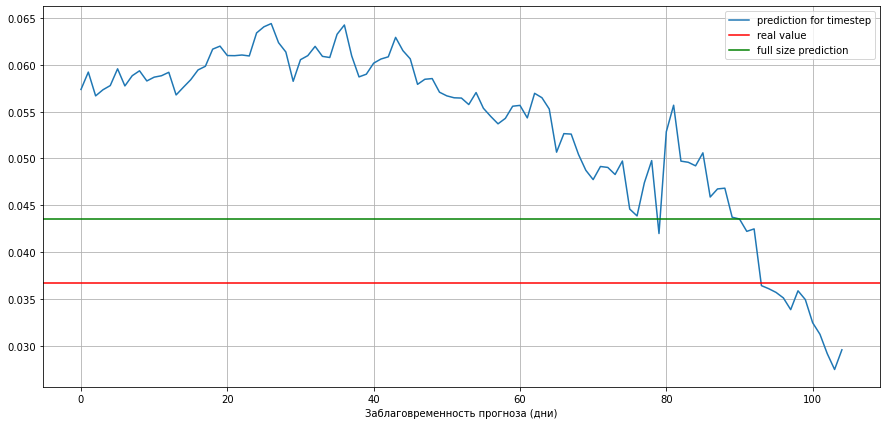

91
Real Value: 0.06627361952920546


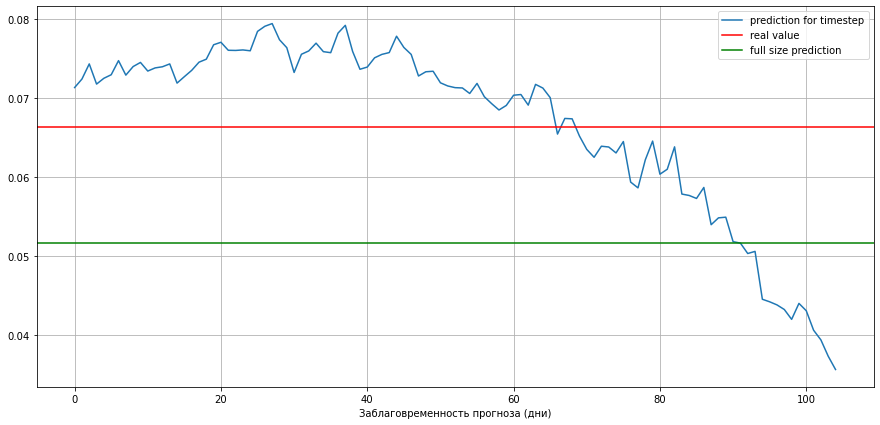

92
Real Value: 0.059821832807222974


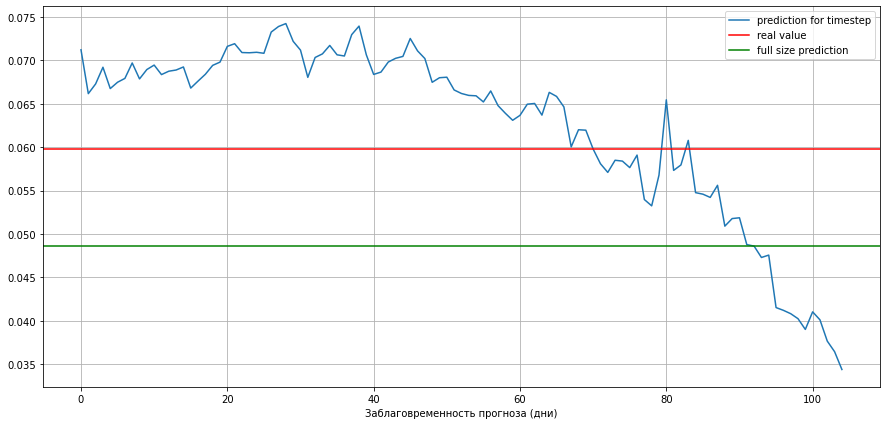

93
Real Value: 0.053269169553625824


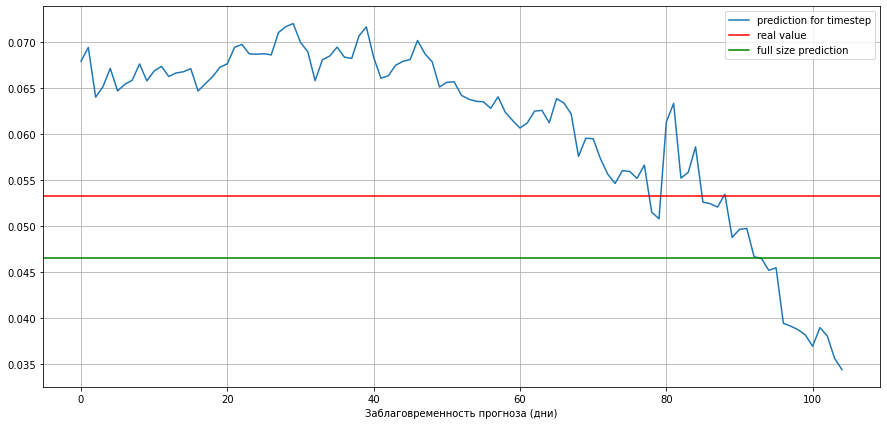

94
Real Value: 0.06808245371734334


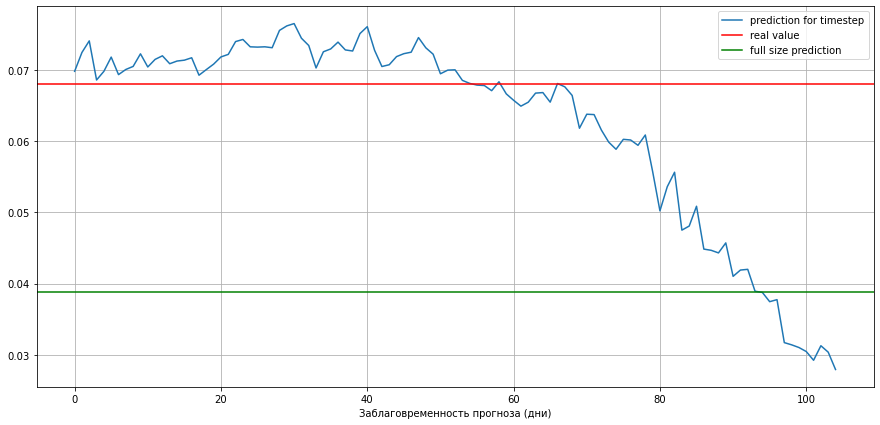

95
Real Value: 0.09032441830496947


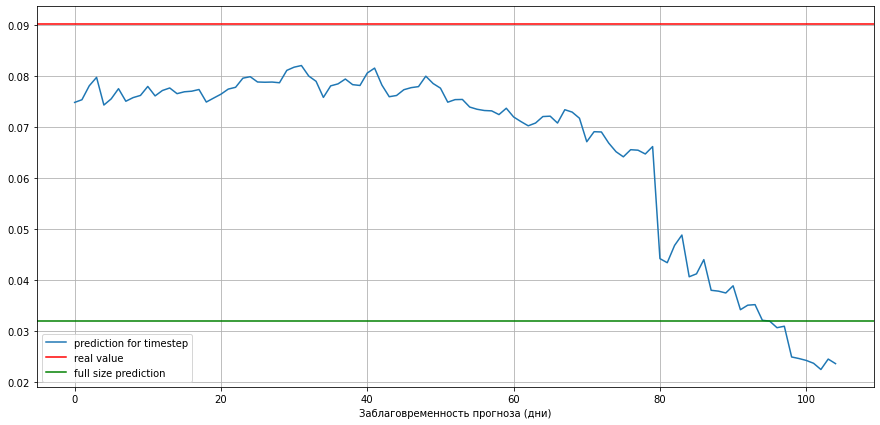

96
Real Value: 0.08055016308450982


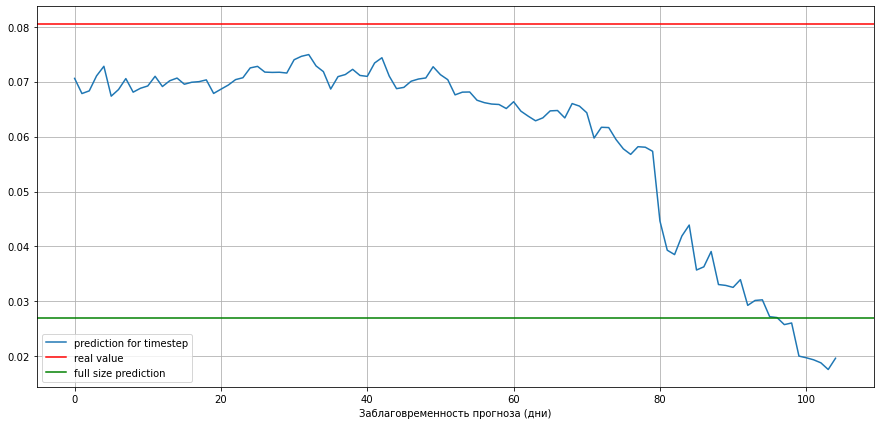

97
Real Value: 0.06959438554598796


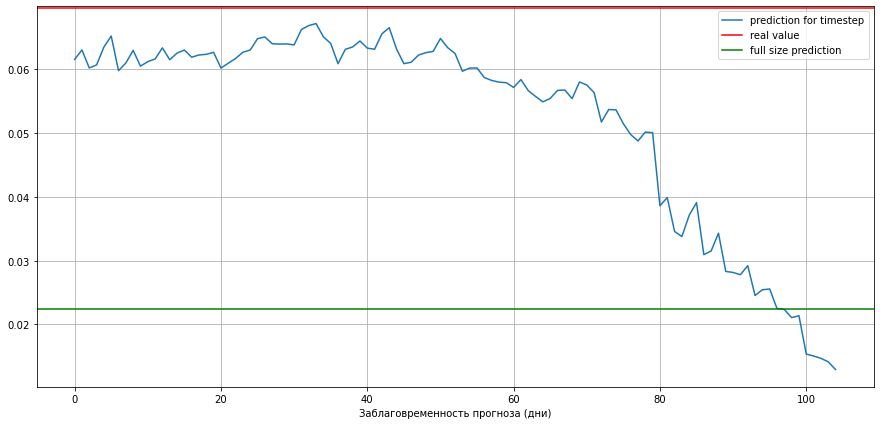

98
Real Value: 0.057117565515561484


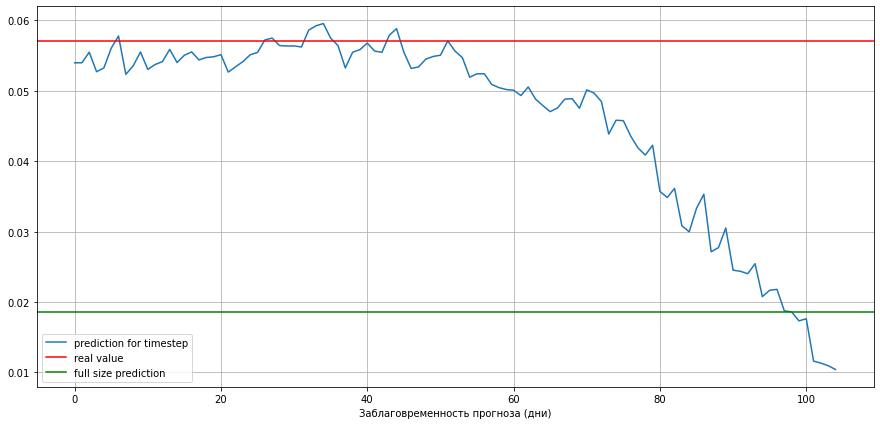

99
Real Value: 0.06090446880832349


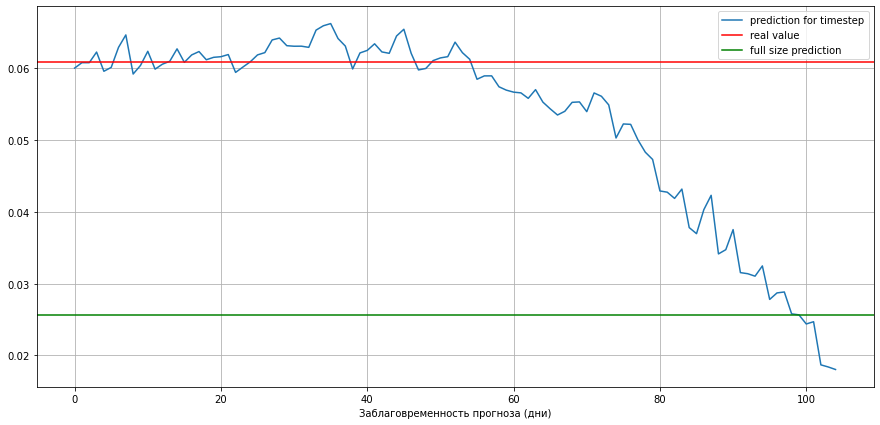

100
Real Value: 0.053846502162269036


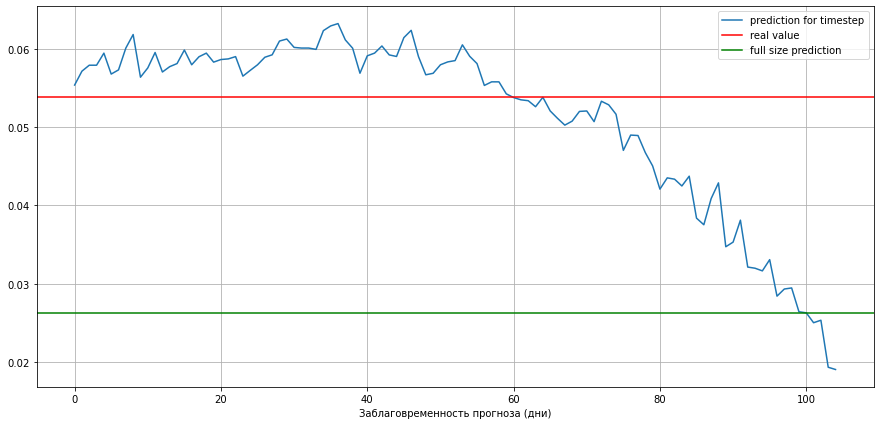

101
Real Value: 0.056428667268650035


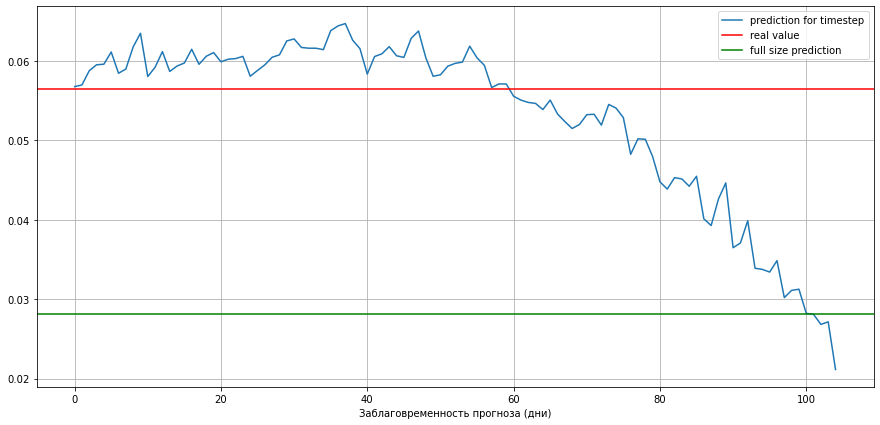

102
Real Value: 0.05962709148930338


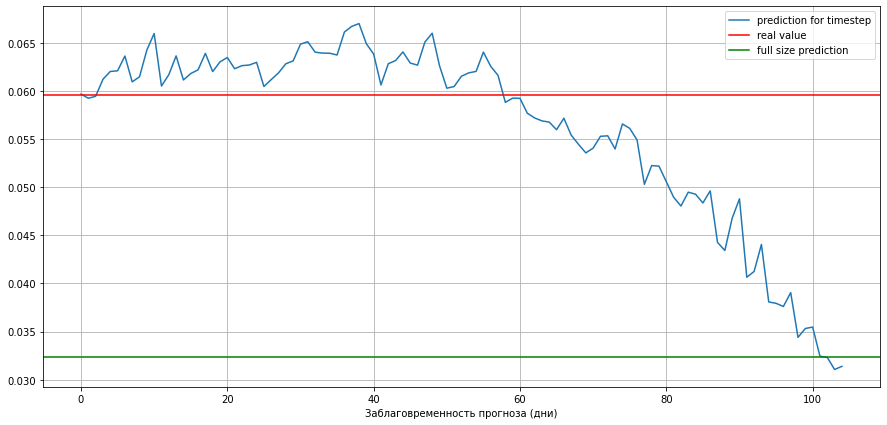

103
Real Value: 0.06612114648623313


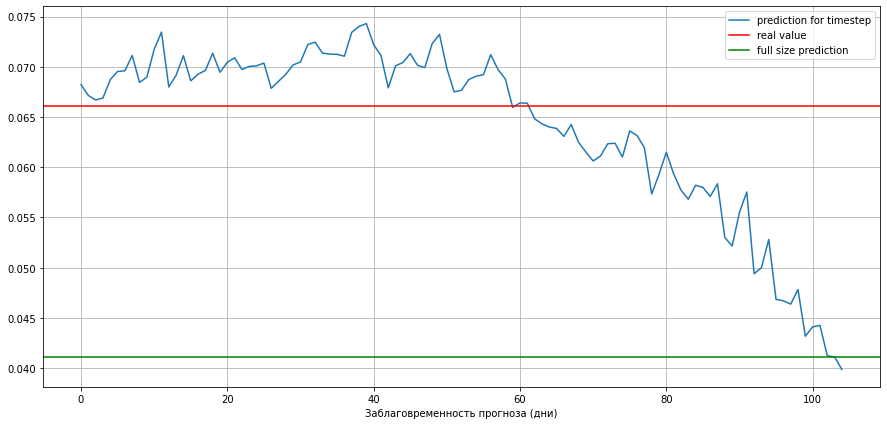

104
Real Value: 0.06376193070641653


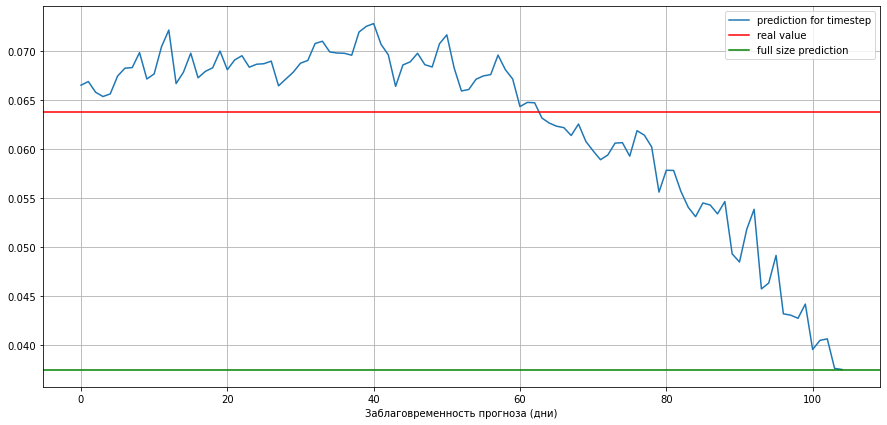

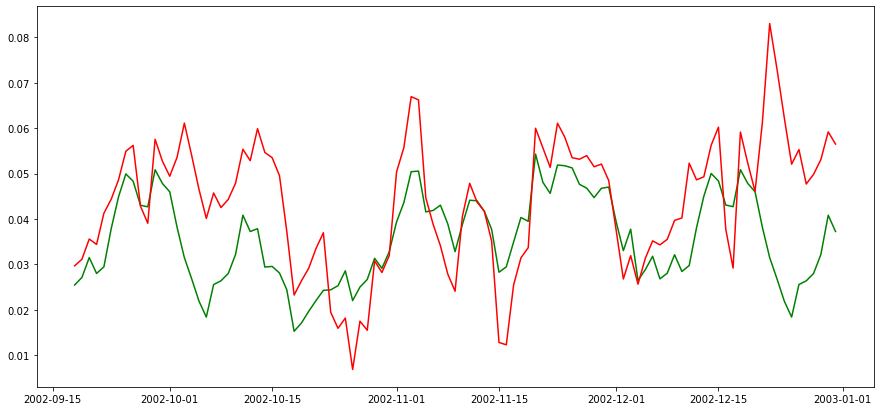

0
Real Value: 0.029647105652246132


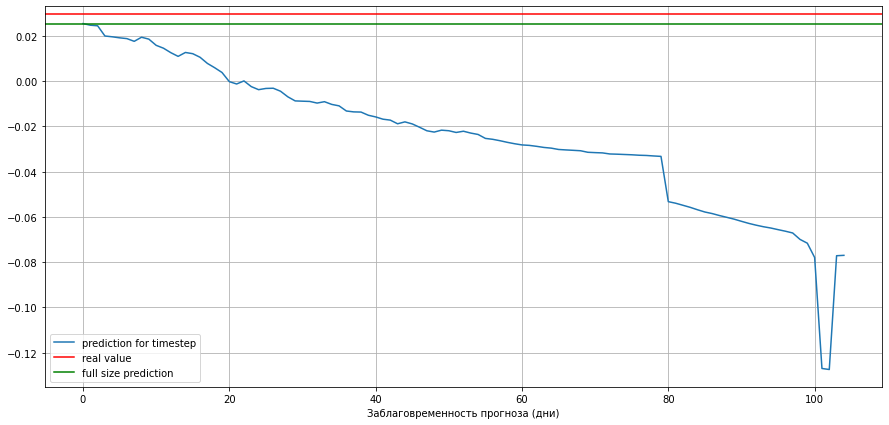

1
Real Value: 0.031112683136753867


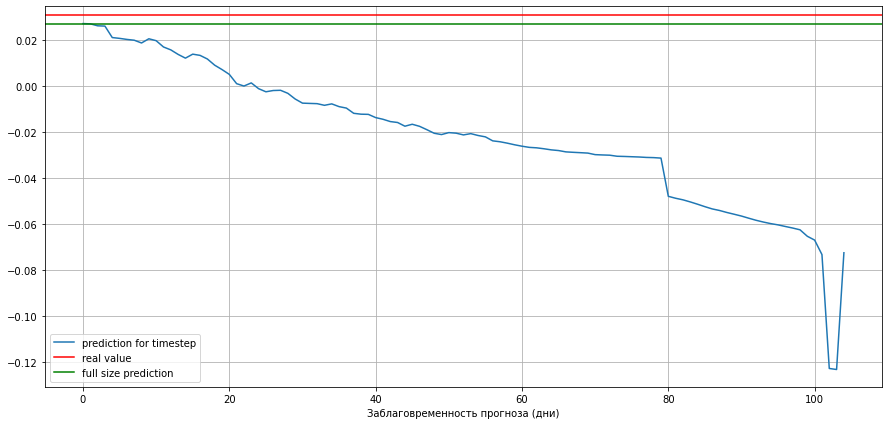

2
Real Value: 0.035560697836477514


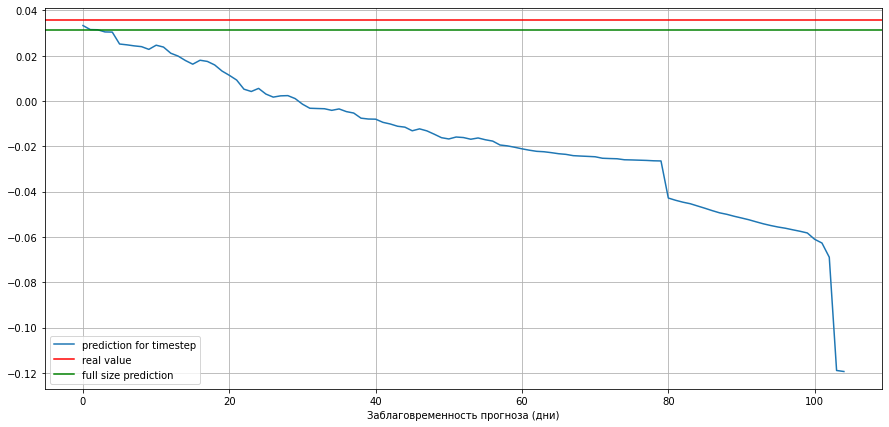

3
Real Value: 0.03436992441027507


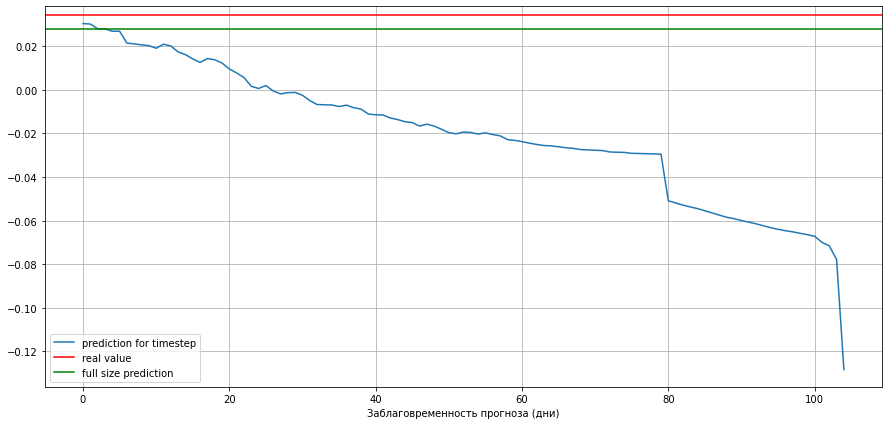

4
Real Value: 0.04124459477365944


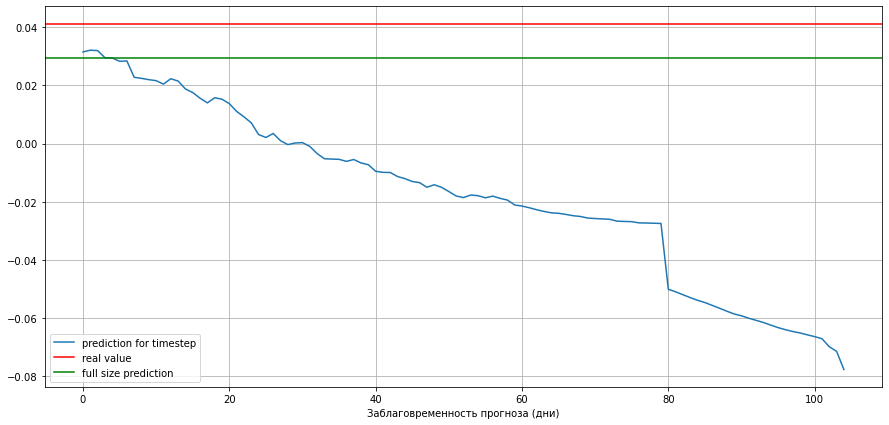

5
Real Value: 0.04433237931199947


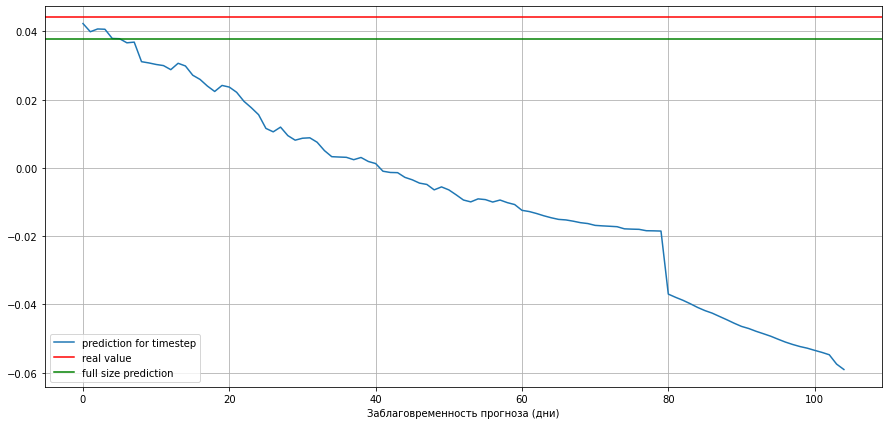

6
Real Value: 0.048603146449532966


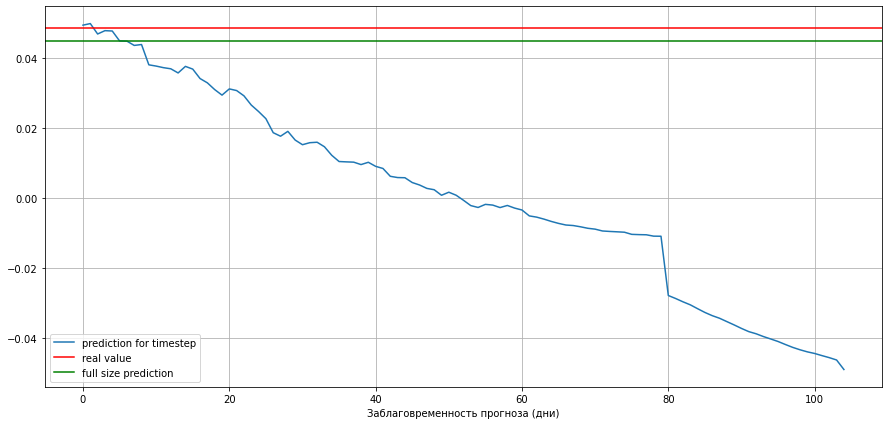

7
Real Value: 0.054899387279035476


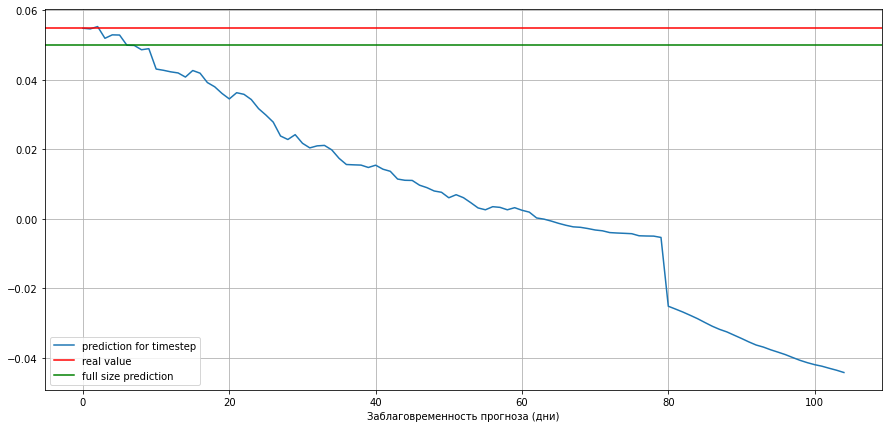

8
Real Value: 0.05619615797573646


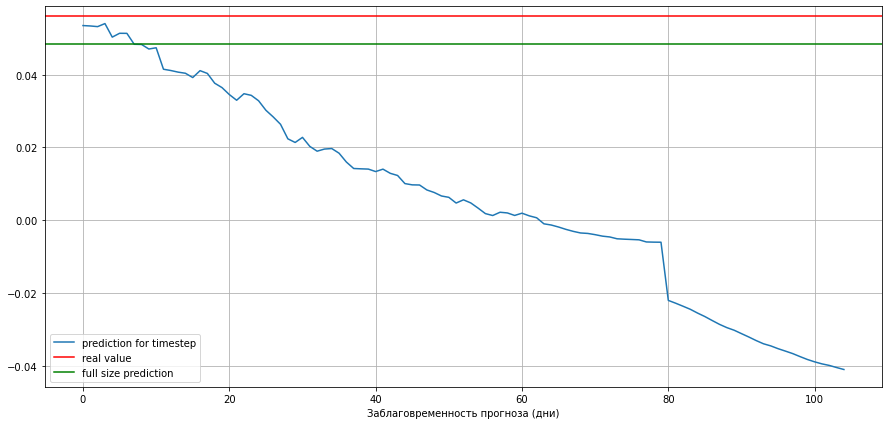

9
Real Value: 0.042800796599924085


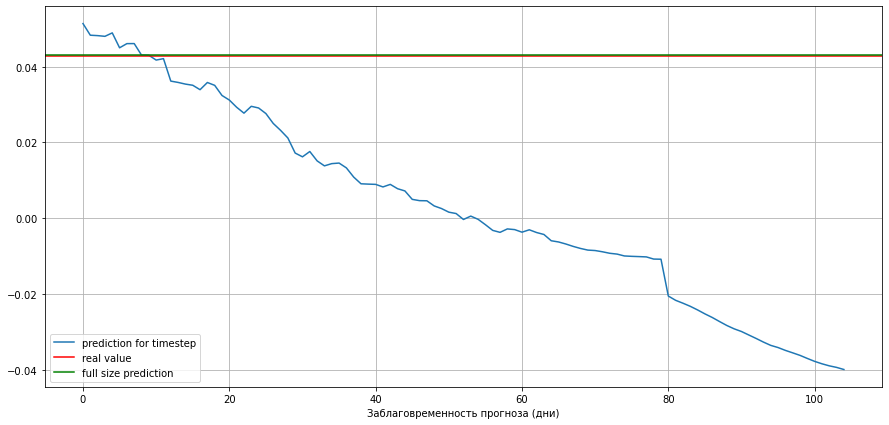

10
Real Value: 0.039033880618818385


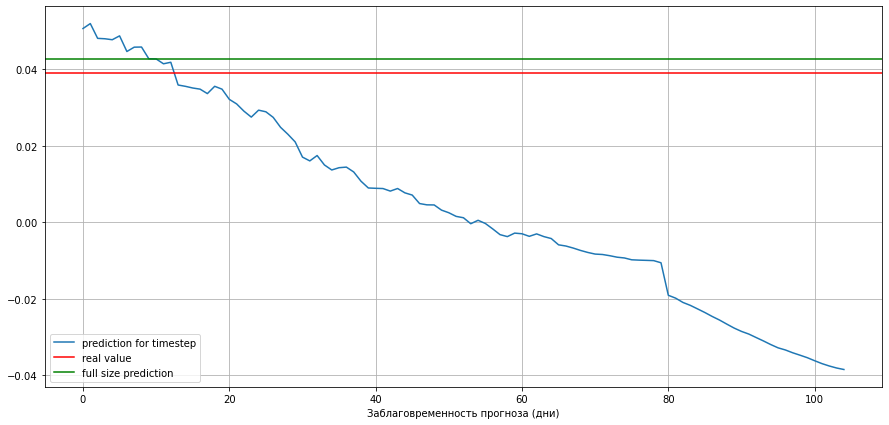

11
Real Value: 0.05753852856062803


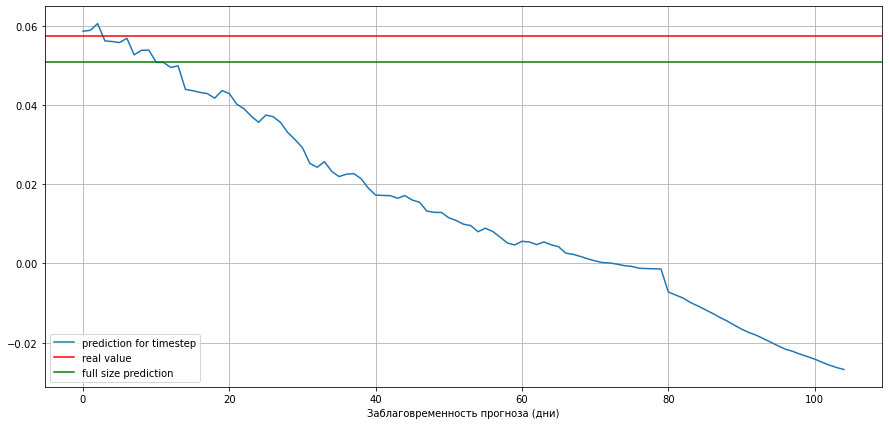

12
Real Value: 0.05271585646572971


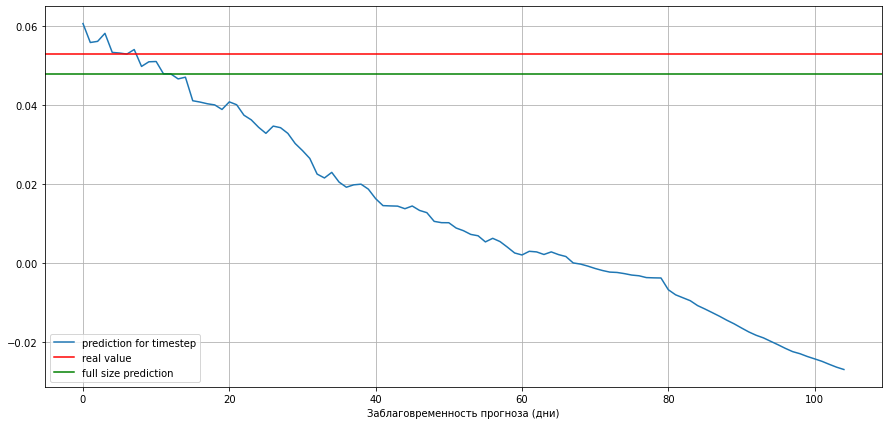

13
Real Value: 0.049395849091047


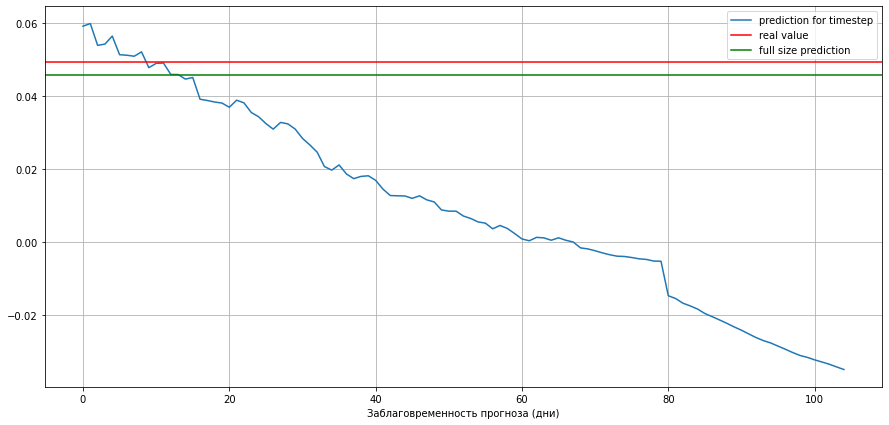

14
Real Value: 0.05356339007159195


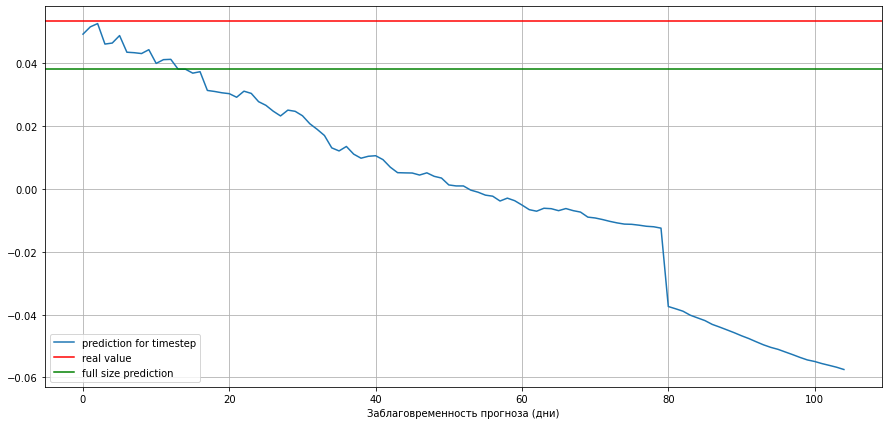

15
Real Value: 0.06110268489823507


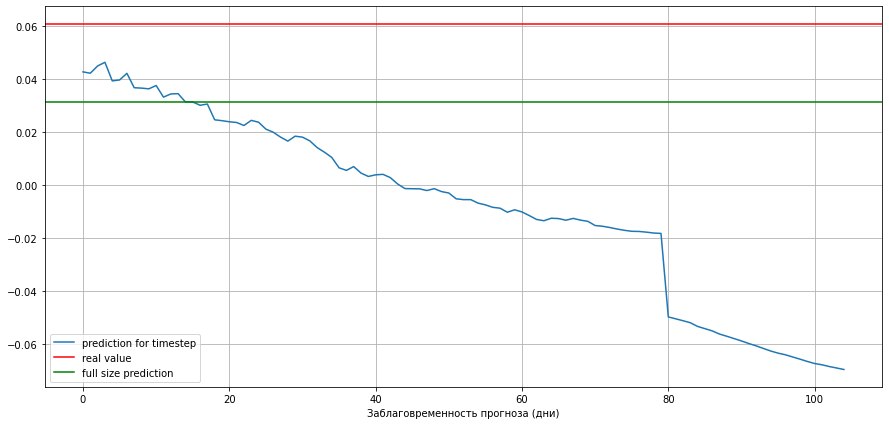

16
Real Value: 0.05396331429347851


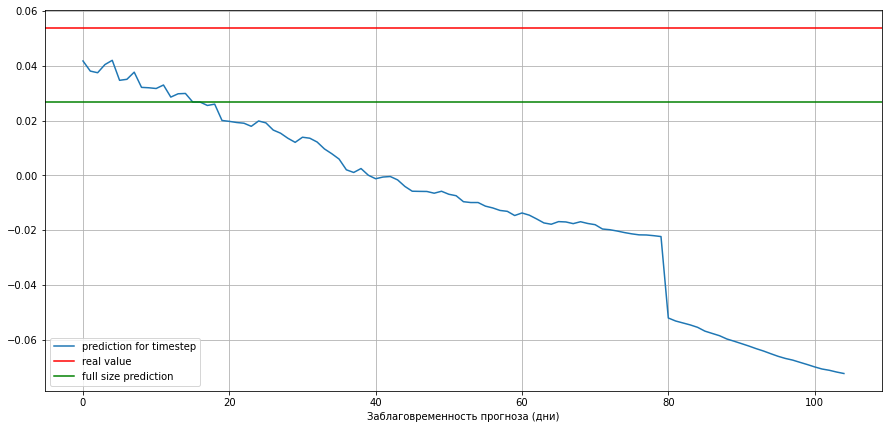

17
Real Value: 0.04649881064179712


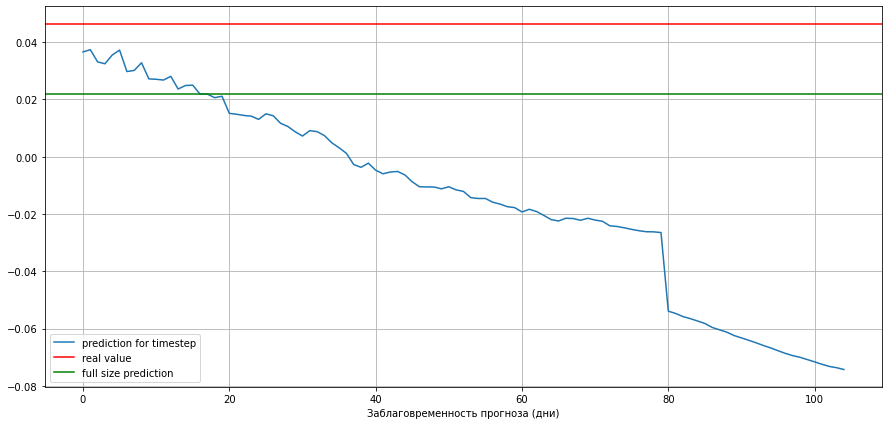

18
Real Value: 0.040099030585256795


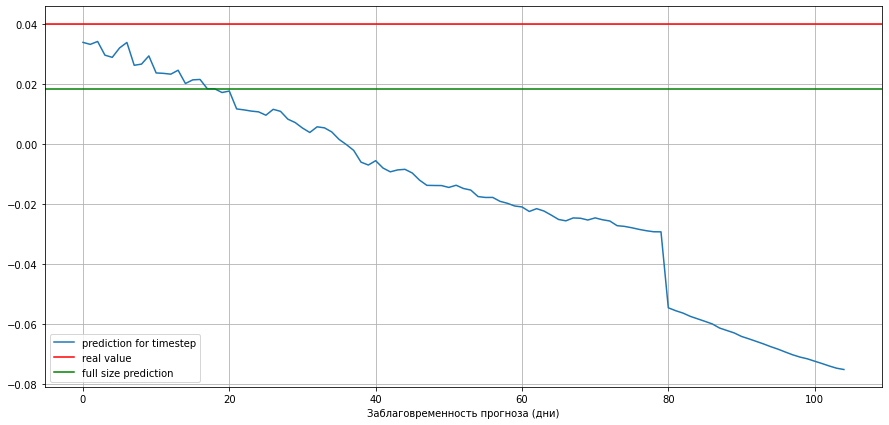

19
Real Value: 0.045713370491405926


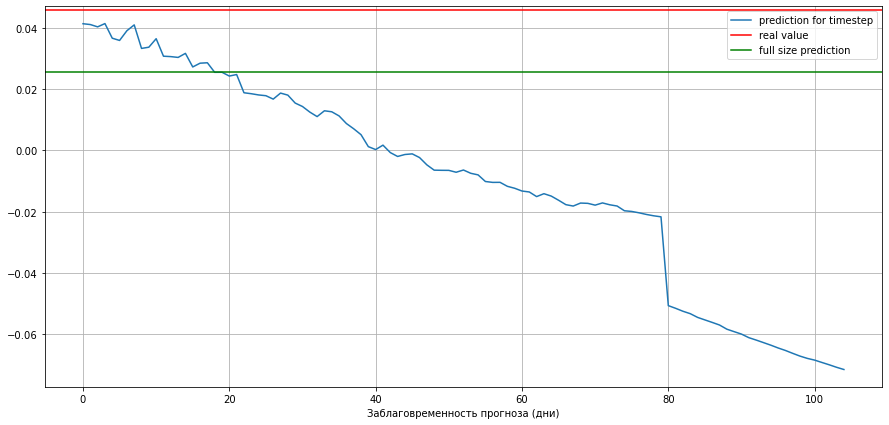

20
Real Value: 0.04249970356172294


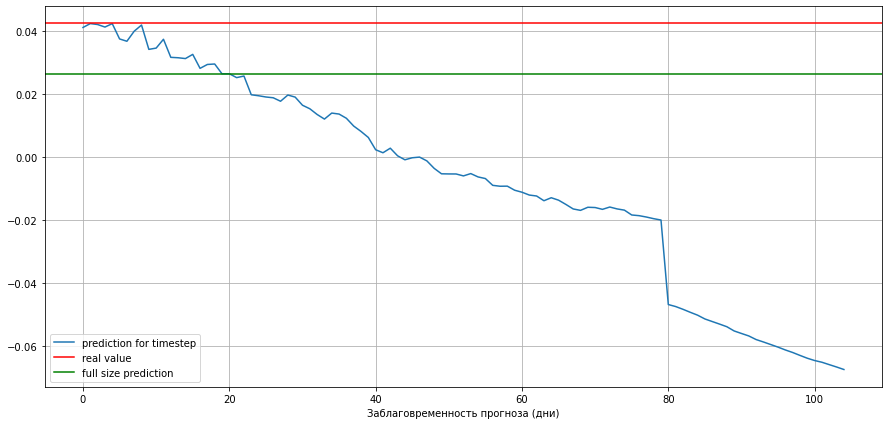

21
Real Value: 0.04429117417832391


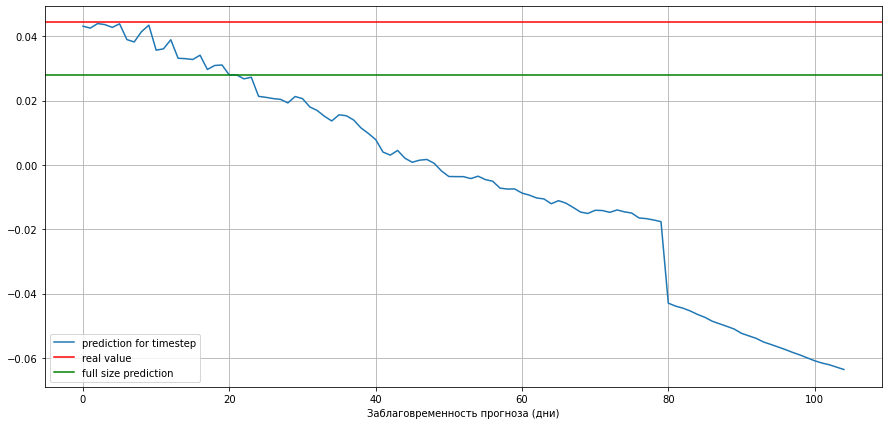

22
Real Value: 0.047888819383578564


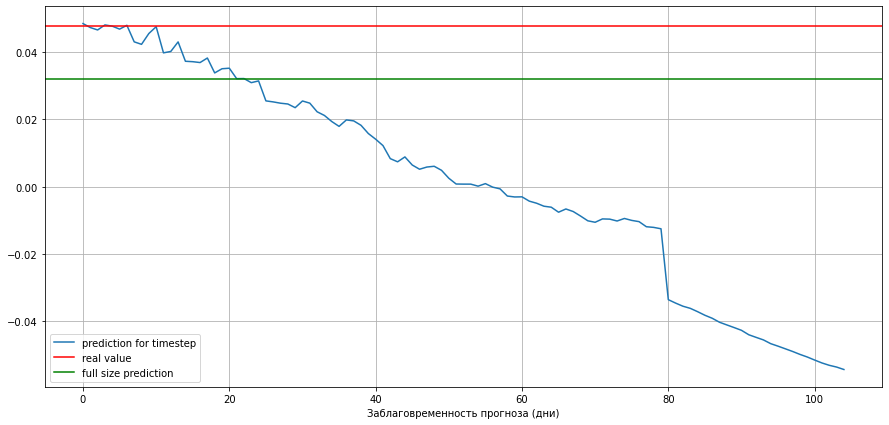

23
Real Value: 0.05534898858225334


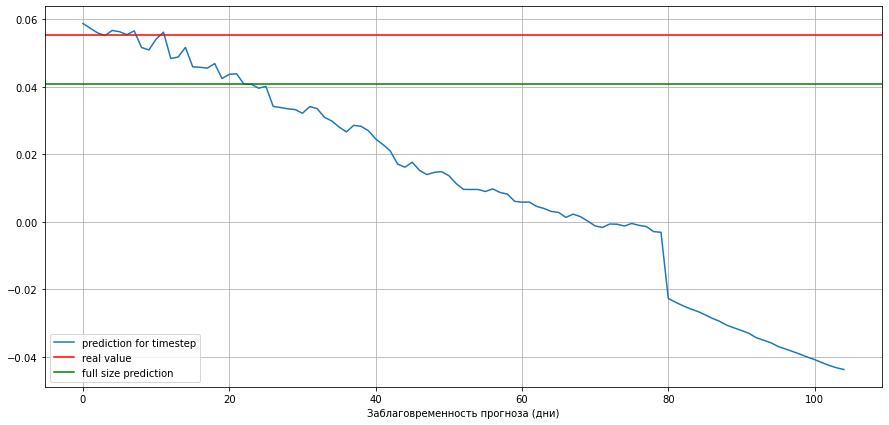

24
Real Value: 0.052828413553460324


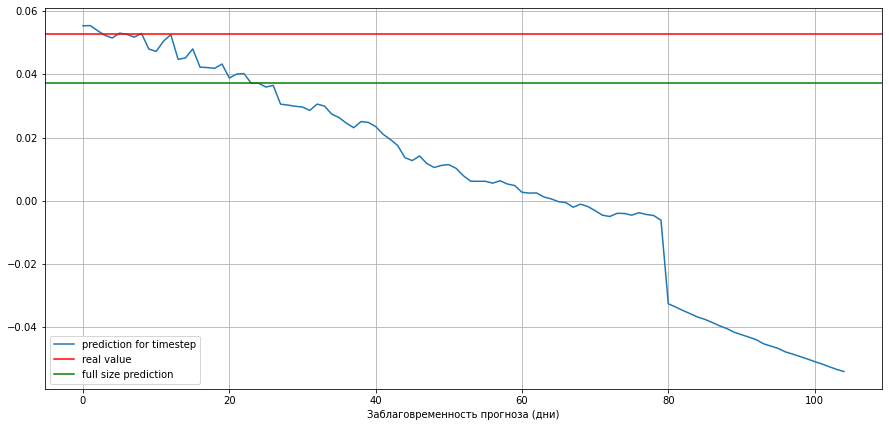

25
Real Value: 0.05987432096699807


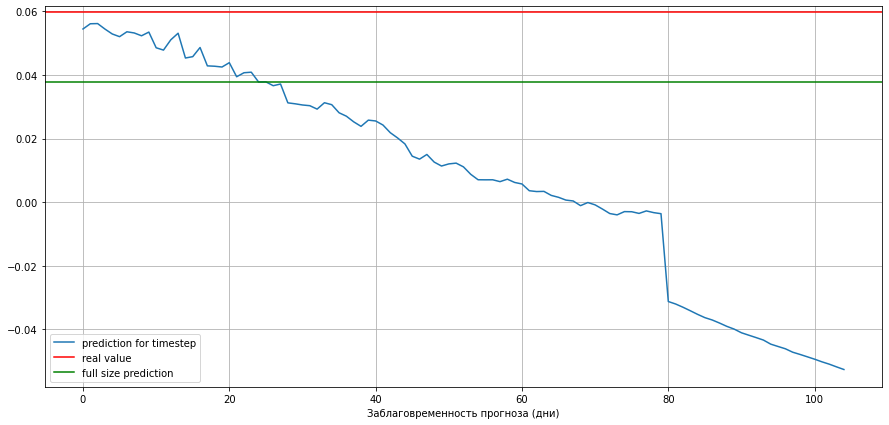

26
Real Value: 0.054643014159152424


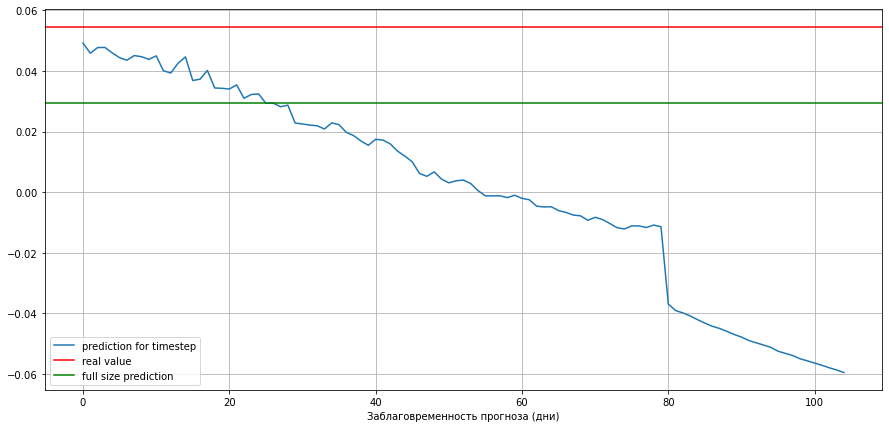

27
Real Value: 0.05348269449211857


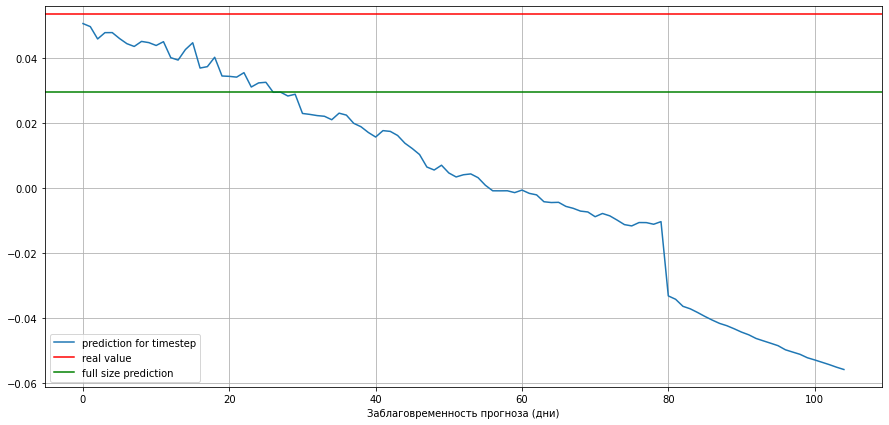

28
Real Value: 0.049536897321066115


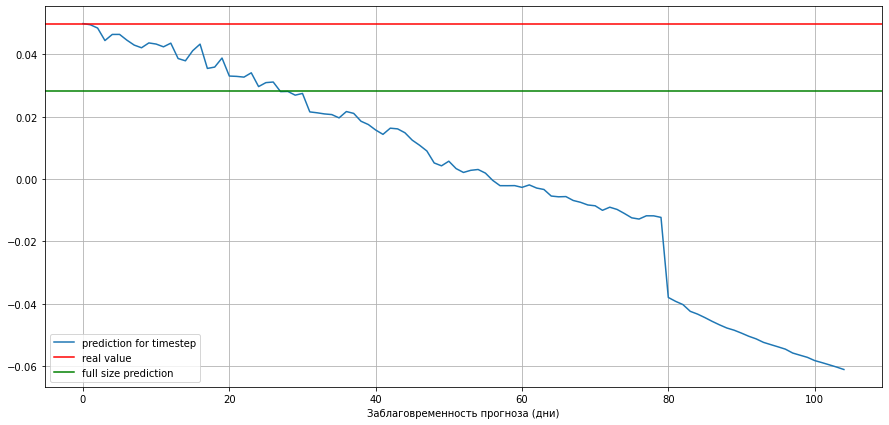

29
Real Value: 0.037234205257877434


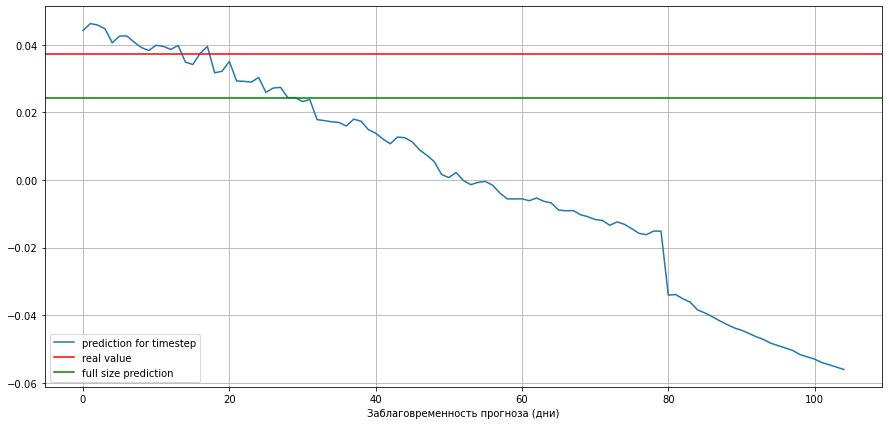

30
Real Value: 0.023215437398635283


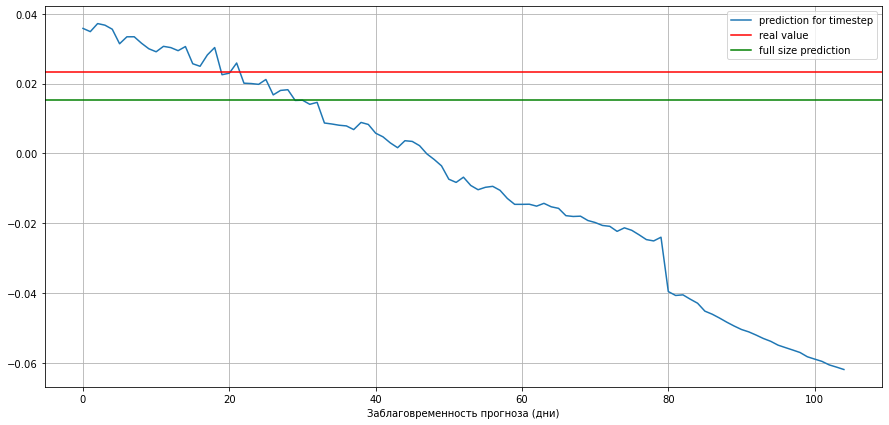

31
Real Value: 0.026341078722023605


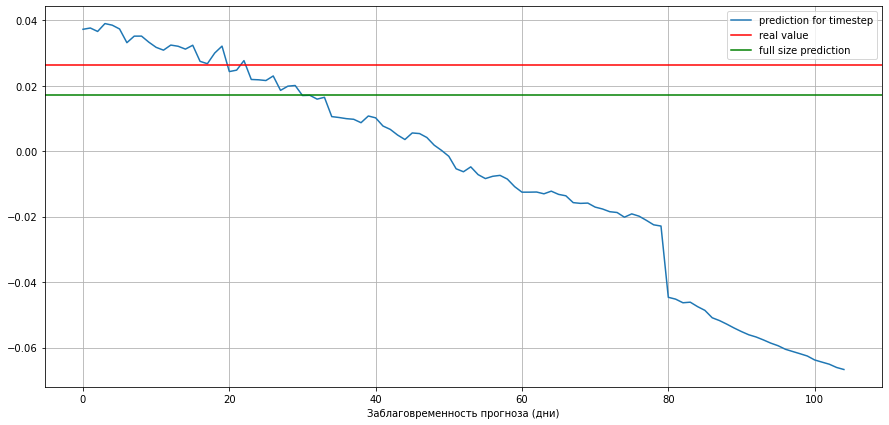

32
Real Value: 0.02914355436564397


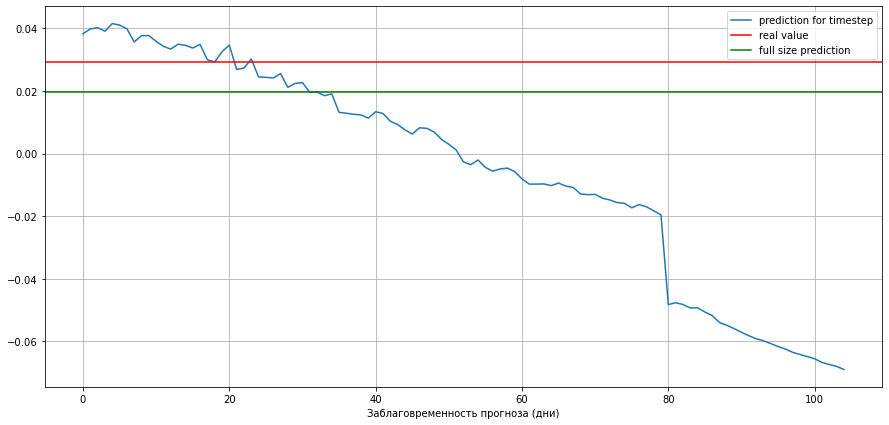

33
Real Value: 0.03350383674161902


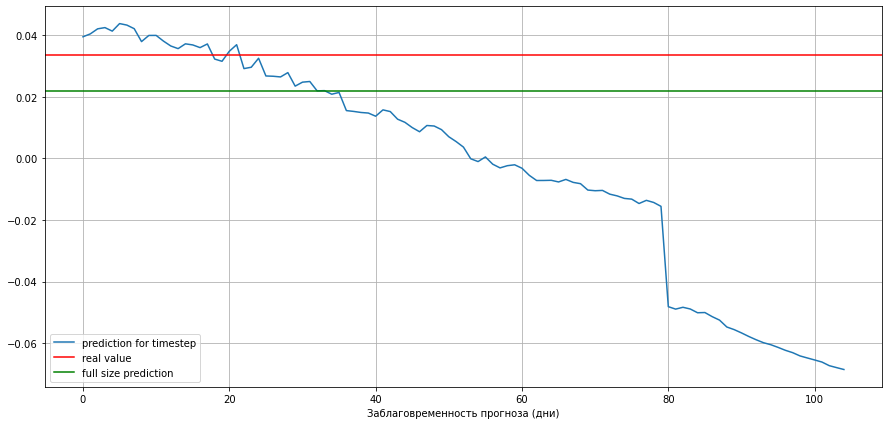

34
Real Value: 0.036946933612420386


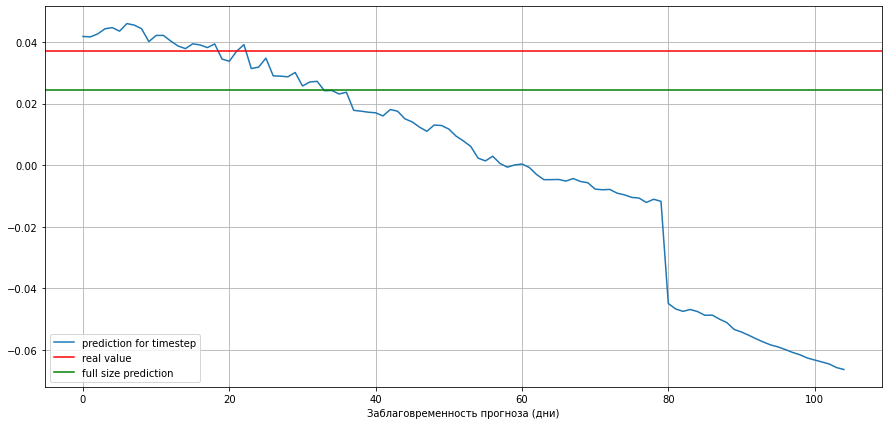

35
Real Value: 0.019425755449842874


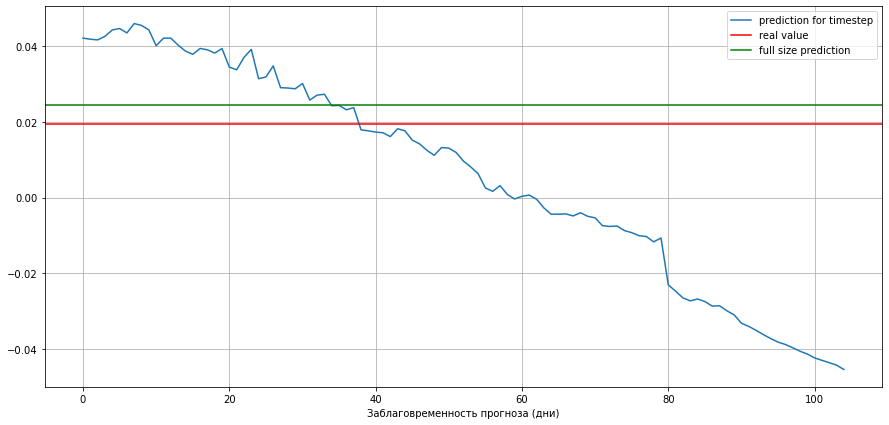

36
Real Value: 0.015888319068613786


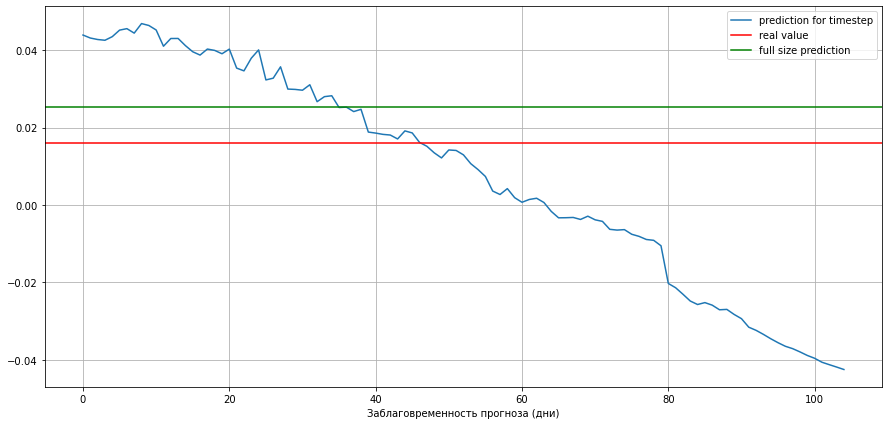

37
Real Value: 0.018143727493104236


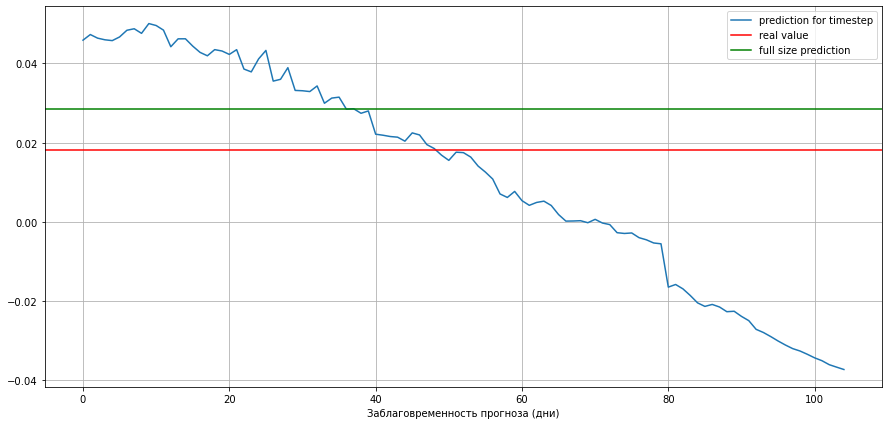

38
Real Value: 0.00681031363233861


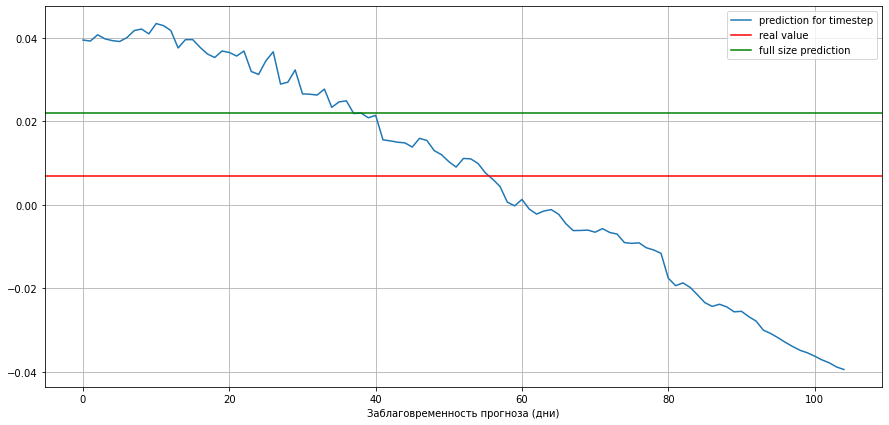

39
Real Value: 0.017462467664326388


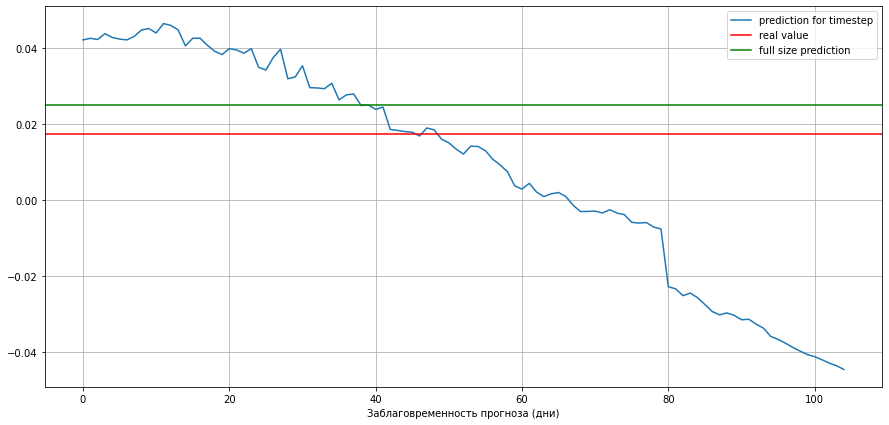

40
Real Value: 0.015455044384257662


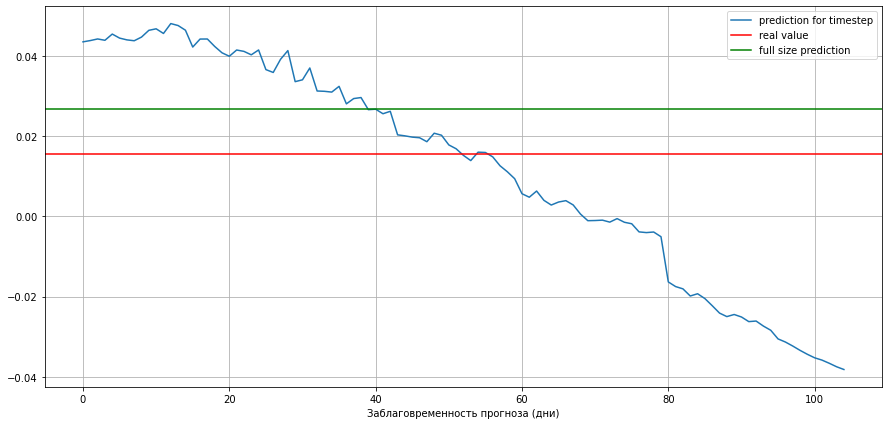

41
Real Value: 0.03074499240991759


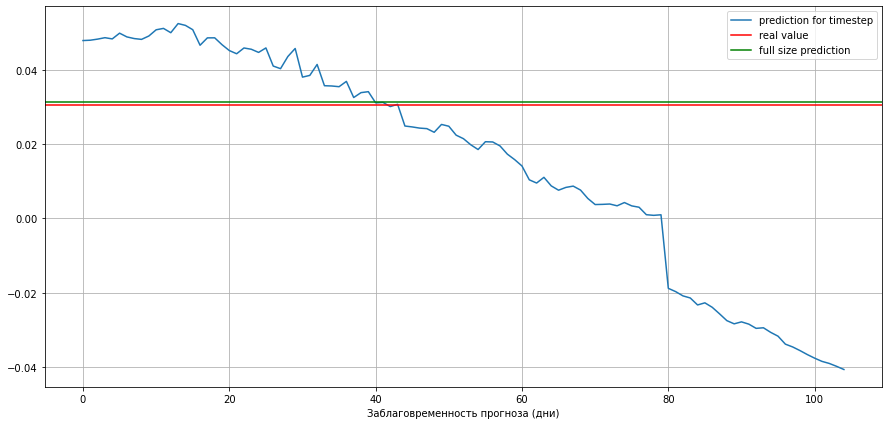

42
Real Value: 0.028185510445237053


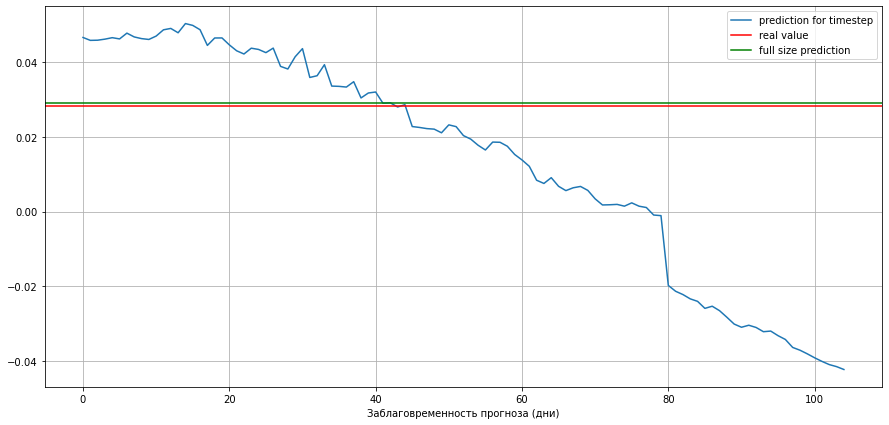

43
Real Value: 0.03189783780289705


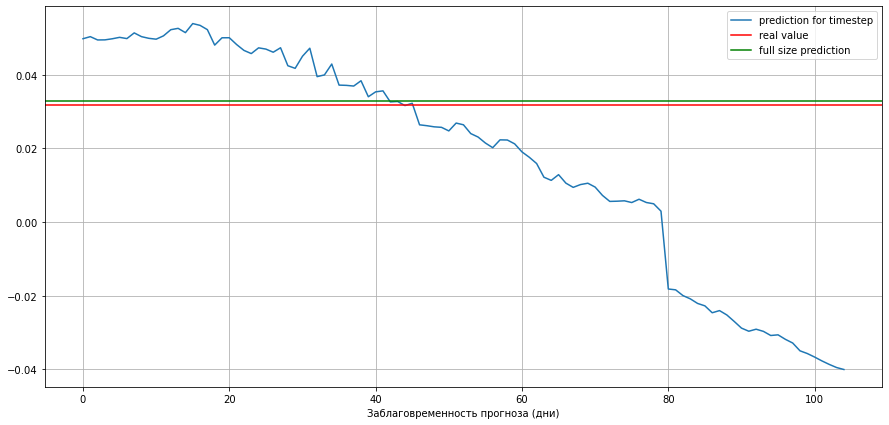

44


KeyboardInterrupt: 

In [27]:
errors_df=pd.DataFrame(columns = ['POINT', 'MSE_ARIMA', 'MAE_ARIMA', 'MAPE_ARIMA', 'R^2_ARIMA', 'KS_ARIMA',
                                  'MSE_HYB', 'MAE_HYB', 'MAPE_HYB', 'R^2_HYB', 'KS_HYB'])

forc_n=105
for column in list(df_rean.columns.values):
    if column!='dates':
        test = df_rean[column][-forc_n:]
        test.index = df_rean['dates'][-forc_n:]
        data = df_rean[column][:-forc_n]
        data.index = df_rean['dates'][:-forc_n]

        nemo_pr=df_nemo[column][-forc_n:]
        nemo_pr.index = df_nemo['dates'][-forc_n:]

        stlf = STLForecast(data, ARIMA, period=80, model_kwargs={"order": (2, 1, 0)})
        model_res = stlf.fit()
        full_size_forecast=model_res.forecast(forc_n)
        plt.plot(full_size_forecast, c='g')
        plt.plot(test, c='r')
        plt.show()
        
        for j in range (forc_n):
            print(j)
            predictions_list=[]
            for i in range (forc_n):
                data = df_rean[column][:-forc_n+j-i]
                f_size = i+1
                
                stlf = STLForecast(data, ARIMA, period=80, model_kwargs={"order": (2, 1, 0)})
                model_res = stlf.fit()
                forecasts_i = model_res.forecast(f_size).tolist()[-1] 
                predictions_list.append(forecasts_i)
            
            print('Real Value: %s'%str(test[j]))
            plt.plot(np.arange(len(predictions_list)), predictions_list, label='prediction for timestep')
            plt.axhline(y=test[j], color='r', linestyle='-', label='real value')
            plt.axhline(y=full_size_forecast[j], color='g', linestyle='-', label='full size prediction')
            plt.xlabel("Заблаговременность прогноза (дни)")
            plt.legend()
            plt.grid()
            plt.show()
            
        '''
        hybrid_forecact=(nemo_pr+forecasts)/2
        
        params_hyb = norm.fit(test-hybrid_forecact)
        ks_hyb = kstest(test-hybrid_forecact, 'norm', params, N=1000)[1]
        params_ARIMA = norm.fit(test-forecasts)
        ks_ARIMA = kstest(test-forecasts, 'norm', params, N=1000)[1]
        
        
        plt.rcParams['figure.figsize'] = [17, 4]
        plt.plot(data, label='Train')
        plt.plot(test, c='r', label='Test')
        plt.plot(hybrid_forecact, label='Hybrid')
        plt.plot(forecasts, label='ARIMA', linewidth=0.5)
        plt.plot(df_nemo['dates'], df_nemo[column], label='NEMO', linewidth=0.5)

        plt.title(df_rean[column].name)
        plt.legend()
        plt.grid()
        plt.show()
        
        errors_df = errors_df.append({'POINT': column, 
                                      'MSE_ARIMA': mean_squared_error(test, forecasts),
                                      'MAE_ARIMA':mean_absolute_error(test, forecasts),
                                      'MAPE_ARIMA':round(np.mean(np.abs(test-forecasts)/test)*100,3),
                                      'R^2_ARIMA':r2_score(test, forecasts),
                                      'KS_ARIMA':ks_ARIMA,
                                      'MSE_HYB':mean_squared_error(test, hybrid_forecact),
                                      'MAE_HYB':mean_absolute_error(test, hybrid_forecact),
                                      'MAPE_HYB':round(np.mean(np.abs(test-hybrid_forecact)/test)*100,3),
                                      'R^2_HYB':r2_score(test, hybrid_forecact),
                                      'KS_HYB':ks_hyb,
                                     } , ignore_index=True)
       
        print('Hybrid:')
        print("MSE = ", mean_squared_error(test, hybrid_forecact))
        print("MAE = ", mean_absolute_error(test, hybrid_forecact))
        print("MAPE = ", round(np.mean(np.abs(test-hybrid_forecact)/test)*100,3))
        print("R^2 = ", r2_score(test, hybrid_forecact))        
        print('\n')
        print('ARIMA:')
        print("MSE = ", mean_squared_error(test, forecasts))
        print("MAE = ", mean_absolute_error(test, forecasts))
        print("MAPE = ", round(np.mean(np.abs(test-forecasts)/test)*100,3))
        print("R^2 = ", r2_score(test, forecasts))

        plt.rcParams['figure.figsize'] = [4, 4]
        sns.distplot(test-hybrid_forecact)
        plt.show()
        '''
#errors_df

In [83]:
errors_df['MSE_DIF']=abs(errors_df['MSE_HYB'])-abs(errors_df['MSE_ARIMA'])
errors_df['MAE_DIF']=abs(errors_df['MAE_HYB'])-abs(errors_df['MAE_ARIMA'])
errors_df['MAPE_DIF']=abs(errors_df['MAPE_HYB'])-abs(errors_df['MAPE_ARIMA'])
errors_df['R^2_DIF']=abs(errors_df['R^2_HYB'])-abs(errors_df['R^2_ARIMA'])
errors_df['KS_DIF']=abs(errors_df['KS_HYB'])-abs(errors_df['KS_ARIMA'])
errors_df

POINT  MSE_ARIMA  MAE_ARIMA  MAPE_ARIMA  R^2_ARIMA      KS_ARIMA  \
0     76.04_8.72   0.000313   0.013806      27.756  -0.414904  8.658555e-15   
1     75.84_8.72   0.000223   0.011373      29.050  -0.105822  1.281695e-08   
2     75.64_8.72   0.000153   0.009308      26.323   0.151059  9.038797e-04   
3     75.44_8.72   0.000172   0.009842      32.949   0.107688  1.391423e-06   
4     76.44_9.72   0.000325   0.014418      22.264  -0.133968  3.331730e-13   
..           ...        ...        ...         ...        ...           ...   
272  77.04_31.72   0.001094   0.026196      31.042   0.398227  9.729972e-14   
273  76.84_31.72   0.001059   0.025771      31.445   0.444881  5.692690e-11   
274  76.64_31.72   0.000901   0.022521       3.773   0.549537  4.415490e-04   
275  76.44_31.72   0.000948   0.022656      18.552   0.555450  4.592298e-03   
276  76.84_32.72   0.001070   0.026460       9.091   0.404596  1.003272e-14   

      MSE_HYB   MAE_HYB  MAPE_HYB   R^2_HYB        KS_HYB   MSE_DIF   MAE_DIF  \
0    0.000236  0.011910    25.055 -0.069203  1.536444e-06 -0.000076 -0.001896   
1    0.000137  0.008943    24.668  0.319559  8.424171e-06 -0.000086 -0.002430   
2    0.000115  0.008078    23.437  0.361944  7.562516e-05 -0.000038 -0.001230   
3    0.000192  0.010675    34.441  0.002648  1.077723e-06  0.000020  0.000832   
4    0.000545  0.019037    29.027 -0.904133  2.860380e-18  0.000221  0.004619   
..        ...       ...       ...       ...           ...       ...       ...   
272  0.000868  0.023160    34.034  0.522761  1.430341e-03 -0.000226 -0.003036   
273  0.000919  0.024323    44.403  0.518541  4.221367e-04 -0.000141 -0.001448   
274  0.000875  0.022908    38.258  0.562274  1.853651e-01 -0.000025  0.000387   
275  0.000904  0.023130    43.146  0.576342  1.554713e-01 -0.000045  0.000474   
276  0.000839  0.022789   -13.270  0.533316  2.636804e-03 -0.000231 -0.003671   

     MAPE_DIF   R^2_DIF        KS_DIF  
0      -2.701 -0.345702  1.536444e-06  
1      -4.382  0.213738  8.411354e-06  
2      -2.886  0.210886 -8.282545e-04  
3       1.492 -0.105040 -3.137002e-07  
4       6.763  0.770165 -3.331701e-13  
..        ...       ...           ...  
272     2.992  0.124534  1.430341e-03  
273    12.958  0.073660  4.221367e-04  
274    34.485  0.012736  1.849236e-01  
275    24.594  0.020891  1.508790e-01  
276     4.179  0.128720  2.636804e-03  

[277 rows x 16 columns]

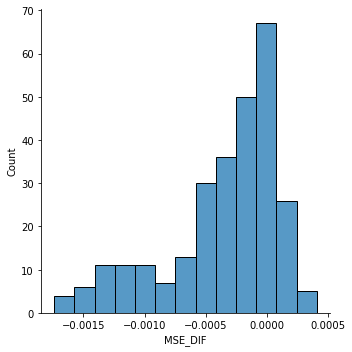

In [79]:
sns.displot(errors_df, x="MSE_DIF")

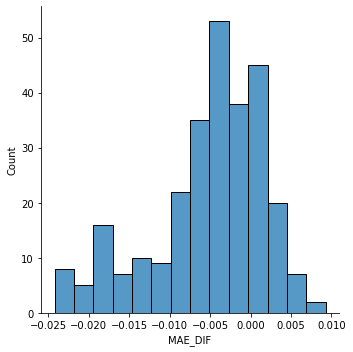

In [80]:
sns.displot(errors_df, x="MAE_DIF")

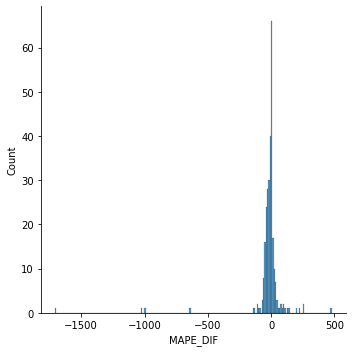

In [81]:
sns.displot(errors_df, x="MAPE_DIF")

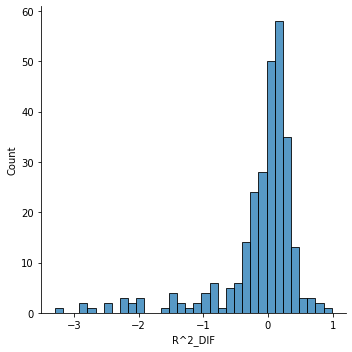

In [82]:
sns.displot(errors_df, x="R^2_DIF")

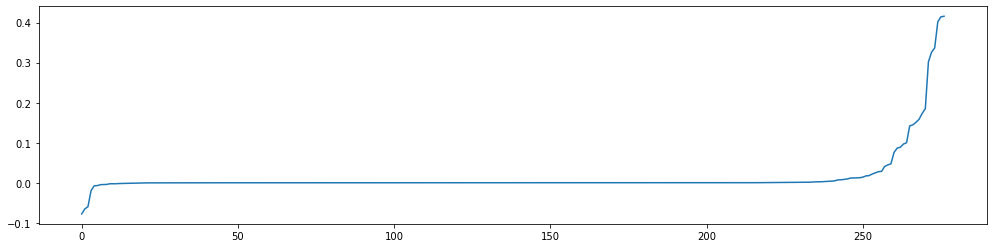

In [98]:
plt.rcParams['figure.figsize'] = [17, 4]
l=errors_df['KS_DIF'].tolist()
l.sort()
plt.plot(np.arange(len(l)), l)

In [99]:
lat = []  
lon = []
for values in errors_df['POINT']:
    lat.append(values.split('_')[0])
    lon.append(values.split('_')[1])

errors_df['lat'] = lat
errors_df['lon'] = lon
errors_df

POINT  MSE_ARIMA  MAE_ARIMA  MAPE_ARIMA  R^2_ARIMA      KS_ARIMA  \
0     76.04_8.72   0.000313   0.013806      27.756  -0.414904  8.658555e-15   
1     75.84_8.72   0.000223   0.011373      29.050  -0.105822  1.281695e-08   
2     75.64_8.72   0.000153   0.009308      26.323   0.151059  9.038797e-04   
3     75.44_8.72   0.000172   0.009842      32.949   0.107688  1.391423e-06   
4     76.44_9.72   0.000325   0.014418      22.264  -0.133968  3.331730e-13   
..           ...        ...        ...         ...        ...           ...   
272  77.04_31.72   0.001094   0.026196      31.042   0.398227  9.729972e-14   
273  76.84_31.72   0.001059   0.025771      31.445   0.444881  5.692690e-11   
274  76.64_31.72   0.000901   0.022521       3.773   0.549537  4.415490e-04   
275  76.44_31.72   0.000948   0.022656      18.552   0.555450  4.592298e-03   
276  76.84_32.72   0.001070   0.026460       9.091   0.404596  1.003272e-14   

      MSE_HYB   MAE_HYB  MAPE_HYB   R^2_HYB        KS_HYB   MSE_DIF   MAE_DIF  \
0    0.000236  0.011910    25.055 -0.069203  1.536444e-06 -0.000076 -0.001896   
1    0.000137  0.008943    24.668  0.319559  8.424171e-06 -0.000086 -0.002430   
2    0.000115  0.008078    23.437  0.361944  7.562516e-05 -0.000038 -0.001230   
3    0.000192  0.010675    34.441  0.002648  1.077723e-06  0.000020  0.000832   
4    0.000545  0.019037    29.027 -0.904133  2.860380e-18  0.000221  0.004619   
..        ...       ...       ...       ...           ...       ...       ...   
272  0.000868  0.023160    34.034  0.522761  1.430341e-03 -0.000226 -0.003036   
273  0.000919  0.024323    44.403  0.518541  4.221367e-04 -0.000141 -0.001448   
274  0.000875  0.022908    38.258  0.562274  1.853651e-01 -0.000025  0.000387   
275  0.000904  0.023130    43.146  0.576342  1.554713e-01 -0.000045  0.000474   
276  0.000839  0.022789   -13.270  0.533316  2.636804e-03 -0.000231 -0.003671   

     MAPE_DIF   R^2_DIF        KS_DIF    lat    lon  
0      -2.701 -0.345702  1.536444e-06  76.04   8.72  
1      -4.382  0.213738  8.411354e-06  75.84   8.72  
2      -2.886  0.210886 -8.282545e-04  75.64   8.72  
3       1.492 -0.105040 -3.137002e-07  75.44   8.72  
4       6.763  0.770165 -3.331701e-13  76.44   9.72  
..        ...       ...           ...    ...    ...  
272     2.992  0.124534  1.430341e-03  77.04  31.72  
273    12.958  0.073660  4.221367e-04  76.84  31.72  
274    34.485  0.012736  1.849236e-01  76.64  31.72  
275    24.594  0.020891  1.508790e-01  76.44  31.72  
276     4.179  0.128720  2.636804e-03  76.84  32.72  

[277 rows x 18 columns]

In [101]:
errors_df.to_csv('./errors_report_ARIMA_vs_Hybrid.csv', sep=';', index=False)